<a href="https://colab.research.google.com/github/Justus-coded/Competitions/blob/master/DSN%20AI%20Bootcamp%20Qualification%20Hackathon/DSN%20AI%20Bootcamp%20Qualification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
#train = pd.read_csv("/content/drive/My Drive/DSN AI Bootcamp Qualification Hackathon/Train.csv")
#test = pd.read_csv('/content/drive/My Drive/DSN AI Bootcamp Qualification Hackathon/Test.csv')
#submission = pd.read_csv('/content/drive/My Drive/DSN AI Bootcamp Qualification Hackathon/submission.csv')
train = pd.read_csv("../input/dsn-ai-bootcamp-data/Train.csv")
test = pd.read_csv('../input/dsn-ai-bootcamp-data/Test.csv')
submission = pd.read_csv('../input/dsn-ai-bootcamp-data/SampleSubmission.csv')

In [ ]:
#train.info()

In [ ]:
train.describe()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,...,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field48,form_field49,form_field50
count,53471.000000,52156.000000,55645.000000,55645.000000,55645.000000,4.264000e+04,5.083700e+04,4.264000e+04,4.799200e+04,5.564500e+04,...,12271.000000,17771.000000,54677.000000,55432.000000,50617.000000,24683.000000,40096.000000,3.511100e+04,55645.000000,4.494400e+04
mean,3491.795665,0.550737,1.052225,0.851979,1.956317,6.244479e+05,6.865210e+06,2.626690e+06,1.316002e+07,1.185585e+07,...,147.797977,108.117363,0.368215,6.634511,0.563377,0.072520,0.095371,3.052449e+05,1.049061,6.005862e+05
std,188.462426,0.820979,2.147768,3.157692,10.512396,1.433422e+06,1.912729e+07,3.927355e+06,1.977963e+07,2.669459e+07,...,45.085889,36.765769,0.412858,6.378946,0.196973,0.291146,0.335210,1.647757e+06,1.806160,5.842405e+06
min,2990.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.021000,0.000000,0.000000,0.000000,0.048528,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,3358.000000,0.070788,0.000000,0.000000,0.000000,1.400400e+04,6.869740e+05,1.929440e+05,1.368502e+06,4.500730e+05,...,136.191750,87.055500,0.000000,2.020000,0.411672,0.000000,0.000000,7.710079e+01,0.000000,4.560141e-02
50%,3484.000000,0.267575,0.062000,0.000000,0.000000,1.155330e+05,2.704328e+06,9.639420e+05,5.506295e+06,3.707559e+06,...,150.000000,118.441500,0.220000,5.050000,0.588648,0.000000,0.000000,3.181243e+02,0.000000,1.703996e-01
75%,3620.000000,0.719512,1.282000,0.000000,0.000000,5.259280e+05,6.993831e+06,3.751516e+06,1.694552e+07,1.326101e+07,...,167.754000,137.496750,0.628573,10.100000,0.753840,0.000000,0.000000,1.153022e+03,1.181754,4.993370e-01
max,3900.000000,18.015050,57.371600,91.672200,407.748600,5.313546e+07,2.158794e+09,1.037397e+08,3.200533e+08,2.191361e+09,...,645.450000,255.000000,2.200000,91.910000,0.800000,5.000000,5.000000,5.321014e+07,28.000000,2.307571e+08


In [ ]:
#train.isnull().sum()/len(train) * 100

In [ ]:
new_train = train.drop(columns=['form_field31','form_field40','form_field41'])
#new_train = train
#print(new_train.head())

In [ ]:
#test.isnull().sum()/len(test) * 100

In [ ]:
new_test = test.drop(columns=['form_field31','form_field40','form_field41'])
#new_test = test

# Training Catboost Algorithm with less preprocessing and feature engineering

## Feature Engineering

In [ ]:
new_train.fillna(-999, inplace=True)

In [ ]:
new_test.fillna(-999, inplace=True)

**Added new features**

In [ ]:
new_train['form_field1*form_field2'] = new_train.form_field1 * new_train.form_field2
new_test['form_field1*form_field2'] = new_test.form_field1 * new_test.form_field2

## Modelling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder


In [ ]:
num_cols = new_train.select_dtypes(include=np.number).columns

In [ ]:
#for col in num_cols:
 # new_train[col] = np.sqrt(new_train[col])
  #new_test[col] = np.sqrt(new_test[col])

In [ ]:
pip install --quiet catboost

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
X = new_train.drop(['default_status','Applicant_ID'], axis=1)
y =new_train.default_status

In [ ]:
le = LabelEncoder()

In [ ]:
X.form_field47.value_counts()

charge     36373
lending    19627
Name: form_field47, dtype: int64

In [ ]:
X.form_field47 = le.fit_transform(X.form_field47)
new_test.form_field47 = le.fit_transform(new_test.form_field47)


In [ ]:
#X_ = (X)
test_ = (new_test.drop('Applicant_ID', axis=1))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()

In [ ]:
#X = min_max.fit_transform(X)
#test_ = min_max.fit_transform(test_)

In [ ]:
X.shape, y.shape, test_.shape

((56000, 47), (56000,), (24000, 47))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size= 0.2, random_state=42)

## Prediction

In [ ]:
from catboost import CatBoostClassifier


In [ ]:
#cat.fit(X_train, y_train , verbose=0)

In [ ]:
y_pred = cat.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

In [ ]:
pred = cat.predict_proba(test_)
submission['default_status']= pred
submission.to_csv('sub12.csv', index=False)

### CatBoost Classifier with 0.008 LR and 4000 n_estimator with new feature

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5)

In [ ]:
cat = CatBoostClassifier(task_type='GPU', n_estimators=4000, learning_rate=0.008)

In [ ]:
#X_= pd.DataFrame(X)

roc_score = []
test_pred = []

for train_index, test_index in kf.split(X,y):
    x_train, x_test = X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]
    
    model = cat.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test,y_pred)
    pred = model.predict_proba(test_)[:,1]
    roc_score.append(score)
    test_pred.append(pred)

0:	learn: 0.6878908	total: 60.6ms	remaining: 4m 2s
1:	learn: 0.6825735	total: 122ms	remaining: 4m 3s
2:	learn: 0.6774316	total: 180ms	remaining: 4m
3:	learn: 0.6725118	total: 235ms	remaining: 3m 54s
4:	learn: 0.6679152	total: 291ms	remaining: 3m 52s
5:	learn: 0.6631261	total: 353ms	remaining: 3m 54s
6:	learn: 0.6582804	total: 407ms	remaining: 3m 52s
7:	learn: 0.6536596	total: 461ms	remaining: 3m 50s
8:	learn: 0.6490629	total: 516ms	remaining: 3m 48s
9:	learn: 0.6449059	total: 570ms	remaining: 3m 47s
10:	learn: 0.6407619	total: 624ms	remaining: 3m 46s
11:	learn: 0.6366710	total: 678ms	remaining: 3m 45s
12:	learn: 0.6325836	total: 733ms	remaining: 3m 44s
13:	learn: 0.6284941	total: 787ms	remaining: 3m 44s
14:	learn: 0.6246561	total: 842ms	remaining: 3m 43s
15:	learn: 0.6207907	total: 897ms	remaining: 3m 43s
16:	learn: 0.6173621	total: 937ms	remaining: 3m 39s
17:	learn: 0.6139231	total: 991ms	remaining: 3m 39s
18:	learn: 0.6102113	total: 1.04s	remaining: 3m 39s
19:	learn: 0.6070058	total:

158:	learn: 0.4406080	total: 9.04s	remaining: 3m 38s
159:	learn: 0.4402965	total: 9.1s	remaining: 3m 38s
160:	learn: 0.4399993	total: 9.15s	remaining: 3m 38s
161:	learn: 0.4396913	total: 9.21s	remaining: 3m 38s
162:	learn: 0.4393965	total: 9.26s	remaining: 3m 38s
163:	learn: 0.4390609	total: 9.32s	remaining: 3m 37s
164:	learn: 0.4387439	total: 9.37s	remaining: 3m 37s
165:	learn: 0.4384822	total: 9.42s	remaining: 3m 37s
166:	learn: 0.4381707	total: 9.48s	remaining: 3m 37s
167:	learn: 0.4378384	total: 9.53s	remaining: 3m 37s
168:	learn: 0.4375726	total: 9.59s	remaining: 3m 37s
169:	learn: 0.4372995	total: 9.64s	remaining: 3m 37s
170:	learn: 0.4370366	total: 9.68s	remaining: 3m 36s
171:	learn: 0.4367699	total: 9.73s	remaining: 3m 36s
172:	learn: 0.4364862	total: 9.79s	remaining: 3m 36s
173:	learn: 0.4362444	total: 9.84s	remaining: 3m 36s
174:	learn: 0.4359407	total: 9.9s	remaining: 3m 36s
175:	learn: 0.4357020	total: 9.95s	remaining: 3m 36s
176:	learn: 0.4355386	total: 10s	remaining: 3m 3

316:	learn: 0.4169227	total: 17.8s	remaining: 3m 26s
317:	learn: 0.4168655	total: 17.8s	remaining: 3m 26s
318:	learn: 0.4167861	total: 17.9s	remaining: 3m 26s
319:	learn: 0.4167307	total: 17.9s	remaining: 3m 26s
320:	learn: 0.4166668	total: 18s	remaining: 3m 26s
321:	learn: 0.4166035	total: 18.1s	remaining: 3m 26s
322:	learn: 0.4165448	total: 18.1s	remaining: 3m 26s
323:	learn: 0.4164703	total: 18.2s	remaining: 3m 26s
324:	learn: 0.4164061	total: 18.2s	remaining: 3m 26s
325:	learn: 0.4163468	total: 18.3s	remaining: 3m 25s
326:	learn: 0.4162782	total: 18.3s	remaining: 3m 25s
327:	learn: 0.4162188	total: 18.4s	remaining: 3m 25s
328:	learn: 0.4161529	total: 18.4s	remaining: 3m 25s
329:	learn: 0.4160985	total: 18.5s	remaining: 3m 25s
330:	learn: 0.4160423	total: 18.6s	remaining: 3m 25s
331:	learn: 0.4159876	total: 18.6s	remaining: 3m 25s
332:	learn: 0.4159389	total: 18.7s	remaining: 3m 25s
333:	learn: 0.4158765	total: 18.7s	remaining: 3m 25s
334:	learn: 0.4158038	total: 18.8s	remaining: 3m

475:	learn: 0.4097516	total: 26.4s	remaining: 3m 15s
476:	learn: 0.4097218	total: 26.4s	remaining: 3m 15s
477:	learn: 0.4096972	total: 26.5s	remaining: 3m 15s
478:	learn: 0.4096590	total: 26.5s	remaining: 3m 15s
479:	learn: 0.4096209	total: 26.6s	remaining: 3m 15s
480:	learn: 0.4095964	total: 26.6s	remaining: 3m 14s
481:	learn: 0.4095631	total: 26.7s	remaining: 3m 14s
482:	learn: 0.4095424	total: 26.8s	remaining: 3m 14s
483:	learn: 0.4095169	total: 26.8s	remaining: 3m 14s
484:	learn: 0.4094965	total: 26.8s	remaining: 3m 14s
485:	learn: 0.4094717	total: 26.9s	remaining: 3m 14s
486:	learn: 0.4094512	total: 26.9s	remaining: 3m 14s
487:	learn: 0.4094228	total: 27s	remaining: 3m 14s
488:	learn: 0.4093790	total: 27.1s	remaining: 3m 14s
489:	learn: 0.4093551	total: 27.3s	remaining: 3m 15s
490:	learn: 0.4093253	total: 27.4s	remaining: 3m 15s
491:	learn: 0.4093059	total: 27.6s	remaining: 3m 16s
492:	learn: 0.4092844	total: 27.6s	remaining: 3m 16s
493:	learn: 0.4092486	total: 27.7s	remaining: 3m

632:	learn: 0.4062304	total: 35.2s	remaining: 3m 7s
633:	learn: 0.4062024	total: 35.2s	remaining: 3m 7s
634:	learn: 0.4061831	total: 35.3s	remaining: 3m 6s
635:	learn: 0.4061584	total: 35.3s	remaining: 3m 6s
636:	learn: 0.4061459	total: 35.4s	remaining: 3m 6s
637:	learn: 0.4061356	total: 35.4s	remaining: 3m 6s
638:	learn: 0.4061230	total: 35.5s	remaining: 3m 6s
639:	learn: 0.4061085	total: 35.6s	remaining: 3m 6s
640:	learn: 0.4060976	total: 35.6s	remaining: 3m 6s
641:	learn: 0.4060669	total: 35.7s	remaining: 3m 6s
642:	learn: 0.4060596	total: 35.7s	remaining: 3m 6s
643:	learn: 0.4060396	total: 35.8s	remaining: 3m 6s
644:	learn: 0.4060236	total: 35.8s	remaining: 3m 6s
645:	learn: 0.4060025	total: 35.9s	remaining: 3m 6s
646:	learn: 0.4059788	total: 35.9s	remaining: 3m 6s
647:	learn: 0.4059510	total: 36s	remaining: 3m 6s
648:	learn: 0.4059112	total: 36s	remaining: 3m 6s
649:	learn: 0.4058937	total: 36.1s	remaining: 3m 6s
650:	learn: 0.4058749	total: 36.2s	remaining: 3m 5s
651:	learn: 0.40

794:	learn: 0.4034358	total: 44.3s	remaining: 2m 58s
795:	learn: 0.4034218	total: 44.3s	remaining: 2m 58s
796:	learn: 0.4034034	total: 44.4s	remaining: 2m 58s
797:	learn: 0.4033878	total: 44.4s	remaining: 2m 58s
798:	learn: 0.4033752	total: 44.5s	remaining: 2m 58s
799:	learn: 0.4033585	total: 44.5s	remaining: 2m 58s
800:	learn: 0.4033450	total: 44.6s	remaining: 2m 57s
801:	learn: 0.4033240	total: 44.6s	remaining: 2m 57s
802:	learn: 0.4032999	total: 44.7s	remaining: 2m 57s
803:	learn: 0.4032857	total: 44.7s	remaining: 2m 57s
804:	learn: 0.4032717	total: 44.8s	remaining: 2m 57s
805:	learn: 0.4032635	total: 44.8s	remaining: 2m 57s
806:	learn: 0.4032540	total: 44.9s	remaining: 2m 57s
807:	learn: 0.4032429	total: 44.9s	remaining: 2m 57s
808:	learn: 0.4032273	total: 45s	remaining: 2m 57s
809:	learn: 0.4032240	total: 45s	remaining: 2m 57s
810:	learn: 0.4032004	total: 45.1s	remaining: 2m 57s
811:	learn: 0.4031843	total: 45.2s	remaining: 2m 57s
812:	learn: 0.4031611	total: 45.2s	remaining: 2m 5

954:	learn: 0.4014072	total: 53.2s	remaining: 2m 49s
955:	learn: 0.4014036	total: 53.2s	remaining: 2m 49s
956:	learn: 0.4013923	total: 53.4s	remaining: 2m 49s
957:	learn: 0.4013800	total: 53.6s	remaining: 2m 50s
958:	learn: 0.4013657	total: 53.7s	remaining: 2m 50s
959:	learn: 0.4013490	total: 53.8s	remaining: 2m 50s
960:	learn: 0.4013372	total: 53.9s	remaining: 2m 50s
961:	learn: 0.4013277	total: 54s	remaining: 2m 50s
962:	learn: 0.4013147	total: 54.1s	remaining: 2m 50s
963:	learn: 0.4013093	total: 54.2s	remaining: 2m 50s
964:	learn: 0.4012973	total: 54.2s	remaining: 2m 50s
965:	learn: 0.4012901	total: 54.3s	remaining: 2m 50s
966:	learn: 0.4012823	total: 54.3s	remaining: 2m 50s
967:	learn: 0.4012790	total: 54.4s	remaining: 2m 50s
968:	learn: 0.4012554	total: 54.4s	remaining: 2m 50s
969:	learn: 0.4012471	total: 54.5s	remaining: 2m 50s
970:	learn: 0.4012446	total: 54.5s	remaining: 2m 50s
971:	learn: 0.4012262	total: 54.6s	remaining: 2m 50s
972:	learn: 0.4012132	total: 54.6s	remaining: 2m

1109:	learn: 0.3997654	total: 1m 2s	remaining: 2m 43s
1110:	learn: 0.3997555	total: 1m 2s	remaining: 2m 43s
1111:	learn: 0.3997500	total: 1m 3s	remaining: 2m 43s
1112:	learn: 0.3997457	total: 1m 3s	remaining: 2m 43s
1113:	learn: 0.3997262	total: 1m 3s	remaining: 2m 43s
1114:	learn: 0.3997185	total: 1m 3s	remaining: 2m 43s
1115:	learn: 0.3997131	total: 1m 3s	remaining: 2m 43s
1116:	learn: 0.3997112	total: 1m 3s	remaining: 2m 43s
1117:	learn: 0.3996981	total: 1m 3s	remaining: 2m 43s
1118:	learn: 0.3996803	total: 1m 3s	remaining: 2m 43s
1119:	learn: 0.3996721	total: 1m 3s	remaining: 2m 43s
1120:	learn: 0.3996645	total: 1m 3s	remaining: 2m 43s
1121:	learn: 0.3996573	total: 1m 3s	remaining: 2m 43s
1122:	learn: 0.3996436	total: 1m 3s	remaining: 2m 43s
1123:	learn: 0.3996356	total: 1m 3s	remaining: 2m 43s
1124:	learn: 0.3996334	total: 1m 3s	remaining: 2m 43s
1125:	learn: 0.3996229	total: 1m 3s	remaining: 2m 43s
1126:	learn: 0.3996038	total: 1m 3s	remaining: 2m 42s
1127:	learn: 0.3995960	total

1261:	learn: 0.3982613	total: 1m 11s	remaining: 2m 35s
1262:	learn: 0.3982556	total: 1m 11s	remaining: 2m 35s
1263:	learn: 0.3982422	total: 1m 11s	remaining: 2m 35s
1264:	learn: 0.3982314	total: 1m 11s	remaining: 2m 35s
1265:	learn: 0.3982264	total: 1m 11s	remaining: 2m 34s
1266:	learn: 0.3982081	total: 1m 11s	remaining: 2m 34s
1267:	learn: 0.3982026	total: 1m 11s	remaining: 2m 34s
1268:	learn: 0.3981965	total: 1m 11s	remaining: 2m 34s
1269:	learn: 0.3981924	total: 1m 11s	remaining: 2m 34s
1270:	learn: 0.3981856	total: 1m 12s	remaining: 2m 34s
1271:	learn: 0.3981812	total: 1m 12s	remaining: 2m 34s
1272:	learn: 0.3981729	total: 1m 12s	remaining: 2m 34s
1273:	learn: 0.3981641	total: 1m 12s	remaining: 2m 34s
1274:	learn: 0.3981582	total: 1m 12s	remaining: 2m 34s
1275:	learn: 0.3981443	total: 1m 12s	remaining: 2m 34s
1276:	learn: 0.3981370	total: 1m 12s	remaining: 2m 34s
1277:	learn: 0.3981161	total: 1m 12s	remaining: 2m 34s
1278:	learn: 0.3981085	total: 1m 12s	remaining: 2m 34s
1279:	lear

1412:	learn: 0.3967633	total: 1m 19s	remaining: 2m 25s
1413:	learn: 0.3967523	total: 1m 19s	remaining: 2m 25s
1414:	learn: 0.3967467	total: 1m 19s	remaining: 2m 25s
1415:	learn: 0.3967415	total: 1m 19s	remaining: 2m 25s
1416:	learn: 0.3967345	total: 1m 19s	remaining: 2m 25s
1417:	learn: 0.3967282	total: 1m 19s	remaining: 2m 25s
1418:	learn: 0.3967188	total: 1m 19s	remaining: 2m 25s
1419:	learn: 0.3967168	total: 1m 20s	remaining: 2m 25s
1420:	learn: 0.3967127	total: 1m 20s	remaining: 2m 25s
1421:	learn: 0.3967008	total: 1m 20s	remaining: 2m 25s
1422:	learn: 0.3966881	total: 1m 20s	remaining: 2m 25s
1423:	learn: 0.3966784	total: 1m 20s	remaining: 2m 25s
1424:	learn: 0.3966600	total: 1m 20s	remaining: 2m 25s
1425:	learn: 0.3966553	total: 1m 20s	remaining: 2m 25s
1426:	learn: 0.3966411	total: 1m 20s	remaining: 2m 24s
1427:	learn: 0.3966222	total: 1m 20s	remaining: 2m 24s
1428:	learn: 0.3966184	total: 1m 20s	remaining: 2m 24s
1429:	learn: 0.3965976	total: 1m 20s	remaining: 2m 24s
1430:	lear

1563:	learn: 0.3952886	total: 1m 28s	remaining: 2m 17s
1564:	learn: 0.3952805	total: 1m 28s	remaining: 2m 17s
1565:	learn: 0.3952731	total: 1m 28s	remaining: 2m 17s
1566:	learn: 0.3952630	total: 1m 28s	remaining: 2m 17s
1567:	learn: 0.3952543	total: 1m 28s	remaining: 2m 17s
1568:	learn: 0.3952395	total: 1m 28s	remaining: 2m 17s
1569:	learn: 0.3952233	total: 1m 28s	remaining: 2m 17s
1570:	learn: 0.3952145	total: 1m 28s	remaining: 2m 17s
1571:	learn: 0.3952078	total: 1m 28s	remaining: 2m 17s
1572:	learn: 0.3951965	total: 1m 28s	remaining: 2m 17s
1573:	learn: 0.3951926	total: 1m 28s	remaining: 2m 17s
1574:	learn: 0.3951812	total: 1m 29s	remaining: 2m 17s
1575:	learn: 0.3951730	total: 1m 29s	remaining: 2m 17s
1576:	learn: 0.3951647	total: 1m 29s	remaining: 2m 16s
1577:	learn: 0.3951548	total: 1m 29s	remaining: 2m 16s
1578:	learn: 0.3951501	total: 1m 29s	remaining: 2m 16s
1579:	learn: 0.3951448	total: 1m 29s	remaining: 2m 16s
1580:	learn: 0.3951437	total: 1m 29s	remaining: 2m 16s
1581:	lear

1716:	learn: 0.3938497	total: 1m 37s	remaining: 2m 9s
1717:	learn: 0.3938349	total: 1m 37s	remaining: 2m 9s
1718:	learn: 0.3938292	total: 1m 37s	remaining: 2m 8s
1719:	learn: 0.3938225	total: 1m 37s	remaining: 2m 8s
1720:	learn: 0.3938204	total: 1m 37s	remaining: 2m 8s
1721:	learn: 0.3938114	total: 1m 37s	remaining: 2m 8s
1722:	learn: 0.3938107	total: 1m 37s	remaining: 2m 8s
1723:	learn: 0.3938004	total: 1m 37s	remaining: 2m 8s
1724:	learn: 0.3937881	total: 1m 37s	remaining: 2m 8s
1725:	learn: 0.3937801	total: 1m 37s	remaining: 2m 8s
1726:	learn: 0.3937738	total: 1m 37s	remaining: 2m 8s
1727:	learn: 0.3937687	total: 1m 37s	remaining: 2m 8s
1728:	learn: 0.3937633	total: 1m 37s	remaining: 2m 8s
1729:	learn: 0.3937560	total: 1m 37s	remaining: 2m 8s
1730:	learn: 0.3937517	total: 1m 37s	remaining: 2m 8s
1731:	learn: 0.3937433	total: 1m 37s	remaining: 2m 8s
1732:	learn: 0.3937388	total: 1m 37s	remaining: 2m 8s
1733:	learn: 0.3937361	total: 1m 38s	remaining: 2m 8s
1734:	learn: 0.3937167	total

1872:	learn: 0.3924868	total: 1m 45s	remaining: 2m
1873:	learn: 0.3924834	total: 1m 45s	remaining: 2m
1874:	learn: 0.3924788	total: 1m 45s	remaining: 1m 59s
1875:	learn: 0.3924697	total: 1m 45s	remaining: 1m 59s
1876:	learn: 0.3924645	total: 1m 45s	remaining: 1m 59s
1877:	learn: 0.3924596	total: 1m 46s	remaining: 1m 59s
1878:	learn: 0.3924537	total: 1m 46s	remaining: 1m 59s
1879:	learn: 0.3924529	total: 1m 46s	remaining: 1m 59s
1880:	learn: 0.3924407	total: 1m 46s	remaining: 1m 59s
1881:	learn: 0.3924367	total: 1m 46s	remaining: 1m 59s
1882:	learn: 0.3924272	total: 1m 46s	remaining: 1m 59s
1883:	learn: 0.3924144	total: 1m 46s	remaining: 1m 59s
1884:	learn: 0.3924005	total: 1m 46s	remaining: 1m 59s
1885:	learn: 0.3923946	total: 1m 46s	remaining: 1m 59s
1886:	learn: 0.3923853	total: 1m 46s	remaining: 1m 59s
1887:	learn: 0.3923765	total: 1m 46s	remaining: 1m 59s
1888:	learn: 0.3923595	total: 1m 46s	remaining: 1m 59s
1889:	learn: 0.3923472	total: 1m 46s	remaining: 1m 59s
1890:	learn: 0.392

2024:	learn: 0.3911987	total: 1m 54s	remaining: 1m 51s
2025:	learn: 0.3911893	total: 1m 54s	remaining: 1m 51s
2026:	learn: 0.3911806	total: 1m 54s	remaining: 1m 51s
2027:	learn: 0.3911696	total: 1m 55s	remaining: 1m 51s
2028:	learn: 0.3911581	total: 1m 55s	remaining: 1m 51s
2029:	learn: 0.3911514	total: 1m 55s	remaining: 1m 51s
2030:	learn: 0.3911482	total: 1m 55s	remaining: 1m 51s
2031:	learn: 0.3911422	total: 1m 55s	remaining: 1m 51s
2032:	learn: 0.3911300	total: 1m 55s	remaining: 1m 51s
2033:	learn: 0.3911211	total: 1m 55s	remaining: 1m 51s
2034:	learn: 0.3911063	total: 1m 55s	remaining: 1m 51s
2035:	learn: 0.3910979	total: 1m 55s	remaining: 1m 51s
2036:	learn: 0.3910948	total: 1m 55s	remaining: 1m 51s
2037:	learn: 0.3910905	total: 1m 55s	remaining: 1m 51s
2038:	learn: 0.3910884	total: 1m 55s	remaining: 1m 51s
2039:	learn: 0.3910784	total: 1m 55s	remaining: 1m 51s
2040:	learn: 0.3910574	total: 1m 55s	remaining: 1m 51s
2041:	learn: 0.3910515	total: 1m 55s	remaining: 1m 51s
2042:	lear

2177:	learn: 0.3899134	total: 2m 3s	remaining: 1m 43s
2178:	learn: 0.3899062	total: 2m 3s	remaining: 1m 43s
2179:	learn: 0.3899033	total: 2m 3s	remaining: 1m 43s
2180:	learn: 0.3898956	total: 2m 4s	remaining: 1m 43s
2181:	learn: 0.3898878	total: 2m 4s	remaining: 1m 43s
2182:	learn: 0.3898849	total: 2m 4s	remaining: 1m 43s
2183:	learn: 0.3898825	total: 2m 4s	remaining: 1m 43s
2184:	learn: 0.3898723	total: 2m 4s	remaining: 1m 43s
2185:	learn: 0.3898652	total: 2m 4s	remaining: 1m 43s
2186:	learn: 0.3898625	total: 2m 4s	remaining: 1m 43s
2187:	learn: 0.3898524	total: 2m 4s	remaining: 1m 43s
2188:	learn: 0.3898422	total: 2m 4s	remaining: 1m 42s
2189:	learn: 0.3898360	total: 2m 4s	remaining: 1m 42s
2190:	learn: 0.3898180	total: 2m 4s	remaining: 1m 42s
2191:	learn: 0.3898100	total: 2m 4s	remaining: 1m 42s
2192:	learn: 0.3898050	total: 2m 4s	remaining: 1m 42s
2193:	learn: 0.3897955	total: 2m 4s	remaining: 1m 42s
2194:	learn: 0.3897859	total: 2m 4s	remaining: 1m 42s
2195:	learn: 0.3897818	total

2328:	learn: 0.3887099	total: 2m 12s	remaining: 1m 35s
2329:	learn: 0.3887068	total: 2m 12s	remaining: 1m 34s
2330:	learn: 0.3886952	total: 2m 12s	remaining: 1m 34s
2331:	learn: 0.3886800	total: 2m 12s	remaining: 1m 34s
2332:	learn: 0.3886724	total: 2m 12s	remaining: 1m 34s
2333:	learn: 0.3886613	total: 2m 12s	remaining: 1m 34s
2334:	learn: 0.3886574	total: 2m 12s	remaining: 1m 34s
2335:	learn: 0.3886423	total: 2m 12s	remaining: 1m 34s
2336:	learn: 0.3886406	total: 2m 12s	remaining: 1m 34s
2337:	learn: 0.3886391	total: 2m 12s	remaining: 1m 34s
2338:	learn: 0.3886312	total: 2m 12s	remaining: 1m 34s
2339:	learn: 0.3886221	total: 2m 13s	remaining: 1m 34s
2340:	learn: 0.3886186	total: 2m 13s	remaining: 1m 34s
2341:	learn: 0.3886139	total: 2m 13s	remaining: 1m 34s
2342:	learn: 0.3886021	total: 2m 13s	remaining: 1m 34s
2343:	learn: 0.3885989	total: 2m 13s	remaining: 1m 34s
2344:	learn: 0.3885927	total: 2m 13s	remaining: 1m 34s
2345:	learn: 0.3885855	total: 2m 13s	remaining: 1m 34s
2346:	lear

2479:	learn: 0.3875547	total: 2m 20s	remaining: 1m 26s
2480:	learn: 0.3875458	total: 2m 20s	remaining: 1m 26s
2481:	learn: 0.3875365	total: 2m 20s	remaining: 1m 26s
2482:	learn: 0.3875242	total: 2m 20s	remaining: 1m 26s
2483:	learn: 0.3875124	total: 2m 20s	remaining: 1m 26s
2484:	learn: 0.3875051	total: 2m 20s	remaining: 1m 25s
2485:	learn: 0.3874939	total: 2m 21s	remaining: 1m 25s
2486:	learn: 0.3874895	total: 2m 21s	remaining: 1m 25s
2487:	learn: 0.3874769	total: 2m 21s	remaining: 1m 25s
2488:	learn: 0.3874701	total: 2m 21s	remaining: 1m 25s
2489:	learn: 0.3874615	total: 2m 21s	remaining: 1m 25s
2490:	learn: 0.3874550	total: 2m 21s	remaining: 1m 25s
2491:	learn: 0.3874472	total: 2m 21s	remaining: 1m 25s
2492:	learn: 0.3874406	total: 2m 21s	remaining: 1m 25s
2493:	learn: 0.3874291	total: 2m 21s	remaining: 1m 25s
2494:	learn: 0.3874193	total: 2m 21s	remaining: 1m 25s
2495:	learn: 0.3874094	total: 2m 21s	remaining: 1m 25s
2496:	learn: 0.3873970	total: 2m 21s	remaining: 1m 25s
2497:	lear

2631:	learn: 0.3864563	total: 2m 29s	remaining: 1m 17s
2632:	learn: 0.3864530	total: 2m 29s	remaining: 1m 17s
2633:	learn: 0.3864442	total: 2m 29s	remaining: 1m 17s
2634:	learn: 0.3864333	total: 2m 29s	remaining: 1m 17s
2635:	learn: 0.3864225	total: 2m 29s	remaining: 1m 17s
2636:	learn: 0.3864198	total: 2m 29s	remaining: 1m 17s
2637:	learn: 0.3864165	total: 2m 29s	remaining: 1m 17s
2638:	learn: 0.3864017	total: 2m 29s	remaining: 1m 17s
2639:	learn: 0.3863881	total: 2m 29s	remaining: 1m 17s
2640:	learn: 0.3863782	total: 2m 29s	remaining: 1m 17s
2641:	learn: 0.3863764	total: 2m 29s	remaining: 1m 17s
2642:	learn: 0.3863664	total: 2m 29s	remaining: 1m 16s
2643:	learn: 0.3863616	total: 2m 29s	remaining: 1m 16s
2644:	learn: 0.3863580	total: 2m 29s	remaining: 1m 16s
2645:	learn: 0.3863456	total: 2m 30s	remaining: 1m 16s
2646:	learn: 0.3863404	total: 2m 30s	remaining: 1m 16s
2647:	learn: 0.3863261	total: 2m 30s	remaining: 1m 16s
2648:	learn: 0.3863134	total: 2m 30s	remaining: 1m 16s
2649:	lear

2783:	learn: 0.3853898	total: 2m 37s	remaining: 1m 8s
2784:	learn: 0.3853787	total: 2m 37s	remaining: 1m 8s
2785:	learn: 0.3853725	total: 2m 37s	remaining: 1m 8s
2786:	learn: 0.3853645	total: 2m 37s	remaining: 1m 8s
2787:	learn: 0.3853551	total: 2m 37s	remaining: 1m 8s
2788:	learn: 0.3853482	total: 2m 37s	remaining: 1m 8s
2789:	learn: 0.3853442	total: 2m 37s	remaining: 1m 8s
2790:	learn: 0.3853341	total: 2m 37s	remaining: 1m 8s
2791:	learn: 0.3853322	total: 2m 37s	remaining: 1m 8s
2792:	learn: 0.3853243	total: 2m 37s	remaining: 1m 8s
2793:	learn: 0.3853136	total: 2m 37s	remaining: 1m 8s
2794:	learn: 0.3853109	total: 2m 38s	remaining: 1m 8s
2795:	learn: 0.3853036	total: 2m 38s	remaining: 1m 8s
2796:	learn: 0.3853010	total: 2m 38s	remaining: 1m 8s
2797:	learn: 0.3852921	total: 2m 38s	remaining: 1m 7s
2798:	learn: 0.3852830	total: 2m 38s	remaining: 1m 7s
2799:	learn: 0.3852762	total: 2m 38s	remaining: 1m 7s
2800:	learn: 0.3852665	total: 2m 38s	remaining: 1m 7s
2801:	learn: 0.3852605	total

2938:	learn: 0.3843279	total: 2m 46s	remaining: 1m
2939:	learn: 0.3843188	total: 2m 46s	remaining: 59.9s
2940:	learn: 0.3843155	total: 2m 46s	remaining: 59.9s
2941:	learn: 0.3843045	total: 2m 46s	remaining: 59.8s
2942:	learn: 0.3842959	total: 2m 46s	remaining: 59.8s
2943:	learn: 0.3842926	total: 2m 46s	remaining: 59.7s
2944:	learn: 0.3842837	total: 2m 46s	remaining: 59.7s
2945:	learn: 0.3842811	total: 2m 46s	remaining: 59.6s
2946:	learn: 0.3842755	total: 2m 46s	remaining: 59.5s
2947:	learn: 0.3842751	total: 2m 46s	remaining: 59.5s
2948:	learn: 0.3842652	total: 2m 46s	remaining: 59.4s
2949:	learn: 0.3842552	total: 2m 46s	remaining: 59.4s
2950:	learn: 0.3842547	total: 2m 46s	remaining: 59.3s
2951:	learn: 0.3842435	total: 2m 46s	remaining: 59.3s
2952:	learn: 0.3842428	total: 2m 46s	remaining: 59.2s
2953:	learn: 0.3842347	total: 2m 47s	remaining: 59.1s
2954:	learn: 0.3842221	total: 2m 47s	remaining: 59.1s
2955:	learn: 0.3842138	total: 2m 47s	remaining: 59s
2956:	learn: 0.3842108	total: 2m 

3092:	learn: 0.3833693	total: 2m 55s	remaining: 51.4s
3093:	learn: 0.3833550	total: 2m 55s	remaining: 51.4s
3094:	learn: 0.3833474	total: 2m 55s	remaining: 51.3s
3095:	learn: 0.3833420	total: 2m 55s	remaining: 51.3s
3096:	learn: 0.3833289	total: 2m 55s	remaining: 51.2s
3097:	learn: 0.3833248	total: 2m 55s	remaining: 51.2s
3098:	learn: 0.3833169	total: 2m 55s	remaining: 51.1s
3099:	learn: 0.3833160	total: 2m 55s	remaining: 51s
3100:	learn: 0.3833124	total: 2m 55s	remaining: 51s
3101:	learn: 0.3833058	total: 2m 55s	remaining: 50.9s
3102:	learn: 0.3833007	total: 2m 55s	remaining: 50.9s
3103:	learn: 0.3833002	total: 2m 56s	remaining: 50.8s
3104:	learn: 0.3832879	total: 2m 56s	remaining: 50.8s
3105:	learn: 0.3832824	total: 2m 56s	remaining: 50.7s
3106:	learn: 0.3832731	total: 2m 56s	remaining: 50.6s
3107:	learn: 0.3832601	total: 2m 56s	remaining: 50.6s
3108:	learn: 0.3832473	total: 2m 56s	remaining: 50.5s
3109:	learn: 0.3832468	total: 2m 56s	remaining: 50.5s
3110:	learn: 0.3832414	total: 2m

3247:	learn: 0.3824021	total: 3m 4s	remaining: 42.8s
3248:	learn: 0.3823875	total: 3m 4s	remaining: 42.8s
3249:	learn: 0.3823760	total: 3m 5s	remaining: 42.7s
3250:	learn: 0.3823700	total: 3m 5s	remaining: 42.6s
3251:	learn: 0.3823637	total: 3m 5s	remaining: 42.6s
3252:	learn: 0.3823587	total: 3m 5s	remaining: 42.5s
3253:	learn: 0.3823511	total: 3m 5s	remaining: 42.5s
3254:	learn: 0.3823476	total: 3m 5s	remaining: 42.4s
3255:	learn: 0.3823461	total: 3m 5s	remaining: 42.4s
3256:	learn: 0.3823399	total: 3m 5s	remaining: 42.3s
3257:	learn: 0.3823384	total: 3m 5s	remaining: 42.2s
3258:	learn: 0.3823267	total: 3m 5s	remaining: 42.2s
3259:	learn: 0.3823202	total: 3m 5s	remaining: 42.1s
3260:	learn: 0.3823076	total: 3m 5s	remaining: 42.1s
3261:	learn: 0.3823066	total: 3m 5s	remaining: 42s
3262:	learn: 0.3823017	total: 3m 5s	remaining: 42s
3263:	learn: 0.3822952	total: 3m 5s	remaining: 41.9s
3264:	learn: 0.3822939	total: 3m 5s	remaining: 41.8s
3265:	learn: 0.3822919	total: 3m 5s	remaining: 41.

3401:	learn: 0.3814461	total: 3m 13s	remaining: 34s
3402:	learn: 0.3814449	total: 3m 13s	remaining: 34s
3403:	learn: 0.3814392	total: 3m 13s	remaining: 33.9s
3404:	learn: 0.3814333	total: 3m 13s	remaining: 33.9s
3405:	learn: 0.3814319	total: 3m 13s	remaining: 33.8s
3406:	learn: 0.3814284	total: 3m 13s	remaining: 33.8s
3407:	learn: 0.3814203	total: 3m 13s	remaining: 33.7s
3408:	learn: 0.3814121	total: 3m 14s	remaining: 33.6s
3409:	learn: 0.3814077	total: 3m 14s	remaining: 33.6s
3410:	learn: 0.3814024	total: 3m 14s	remaining: 33.5s
3411:	learn: 0.3814002	total: 3m 14s	remaining: 33.5s
3412:	learn: 0.3813995	total: 3m 14s	remaining: 33.4s
3413:	learn: 0.3813927	total: 3m 14s	remaining: 33.4s
3414:	learn: 0.3813883	total: 3m 14s	remaining: 33.3s
3415:	learn: 0.3813866	total: 3m 14s	remaining: 33.2s
3416:	learn: 0.3813796	total: 3m 14s	remaining: 33.2s
3417:	learn: 0.3813688	total: 3m 14s	remaining: 33.1s
3418:	learn: 0.3813678	total: 3m 14s	remaining: 33.1s
3419:	learn: 0.3813603	total: 3m

3557:	learn: 0.3805548	total: 3m 22s	remaining: 25.1s
3558:	learn: 0.3805485	total: 3m 22s	remaining: 25s
3559:	learn: 0.3805372	total: 3m 22s	remaining: 25s
3560:	learn: 0.3805319	total: 3m 22s	remaining: 24.9s
3561:	learn: 0.3805239	total: 3m 22s	remaining: 24.9s
3562:	learn: 0.3805224	total: 3m 22s	remaining: 24.8s
3563:	learn: 0.3805159	total: 3m 22s	remaining: 24.8s
3564:	learn: 0.3805108	total: 3m 22s	remaining: 24.7s
3565:	learn: 0.3805079	total: 3m 22s	remaining: 24.6s
3566:	learn: 0.3804990	total: 3m 22s	remaining: 24.6s
3567:	learn: 0.3804900	total: 3m 22s	remaining: 24.5s
3568:	learn: 0.3804793	total: 3m 22s	remaining: 24.5s
3569:	learn: 0.3804674	total: 3m 22s	remaining: 24.4s
3570:	learn: 0.3804613	total: 3m 23s	remaining: 24.4s
3571:	learn: 0.3804504	total: 3m 23s	remaining: 24.3s
3572:	learn: 0.3804499	total: 3m 23s	remaining: 24.3s
3573:	learn: 0.3804398	total: 3m 23s	remaining: 24.2s
3574:	learn: 0.3804376	total: 3m 23s	remaining: 24.2s
3575:	learn: 0.3804356	total: 3m

3711:	learn: 0.3796361	total: 3m 30s	remaining: 16.4s
3712:	learn: 0.3796315	total: 3m 31s	remaining: 16.3s
3713:	learn: 0.3796246	total: 3m 31s	remaining: 16.3s
3714:	learn: 0.3796133	total: 3m 31s	remaining: 16.2s
3715:	learn: 0.3796073	total: 3m 31s	remaining: 16.1s
3716:	learn: 0.3796020	total: 3m 31s	remaining: 16.1s
3717:	learn: 0.3796013	total: 3m 31s	remaining: 16s
3718:	learn: 0.3795919	total: 3m 31s	remaining: 16s
3719:	learn: 0.3795813	total: 3m 31s	remaining: 15.9s
3720:	learn: 0.3795763	total: 3m 31s	remaining: 15.9s
3721:	learn: 0.3795663	total: 3m 31s	remaining: 15.8s
3722:	learn: 0.3795602	total: 3m 31s	remaining: 15.7s
3723:	learn: 0.3795574	total: 3m 31s	remaining: 15.7s
3724:	learn: 0.3795480	total: 3m 31s	remaining: 15.6s
3725:	learn: 0.3795378	total: 3m 31s	remaining: 15.6s
3726:	learn: 0.3795289	total: 3m 31s	remaining: 15.5s
3727:	learn: 0.3795178	total: 3m 31s	remaining: 15.5s
3728:	learn: 0.3795114	total: 3m 31s	remaining: 15.4s
3729:	learn: 0.3794997	total: 3m

3866:	learn: 0.3787671	total: 3m 39s	remaining: 7.56s
3867:	learn: 0.3787595	total: 3m 39s	remaining: 7.5s
3868:	learn: 0.3787589	total: 3m 39s	remaining: 7.45s
3869:	learn: 0.3787563	total: 3m 39s	remaining: 7.39s
3870:	learn: 0.3787503	total: 3m 40s	remaining: 7.33s
3871:	learn: 0.3787414	total: 3m 40s	remaining: 7.28s
3872:	learn: 0.3787394	total: 3m 40s	remaining: 7.22s
3873:	learn: 0.3787291	total: 3m 40s	remaining: 7.16s
3874:	learn: 0.3787198	total: 3m 40s	remaining: 7.1s
3875:	learn: 0.3787160	total: 3m 40s	remaining: 7.05s
3876:	learn: 0.3787086	total: 3m 40s	remaining: 6.99s
3877:	learn: 0.3787066	total: 3m 40s	remaining: 6.93s
3878:	learn: 0.3787007	total: 3m 40s	remaining: 6.88s
3879:	learn: 0.3786996	total: 3m 40s	remaining: 6.82s
3880:	learn: 0.3786970	total: 3m 40s	remaining: 6.76s
3881:	learn: 0.3786889	total: 3m 40s	remaining: 6.71s
3882:	learn: 0.3786810	total: 3m 40s	remaining: 6.65s
3883:	learn: 0.3786796	total: 3m 40s	remaining: 6.59s
3884:	learn: 0.3786789	total: 

21:	learn: 0.5983742	total: 1.17s	remaining: 3m 31s
22:	learn: 0.5949359	total: 1.22s	remaining: 3m 31s
23:	learn: 0.5918611	total: 1.26s	remaining: 3m 29s
24:	learn: 0.5886717	total: 1.32s	remaining: 3m 29s
25:	learn: 0.5857070	total: 1.37s	remaining: 3m 29s
26:	learn: 0.5827036	total: 1.43s	remaining: 3m 30s
27:	learn: 0.5798131	total: 1.48s	remaining: 3m 30s
28:	learn: 0.5768151	total: 1.54s	remaining: 3m 31s
29:	learn: 0.5739541	total: 1.6s	remaining: 3m 32s
30:	learn: 0.5710780	total: 1.66s	remaining: 3m 32s
31:	learn: 0.5684706	total: 1.71s	remaining: 3m 32s
32:	learn: 0.5657080	total: 1.77s	remaining: 3m 32s
33:	learn: 0.5628984	total: 1.82s	remaining: 3m 32s
34:	learn: 0.5608760	total: 1.85s	remaining: 3m 29s
35:	learn: 0.5582187	total: 1.9s	remaining: 3m 29s
36:	learn: 0.5557628	total: 1.96s	remaining: 3m 29s
37:	learn: 0.5532676	total: 2.01s	remaining: 3m 29s
38:	learn: 0.5512153	total: 2.07s	remaining: 3m 29s
39:	learn: 0.5486993	total: 2.12s	remaining: 3m 29s
40:	learn: 0.5

178:	learn: 0.4329722	total: 10.9s	remaining: 3m 53s
179:	learn: 0.4327129	total: 11s	remaining: 3m 53s
180:	learn: 0.4325223	total: 11.1s	remaining: 3m 53s
181:	learn: 0.4323337	total: 11.1s	remaining: 3m 53s
182:	learn: 0.4321133	total: 11.2s	remaining: 3m 52s
183:	learn: 0.4318574	total: 11.2s	remaining: 3m 52s
184:	learn: 0.4316530	total: 11.3s	remaining: 3m 52s
185:	learn: 0.4314599	total: 11.4s	remaining: 3m 52s
186:	learn: 0.4312255	total: 11.4s	remaining: 3m 52s
187:	learn: 0.4310115	total: 11.5s	remaining: 3m 52s
188:	learn: 0.4307741	total: 11.5s	remaining: 3m 52s
189:	learn: 0.4305671	total: 11.6s	remaining: 3m 52s
190:	learn: 0.4303518	total: 11.6s	remaining: 3m 52s
191:	learn: 0.4301947	total: 11.7s	remaining: 3m 51s
192:	learn: 0.4299990	total: 11.7s	remaining: 3m 51s
193:	learn: 0.4297844	total: 11.8s	remaining: 3m 51s
194:	learn: 0.4295965	total: 11.9s	remaining: 3m 51s
195:	learn: 0.4294056	total: 11.9s	remaining: 3m 51s
196:	learn: 0.4291930	total: 12s	remaining: 3m 5

334:	learn: 0.4136986	total: 20s	remaining: 3m 39s
335:	learn: 0.4136387	total: 20.1s	remaining: 3m 39s
336:	learn: 0.4135847	total: 20.1s	remaining: 3m 39s
337:	learn: 0.4135116	total: 20.2s	remaining: 3m 38s
338:	learn: 0.4134702	total: 20.3s	remaining: 3m 38s
339:	learn: 0.4133780	total: 20.3s	remaining: 3m 38s
340:	learn: 0.4133167	total: 20.4s	remaining: 3m 38s
341:	learn: 0.4132618	total: 20.4s	remaining: 3m 38s
342:	learn: 0.4131787	total: 20.5s	remaining: 3m 38s
343:	learn: 0.4131290	total: 20.5s	remaining: 3m 38s
344:	learn: 0.4130753	total: 20.6s	remaining: 3m 38s
345:	learn: 0.4130244	total: 20.6s	remaining: 3m 37s
346:	learn: 0.4129916	total: 20.7s	remaining: 3m 37s
347:	learn: 0.4129265	total: 20.7s	remaining: 3m 37s
348:	learn: 0.4128663	total: 20.8s	remaining: 3m 37s
349:	learn: 0.4127941	total: 20.9s	remaining: 3m 37s
350:	learn: 0.4127328	total: 20.9s	remaining: 3m 37s
351:	learn: 0.4126961	total: 20.9s	remaining: 3m 37s
352:	learn: 0.4126399	total: 21s	remaining: 3m 3

491:	learn: 0.4072526	total: 28.4s	remaining: 3m 22s
492:	learn: 0.4072188	total: 28.4s	remaining: 3m 22s
493:	learn: 0.4071945	total: 28.5s	remaining: 3m 22s
494:	learn: 0.4071789	total: 28.5s	remaining: 3m 22s
495:	learn: 0.4071531	total: 28.6s	remaining: 3m 21s
496:	learn: 0.4071186	total: 28.6s	remaining: 3m 21s
497:	learn: 0.4071077	total: 28.7s	remaining: 3m 21s
498:	learn: 0.4070796	total: 28.7s	remaining: 3m 21s
499:	learn: 0.4070568	total: 28.8s	remaining: 3m 21s
500:	learn: 0.4070322	total: 28.8s	remaining: 3m 21s
501:	learn: 0.4069897	total: 28.9s	remaining: 3m 21s
502:	learn: 0.4069629	total: 29s	remaining: 3m 21s
503:	learn: 0.4069230	total: 29s	remaining: 3m 21s
504:	learn: 0.4068902	total: 29.1s	remaining: 3m 21s
505:	learn: 0.4068555	total: 29.1s	remaining: 3m 21s
506:	learn: 0.4068257	total: 29.2s	remaining: 3m 21s
507:	learn: 0.4068049	total: 29.2s	remaining: 3m 20s
508:	learn: 0.4067707	total: 29.4s	remaining: 3m 21s
509:	learn: 0.4067421	total: 29.5s	remaining: 3m 2

647:	learn: 0.4037296	total: 36.8s	remaining: 3m 10s
648:	learn: 0.4036932	total: 36.8s	remaining: 3m 10s
649:	learn: 0.4036686	total: 36.9s	remaining: 3m 10s
650:	learn: 0.4036585	total: 36.9s	remaining: 3m 10s
651:	learn: 0.4036439	total: 37s	remaining: 3m 9s
652:	learn: 0.4036388	total: 37.1s	remaining: 3m 9s
653:	learn: 0.4036223	total: 37.1s	remaining: 3m 9s
654:	learn: 0.4036022	total: 37.2s	remaining: 3m 9s
655:	learn: 0.4035928	total: 37.2s	remaining: 3m 9s
656:	learn: 0.4035643	total: 37.3s	remaining: 3m 9s
657:	learn: 0.4035556	total: 37.3s	remaining: 3m 9s
658:	learn: 0.4035348	total: 37.4s	remaining: 3m 9s
659:	learn: 0.4035136	total: 37.4s	remaining: 3m 9s
660:	learn: 0.4034976	total: 37.5s	remaining: 3m 9s
661:	learn: 0.4034796	total: 37.5s	remaining: 3m 9s
662:	learn: 0.4034731	total: 37.6s	remaining: 3m 9s
663:	learn: 0.4034573	total: 37.6s	remaining: 3m 9s
664:	learn: 0.4034235	total: 37.7s	remaining: 3m 9s
665:	learn: 0.4033985	total: 37.8s	remaining: 3m 9s
666:	learn

809:	learn: 0.4009484	total: 45.6s	remaining: 2m 59s
810:	learn: 0.4009340	total: 45.6s	remaining: 2m 59s
811:	learn: 0.4009128	total: 45.7s	remaining: 2m 59s
812:	learn: 0.4009080	total: 45.7s	remaining: 2m 59s
813:	learn: 0.4008830	total: 45.8s	remaining: 2m 59s
814:	learn: 0.4008623	total: 45.8s	remaining: 2m 59s
815:	learn: 0.4008522	total: 45.9s	remaining: 2m 58s
816:	learn: 0.4008281	total: 45.9s	remaining: 2m 58s
817:	learn: 0.4008112	total: 46s	remaining: 2m 58s
818:	learn: 0.4008068	total: 46s	remaining: 2m 58s
819:	learn: 0.4007840	total: 46.1s	remaining: 2m 58s
820:	learn: 0.4007734	total: 46.1s	remaining: 2m 58s
821:	learn: 0.4007609	total: 46.2s	remaining: 2m 58s
822:	learn: 0.4007434	total: 46.2s	remaining: 2m 58s
823:	learn: 0.4007319	total: 46.3s	remaining: 2m 58s
824:	learn: 0.4007108	total: 46.4s	remaining: 2m 58s
825:	learn: 0.4006990	total: 46.4s	remaining: 2m 58s
826:	learn: 0.4006849	total: 46.5s	remaining: 2m 58s
827:	learn: 0.4006746	total: 46.5s	remaining: 2m 5

968:	learn: 0.3988908	total: 54.2s	remaining: 2m 49s
969:	learn: 0.3988749	total: 54.3s	remaining: 2m 49s
970:	learn: 0.3988690	total: 54.3s	remaining: 2m 49s
971:	learn: 0.3988520	total: 54.4s	remaining: 2m 49s
972:	learn: 0.3988388	total: 54.5s	remaining: 2m 49s
973:	learn: 0.3988231	total: 54.5s	remaining: 2m 49s
974:	learn: 0.3988006	total: 54.6s	remaining: 2m 49s
975:	learn: 0.3987949	total: 54.6s	remaining: 2m 49s
976:	learn: 0.3987821	total: 54.7s	remaining: 2m 49s
977:	learn: 0.3987684	total: 54.7s	remaining: 2m 49s
978:	learn: 0.3987532	total: 54.8s	remaining: 2m 49s
979:	learn: 0.3987365	total: 54.8s	remaining: 2m 48s
980:	learn: 0.3987162	total: 54.9s	remaining: 2m 48s
981:	learn: 0.3987103	total: 54.9s	remaining: 2m 48s
982:	learn: 0.3986901	total: 55s	remaining: 2m 48s
983:	learn: 0.3986803	total: 55s	remaining: 2m 48s
984:	learn: 0.3986758	total: 55.1s	remaining: 2m 48s
985:	learn: 0.3986568	total: 55.1s	remaining: 2m 48s
986:	learn: 0.3986340	total: 55.2s	remaining: 2m 4

1125:	learn: 0.3970570	total: 1m 2s	remaining: 2m 40s
1126:	learn: 0.3970491	total: 1m 3s	remaining: 2m 40s
1127:	learn: 0.3970362	total: 1m 3s	remaining: 2m 40s
1128:	learn: 0.3970295	total: 1m 3s	remaining: 2m 40s
1129:	learn: 0.3970176	total: 1m 3s	remaining: 2m 40s
1130:	learn: 0.3970010	total: 1m 3s	remaining: 2m 40s
1131:	learn: 0.3969883	total: 1m 3s	remaining: 2m 40s
1132:	learn: 0.3969798	total: 1m 3s	remaining: 2m 40s
1133:	learn: 0.3969679	total: 1m 3s	remaining: 2m 40s
1134:	learn: 0.3969572	total: 1m 3s	remaining: 2m 40s
1135:	learn: 0.3969443	total: 1m 3s	remaining: 2m 40s
1136:	learn: 0.3969294	total: 1m 3s	remaining: 2m 40s
1137:	learn: 0.3969240	total: 1m 3s	remaining: 2m 40s
1138:	learn: 0.3969152	total: 1m 3s	remaining: 2m 39s
1139:	learn: 0.3969046	total: 1m 3s	remaining: 2m 39s
1140:	learn: 0.3969019	total: 1m 3s	remaining: 2m 39s
1141:	learn: 0.3969011	total: 1m 3s	remaining: 2m 39s
1142:	learn: 0.3968785	total: 1m 3s	remaining: 2m 39s
1143:	learn: 0.3968747	total

1280:	learn: 0.3954361	total: 1m 12s	remaining: 2m 32s
1281:	learn: 0.3954209	total: 1m 12s	remaining: 2m 32s
1282:	learn: 0.3954062	total: 1m 12s	remaining: 2m 32s
1283:	learn: 0.3953915	total: 1m 12s	remaining: 2m 32s
1284:	learn: 0.3953846	total: 1m 12s	remaining: 2m 32s
1285:	learn: 0.3953786	total: 1m 12s	remaining: 2m 32s
1286:	learn: 0.3953719	total: 1m 12s	remaining: 2m 32s
1287:	learn: 0.3953584	total: 1m 12s	remaining: 2m 32s
1288:	learn: 0.3953548	total: 1m 12s	remaining: 2m 32s
1289:	learn: 0.3953455	total: 1m 12s	remaining: 2m 32s
1290:	learn: 0.3953380	total: 1m 12s	remaining: 2m 32s
1291:	learn: 0.3953221	total: 1m 12s	remaining: 2m 32s
1292:	learn: 0.3953156	total: 1m 12s	remaining: 2m 32s
1293:	learn: 0.3953141	total: 1m 12s	remaining: 2m 32s
1294:	learn: 0.3952993	total: 1m 12s	remaining: 2m 32s
1295:	learn: 0.3952922	total: 1m 12s	remaining: 2m 32s
1296:	learn: 0.3952702	total: 1m 12s	remaining: 2m 31s
1297:	learn: 0.3952596	total: 1m 12s	remaining: 2m 31s
1298:	lear

1432:	learn: 0.3938075	total: 1m 20s	remaining: 2m 25s
1433:	learn: 0.3937915	total: 1m 21s	remaining: 2m 24s
1434:	learn: 0.3937802	total: 1m 21s	remaining: 2m 24s
1435:	learn: 0.3937649	total: 1m 21s	remaining: 2m 24s
1436:	learn: 0.3937578	total: 1m 21s	remaining: 2m 24s
1437:	learn: 0.3937473	total: 1m 21s	remaining: 2m 24s
1438:	learn: 0.3937346	total: 1m 21s	remaining: 2m 24s
1439:	learn: 0.3937254	total: 1m 21s	remaining: 2m 24s
1440:	learn: 0.3937128	total: 1m 21s	remaining: 2m 24s
1441:	learn: 0.3937102	total: 1m 21s	remaining: 2m 24s
1442:	learn: 0.3936995	total: 1m 21s	remaining: 2m 24s
1443:	learn: 0.3936883	total: 1m 21s	remaining: 2m 24s
1444:	learn: 0.3936780	total: 1m 21s	remaining: 2m 24s
1445:	learn: 0.3936632	total: 1m 21s	remaining: 2m 24s
1446:	learn: 0.3936622	total: 1m 21s	remaining: 2m 24s
1447:	learn: 0.3936465	total: 1m 21s	remaining: 2m 24s
1448:	learn: 0.3936288	total: 1m 21s	remaining: 2m 24s
1449:	learn: 0.3936198	total: 1m 21s	remaining: 2m 24s
1450:	lear

1583:	learn: 0.3921944	total: 1m 29s	remaining: 2m 16s
1584:	learn: 0.3921855	total: 1m 29s	remaining: 2m 16s
1585:	learn: 0.3921804	total: 1m 29s	remaining: 2m 16s
1586:	learn: 0.3921636	total: 1m 29s	remaining: 2m 16s
1587:	learn: 0.3921522	total: 1m 29s	remaining: 2m 16s
1588:	learn: 0.3921465	total: 1m 29s	remaining: 2m 16s
1589:	learn: 0.3921370	total: 1m 29s	remaining: 2m 16s
1590:	learn: 0.3921258	total: 1m 29s	remaining: 2m 16s
1591:	learn: 0.3921111	total: 1m 29s	remaining: 2m 15s
1592:	learn: 0.3921020	total: 1m 29s	remaining: 2m 15s
1593:	learn: 0.3920928	total: 1m 30s	remaining: 2m 15s
1594:	learn: 0.3920786	total: 1m 30s	remaining: 2m 15s
1595:	learn: 0.3920667	total: 1m 30s	remaining: 2m 15s
1596:	learn: 0.3920574	total: 1m 30s	remaining: 2m 15s
1597:	learn: 0.3920505	total: 1m 30s	remaining: 2m 15s
1598:	learn: 0.3920338	total: 1m 30s	remaining: 2m 15s
1599:	learn: 0.3920222	total: 1m 30s	remaining: 2m 15s
1600:	learn: 0.3920169	total: 1m 30s	remaining: 2m 15s
1601:	lear

1733:	learn: 0.3906214	total: 1m 37s	remaining: 2m 7s
1734:	learn: 0.3906110	total: 1m 37s	remaining: 2m 7s
1735:	learn: 0.3906067	total: 1m 37s	remaining: 2m 7s
1736:	learn: 0.3905963	total: 1m 37s	remaining: 2m 7s
1737:	learn: 0.3905885	total: 1m 38s	remaining: 2m 7s
1738:	learn: 0.3905723	total: 1m 38s	remaining: 2m 7s
1739:	learn: 0.3905599	total: 1m 38s	remaining: 2m 7s
1740:	learn: 0.3905555	total: 1m 38s	remaining: 2m 7s
1741:	learn: 0.3905444	total: 1m 38s	remaining: 2m 7s
1742:	learn: 0.3905430	total: 1m 38s	remaining: 2m 7s
1743:	learn: 0.3905314	total: 1m 38s	remaining: 2m 7s
1744:	learn: 0.3905177	total: 1m 38s	remaining: 2m 7s
1745:	learn: 0.3905024	total: 1m 38s	remaining: 2m 7s
1746:	learn: 0.3904930	total: 1m 38s	remaining: 2m 7s
1747:	learn: 0.3904847	total: 1m 38s	remaining: 2m 6s
1748:	learn: 0.3904722	total: 1m 38s	remaining: 2m 6s
1749:	learn: 0.3904517	total: 1m 38s	remaining: 2m 6s
1750:	learn: 0.3904393	total: 1m 38s	remaining: 2m 6s
1751:	learn: 0.3904316	total

1886:	learn: 0.3892651	total: 1m 46s	remaining: 1m 59s
1887:	learn: 0.3892498	total: 1m 46s	remaining: 1m 59s
1888:	learn: 0.3892409	total: 1m 46s	remaining: 1m 59s
1889:	learn: 0.3892276	total: 1m 46s	remaining: 1m 59s
1890:	learn: 0.3892120	total: 1m 46s	remaining: 1m 59s
1891:	learn: 0.3892003	total: 1m 46s	remaining: 1m 58s
1892:	learn: 0.3891924	total: 1m 46s	remaining: 1m 58s
1893:	learn: 0.3891830	total: 1m 46s	remaining: 1m 58s
1894:	learn: 0.3891777	total: 1m 46s	remaining: 1m 58s
1895:	learn: 0.3891662	total: 1m 46s	remaining: 1m 58s
1896:	learn: 0.3891613	total: 1m 47s	remaining: 1m 58s
1897:	learn: 0.3891444	total: 1m 47s	remaining: 1m 58s
1898:	learn: 0.3891353	total: 1m 47s	remaining: 1m 58s
1899:	learn: 0.3891251	total: 1m 47s	remaining: 1m 58s
1900:	learn: 0.3891232	total: 1m 47s	remaining: 1m 58s
1901:	learn: 0.3891141	total: 1m 47s	remaining: 1m 58s
1902:	learn: 0.3891071	total: 1m 47s	remaining: 1m 58s
1903:	learn: 0.3890965	total: 1m 47s	remaining: 1m 58s
1904:	lear

2037:	learn: 0.3878676	total: 1m 55s	remaining: 1m 50s
2038:	learn: 0.3878625	total: 1m 55s	remaining: 1m 50s
2039:	learn: 0.3878552	total: 1m 55s	remaining: 1m 50s
2040:	learn: 0.3878420	total: 1m 55s	remaining: 1m 50s
2041:	learn: 0.3878322	total: 1m 55s	remaining: 1m 50s
2042:	learn: 0.3878207	total: 1m 55s	remaining: 1m 50s
2043:	learn: 0.3878140	total: 1m 55s	remaining: 1m 50s
2044:	learn: 0.3878085	total: 1m 55s	remaining: 1m 50s
2045:	learn: 0.3877955	total: 1m 55s	remaining: 1m 50s
2046:	learn: 0.3877876	total: 1m 55s	remaining: 1m 50s
2047:	learn: 0.3877797	total: 1m 55s	remaining: 1m 50s
2048:	learn: 0.3877717	total: 1m 55s	remaining: 1m 50s
2049:	learn: 0.3877630	total: 1m 55s	remaining: 1m 50s
2050:	learn: 0.3877525	total: 1m 55s	remaining: 1m 49s
2051:	learn: 0.3877408	total: 1m 55s	remaining: 1m 49s
2052:	learn: 0.3877266	total: 1m 55s	remaining: 1m 49s
2053:	learn: 0.3877145	total: 1m 55s	remaining: 1m 49s
2054:	learn: 0.3877059	total: 1m 55s	remaining: 1m 49s
2055:	lear

2191:	learn: 0.3865431	total: 2m 3s	remaining: 1m 42s
2192:	learn: 0.3865357	total: 2m 4s	remaining: 1m 42s
2193:	learn: 0.3865311	total: 2m 4s	remaining: 1m 42s
2194:	learn: 0.3865177	total: 2m 4s	remaining: 1m 42s
2195:	learn: 0.3865155	total: 2m 4s	remaining: 1m 42s
2196:	learn: 0.3865078	total: 2m 4s	remaining: 1m 42s
2197:	learn: 0.3864993	total: 2m 4s	remaining: 1m 42s
2198:	learn: 0.3864934	total: 2m 4s	remaining: 1m 42s
2199:	learn: 0.3864822	total: 2m 4s	remaining: 1m 42s
2200:	learn: 0.3864806	total: 2m 4s	remaining: 1m 42s
2201:	learn: 0.3864704	total: 2m 4s	remaining: 1m 42s
2202:	learn: 0.3864601	total: 2m 5s	remaining: 1m 41s
2203:	learn: 0.3864519	total: 2m 5s	remaining: 1m 41s
2204:	learn: 0.3864448	total: 2m 5s	remaining: 1m 41s
2205:	learn: 0.3864418	total: 2m 5s	remaining: 1m 41s
2206:	learn: 0.3864291	total: 2m 5s	remaining: 1m 41s
2207:	learn: 0.3864188	total: 2m 5s	remaining: 1m 41s
2208:	learn: 0.3864091	total: 2m 5s	remaining: 1m 41s
2209:	learn: 0.3863967	total

2342:	learn: 0.3852111	total: 2m 13s	remaining: 1m 34s
2343:	learn: 0.3852070	total: 2m 13s	remaining: 1m 34s
2344:	learn: 0.3852012	total: 2m 13s	remaining: 1m 34s
2345:	learn: 0.3851903	total: 2m 13s	remaining: 1m 34s
2346:	learn: 0.3851809	total: 2m 13s	remaining: 1m 34s
2347:	learn: 0.3851726	total: 2m 13s	remaining: 1m 34s
2348:	learn: 0.3851625	total: 2m 13s	remaining: 1m 33s
2349:	learn: 0.3851526	total: 2m 13s	remaining: 1m 33s
2350:	learn: 0.3851435	total: 2m 13s	remaining: 1m 33s
2351:	learn: 0.3851338	total: 2m 13s	remaining: 1m 33s
2352:	learn: 0.3851246	total: 2m 13s	remaining: 1m 33s
2353:	learn: 0.3851191	total: 2m 14s	remaining: 1m 33s
2354:	learn: 0.3851126	total: 2m 14s	remaining: 1m 33s
2355:	learn: 0.3851077	total: 2m 14s	remaining: 1m 33s
2356:	learn: 0.3850967	total: 2m 14s	remaining: 1m 33s
2357:	learn: 0.3850927	total: 2m 14s	remaining: 1m 33s
2358:	learn: 0.3850842	total: 2m 14s	remaining: 1m 33s
2359:	learn: 0.3850749	total: 2m 14s	remaining: 1m 33s
2360:	lear

2494:	learn: 0.3840986	total: 2m 21s	remaining: 1m 25s
2495:	learn: 0.3840914	total: 2m 21s	remaining: 1m 25s
2496:	learn: 0.3840837	total: 2m 22s	remaining: 1m 25s
2497:	learn: 0.3840753	total: 2m 22s	remaining: 1m 25s
2498:	learn: 0.3840707	total: 2m 22s	remaining: 1m 25s
2499:	learn: 0.3840700	total: 2m 22s	remaining: 1m 25s
2500:	learn: 0.3840668	total: 2m 22s	remaining: 1m 25s
2501:	learn: 0.3840560	total: 2m 22s	remaining: 1m 25s
2502:	learn: 0.3840459	total: 2m 22s	remaining: 1m 25s
2503:	learn: 0.3840446	total: 2m 22s	remaining: 1m 25s
2504:	learn: 0.3840343	total: 2m 22s	remaining: 1m 25s
2505:	learn: 0.3840236	total: 2m 22s	remaining: 1m 24s
2506:	learn: 0.3840171	total: 2m 22s	remaining: 1m 24s
2507:	learn: 0.3840135	total: 2m 22s	remaining: 1m 24s
2508:	learn: 0.3840051	total: 2m 22s	remaining: 1m 24s
2509:	learn: 0.3839925	total: 2m 22s	remaining: 1m 24s
2510:	learn: 0.3839831	total: 2m 22s	remaining: 1m 24s
2511:	learn: 0.3839717	total: 2m 22s	remaining: 1m 24s
2512:	lear

2644:	learn: 0.3829671	total: 2m 30s	remaining: 1m 17s
2645:	learn: 0.3829610	total: 2m 30s	remaining: 1m 16s
2646:	learn: 0.3829558	total: 2m 30s	remaining: 1m 16s
2647:	learn: 0.3829532	total: 2m 30s	remaining: 1m 16s
2648:	learn: 0.3829389	total: 2m 30s	remaining: 1m 16s
2649:	learn: 0.3829289	total: 2m 30s	remaining: 1m 16s
2650:	learn: 0.3829233	total: 2m 30s	remaining: 1m 16s
2651:	learn: 0.3829094	total: 2m 30s	remaining: 1m 16s
2652:	learn: 0.3828982	total: 2m 30s	remaining: 1m 16s
2653:	learn: 0.3828898	total: 2m 30s	remaining: 1m 16s
2654:	learn: 0.3828803	total: 2m 30s	remaining: 1m 16s
2655:	learn: 0.3828670	total: 2m 31s	remaining: 1m 16s
2656:	learn: 0.3828594	total: 2m 31s	remaining: 1m 16s
2657:	learn: 0.3828591	total: 2m 31s	remaining: 1m 16s
2658:	learn: 0.3828504	total: 2m 31s	remaining: 1m 16s
2659:	learn: 0.3828427	total: 2m 31s	remaining: 1m 16s
2660:	learn: 0.3828347	total: 2m 31s	remaining: 1m 16s
2661:	learn: 0.3828152	total: 2m 31s	remaining: 1m 16s
2662:	lear

2795:	learn: 0.3818257	total: 2m 38s	remaining: 1m 8s
2796:	learn: 0.3818213	total: 2m 38s	remaining: 1m 8s
2797:	learn: 0.3818130	total: 2m 38s	remaining: 1m 8s
2798:	learn: 0.3818120	total: 2m 38s	remaining: 1m 8s
2799:	learn: 0.3818010	total: 2m 38s	remaining: 1m 8s
2800:	learn: 0.3817928	total: 2m 38s	remaining: 1m 8s
2801:	learn: 0.3817814	total: 2m 38s	remaining: 1m 7s
2802:	learn: 0.3817720	total: 2m 38s	remaining: 1m 7s
2803:	learn: 0.3817555	total: 2m 39s	remaining: 1m 7s
2804:	learn: 0.3817468	total: 2m 39s	remaining: 1m 7s
2805:	learn: 0.3817343	total: 2m 39s	remaining: 1m 7s
2806:	learn: 0.3817296	total: 2m 39s	remaining: 1m 7s
2807:	learn: 0.3817232	total: 2m 39s	remaining: 1m 7s
2808:	learn: 0.3817177	total: 2m 39s	remaining: 1m 7s
2809:	learn: 0.3817136	total: 2m 39s	remaining: 1m 7s
2810:	learn: 0.3817130	total: 2m 39s	remaining: 1m 7s
2811:	learn: 0.3817125	total: 2m 39s	remaining: 1m 7s
2812:	learn: 0.3817046	total: 2m 39s	remaining: 1m 7s
2813:	learn: 0.3816932	total

2949:	learn: 0.3808185	total: 2m 47s	remaining: 59.5s
2950:	learn: 0.3808127	total: 2m 47s	remaining: 59.4s
2951:	learn: 0.3808034	total: 2m 47s	remaining: 59.4s
2952:	learn: 0.3807991	total: 2m 47s	remaining: 59.3s
2953:	learn: 0.3807861	total: 2m 47s	remaining: 59.2s
2954:	learn: 0.3807844	total: 2m 47s	remaining: 59.2s
2955:	learn: 0.3807746	total: 2m 47s	remaining: 59.1s
2956:	learn: 0.3807709	total: 2m 47s	remaining: 59.1s
2957:	learn: 0.3807601	total: 2m 47s	remaining: 59s
2958:	learn: 0.3807484	total: 2m 47s	remaining: 59s
2959:	learn: 0.3807468	total: 2m 47s	remaining: 58.9s
2960:	learn: 0.3807355	total: 2m 47s	remaining: 58.8s
2961:	learn: 0.3807330	total: 2m 47s	remaining: 58.8s
2962:	learn: 0.3807258	total: 2m 47s	remaining: 58.7s
2963:	learn: 0.3807213	total: 2m 47s	remaining: 58.7s
2964:	learn: 0.3807139	total: 2m 47s	remaining: 58.6s
2965:	learn: 0.3807070	total: 2m 47s	remaining: 58.5s
2966:	learn: 0.3807052	total: 2m 47s	remaining: 58.5s
2967:	learn: 0.3806882	total: 2m

3103:	learn: 0.3798186	total: 2m 55s	remaining: 50.7s
3104:	learn: 0.3798175	total: 2m 55s	remaining: 50.6s
3105:	learn: 0.3798111	total: 2m 55s	remaining: 50.6s
3106:	learn: 0.3798040	total: 2m 55s	remaining: 50.5s
3107:	learn: 0.3797950	total: 2m 55s	remaining: 50.5s
3108:	learn: 0.3797903	total: 2m 55s	remaining: 50.4s
3109:	learn: 0.3797889	total: 2m 56s	remaining: 50.4s
3110:	learn: 0.3797803	total: 2m 56s	remaining: 50.3s
3111:	learn: 0.3797798	total: 2m 56s	remaining: 50.3s
3112:	learn: 0.3797784	total: 2m 56s	remaining: 50.2s
3113:	learn: 0.3797717	total: 2m 56s	remaining: 50.1s
3114:	learn: 0.3797668	total: 2m 56s	remaining: 50.1s
3115:	learn: 0.3797538	total: 2m 56s	remaining: 50s
3116:	learn: 0.3797508	total: 2m 56s	remaining: 50s
3117:	learn: 0.3797491	total: 2m 56s	remaining: 49.9s
3118:	learn: 0.3797489	total: 2m 56s	remaining: 49.9s
3119:	learn: 0.3797381	total: 2m 56s	remaining: 49.8s
3120:	learn: 0.3797308	total: 2m 56s	remaining: 49.7s
3121:	learn: 0.3797249	total: 2m

3261:	learn: 0.3789264	total: 3m 5s	remaining: 41.9s
3262:	learn: 0.3789197	total: 3m 5s	remaining: 41.9s
3263:	learn: 0.3789149	total: 3m 5s	remaining: 41.8s
3264:	learn: 0.3789073	total: 3m 5s	remaining: 41.8s
3265:	learn: 0.3788950	total: 3m 5s	remaining: 41.7s
3266:	learn: 0.3788844	total: 3m 5s	remaining: 41.6s
3267:	learn: 0.3788842	total: 3m 5s	remaining: 41.6s
3268:	learn: 0.3788817	total: 3m 5s	remaining: 41.5s
3269:	learn: 0.3788795	total: 3m 5s	remaining: 41.5s
3270:	learn: 0.3788727	total: 3m 5s	remaining: 41.4s
3271:	learn: 0.3788676	total: 3m 5s	remaining: 41.4s
3272:	learn: 0.3788613	total: 3m 5s	remaining: 41.3s
3273:	learn: 0.3788609	total: 3m 6s	remaining: 41.2s
3274:	learn: 0.3788595	total: 3m 6s	remaining: 41.2s
3275:	learn: 0.3788509	total: 3m 6s	remaining: 41.1s
3276:	learn: 0.3788395	total: 3m 6s	remaining: 41.1s
3277:	learn: 0.3788350	total: 3m 6s	remaining: 41s
3278:	learn: 0.3788316	total: 3m 6s	remaining: 41s
3279:	learn: 0.3788221	total: 3m 6s	remaining: 40.

3418:	learn: 0.3778951	total: 3m 14s	remaining: 33.1s
3419:	learn: 0.3778943	total: 3m 14s	remaining: 33.1s
3420:	learn: 0.3778835	total: 3m 14s	remaining: 33s
3421:	learn: 0.3778759	total: 3m 15s	remaining: 32.9s
3422:	learn: 0.3778697	total: 3m 15s	remaining: 32.9s
3423:	learn: 0.3778673	total: 3m 15s	remaining: 32.8s
3424:	learn: 0.3778605	total: 3m 15s	remaining: 32.8s
3425:	learn: 0.3778527	total: 3m 15s	remaining: 32.7s
3426:	learn: 0.3778438	total: 3m 15s	remaining: 32.7s
3427:	learn: 0.3778291	total: 3m 15s	remaining: 32.6s
3428:	learn: 0.3778279	total: 3m 15s	remaining: 32.5s
3429:	learn: 0.3778204	total: 3m 15s	remaining: 32.5s
3430:	learn: 0.3778175	total: 3m 15s	remaining: 32.4s
3431:	learn: 0.3778147	total: 3m 15s	remaining: 32.4s
3432:	learn: 0.3778047	total: 3m 15s	remaining: 32.3s
3433:	learn: 0.3777955	total: 3m 15s	remaining: 32.3s
3434:	learn: 0.3777907	total: 3m 15s	remaining: 32.2s
3435:	learn: 0.3777851	total: 3m 15s	remaining: 32.1s
3436:	learn: 0.3777764	total: 

3571:	learn: 0.3769466	total: 3m 23s	remaining: 24.4s
3572:	learn: 0.3769378	total: 3m 23s	remaining: 24.3s
3573:	learn: 0.3769263	total: 3m 23s	remaining: 24.2s
3574:	learn: 0.3769165	total: 3m 23s	remaining: 24.2s
3575:	learn: 0.3769143	total: 3m 23s	remaining: 24.1s
3576:	learn: 0.3769138	total: 3m 23s	remaining: 24.1s
3577:	learn: 0.3769093	total: 3m 23s	remaining: 24s
3578:	learn: 0.3768975	total: 3m 23s	remaining: 24s
3579:	learn: 0.3768951	total: 3m 23s	remaining: 23.9s
3580:	learn: 0.3768933	total: 3m 23s	remaining: 23.8s
3581:	learn: 0.3768889	total: 3m 23s	remaining: 23.8s
3582:	learn: 0.3768782	total: 3m 23s	remaining: 23.7s
3583:	learn: 0.3768769	total: 3m 23s	remaining: 23.7s
3584:	learn: 0.3768671	total: 3m 23s	remaining: 23.6s
3585:	learn: 0.3768609	total: 3m 24s	remaining: 23.6s
3586:	learn: 0.3768514	total: 3m 24s	remaining: 23.5s
3587:	learn: 0.3768472	total: 3m 24s	remaining: 23.4s
3588:	learn: 0.3768471	total: 3m 24s	remaining: 23.4s
3589:	learn: 0.3768458	total: 3m

3727:	learn: 0.3761024	total: 3m 31s	remaining: 15.5s
3728:	learn: 0.3760920	total: 3m 31s	remaining: 15.4s
3729:	learn: 0.3760899	total: 3m 31s	remaining: 15.3s
3730:	learn: 0.3760794	total: 3m 32s	remaining: 15.3s
3731:	learn: 0.3760738	total: 3m 32s	remaining: 15.2s
3732:	learn: 0.3760649	total: 3m 32s	remaining: 15.2s
3733:	learn: 0.3760593	total: 3m 32s	remaining: 15.1s
3734:	learn: 0.3760570	total: 3m 32s	remaining: 15.1s
3735:	learn: 0.3760486	total: 3m 32s	remaining: 15s
3736:	learn: 0.3760403	total: 3m 32s	remaining: 14.9s
3737:	learn: 0.3760362	total: 3m 32s	remaining: 14.9s
3738:	learn: 0.3760279	total: 3m 32s	remaining: 14.8s
3739:	learn: 0.3760200	total: 3m 32s	remaining: 14.8s
3740:	learn: 0.3760192	total: 3m 32s	remaining: 14.7s
3741:	learn: 0.3760136	total: 3m 32s	remaining: 14.7s
3742:	learn: 0.3760069	total: 3m 32s	remaining: 14.6s
3743:	learn: 0.3760011	total: 3m 32s	remaining: 14.6s
3744:	learn: 0.3759905	total: 3m 32s	remaining: 14.5s
3745:	learn: 0.3759847	total: 

3883:	learn: 0.3751801	total: 3m 40s	remaining: 6.59s
3884:	learn: 0.3751726	total: 3m 40s	remaining: 6.54s
3885:	learn: 0.3751672	total: 3m 40s	remaining: 6.48s
3886:	learn: 0.3751576	total: 3m 40s	remaining: 6.42s
3887:	learn: 0.3751546	total: 3m 40s	remaining: 6.37s
3888:	learn: 0.3751504	total: 3m 41s	remaining: 6.31s
3889:	learn: 0.3751408	total: 3m 41s	remaining: 6.25s
3890:	learn: 0.3751273	total: 3m 41s	remaining: 6.2s
3891:	learn: 0.3751269	total: 3m 41s	remaining: 6.14s
3892:	learn: 0.3751238	total: 3m 41s	remaining: 6.08s
3893:	learn: 0.3751221	total: 3m 41s	remaining: 6.02s
3894:	learn: 0.3751165	total: 3m 41s	remaining: 5.97s
3895:	learn: 0.3751093	total: 3m 41s	remaining: 5.91s
3896:	learn: 0.3751023	total: 3m 41s	remaining: 5.85s
3897:	learn: 0.3751014	total: 3m 41s	remaining: 5.8s
3898:	learn: 0.3750981	total: 3m 41s	remaining: 5.74s
3899:	learn: 0.3750842	total: 3m 41s	remaining: 5.68s
3900:	learn: 0.3750773	total: 3m 41s	remaining: 5.63s
3901:	learn: 0.3750706	total: 

40:	learn: 0.5463293	total: 2.21s	remaining: 3m 33s
41:	learn: 0.5442967	total: 2.27s	remaining: 3m 33s
42:	learn: 0.5420939	total: 2.32s	remaining: 3m 33s
43:	learn: 0.5401303	total: 2.38s	remaining: 3m 33s
44:	learn: 0.5379382	total: 2.44s	remaining: 3m 34s
45:	learn: 0.5359481	total: 2.49s	remaining: 3m 33s
46:	learn: 0.5339675	total: 2.54s	remaining: 3m 33s
47:	learn: 0.5319507	total: 2.6s	remaining: 3m 33s
48:	learn: 0.5299646	total: 2.65s	remaining: 3m 33s
49:	learn: 0.5279592	total: 2.71s	remaining: 3m 33s
50:	learn: 0.5260761	total: 2.76s	remaining: 3m 33s
51:	learn: 0.5242312	total: 2.82s	remaining: 3m 33s
52:	learn: 0.5226372	total: 2.87s	remaining: 3m 33s
53:	learn: 0.5208953	total: 2.93s	remaining: 3m 33s
54:	learn: 0.5191680	total: 2.98s	remaining: 3m 33s
55:	learn: 0.5176851	total: 3.03s	remaining: 3m 33s
56:	learn: 0.5159722	total: 3.09s	remaining: 3m 33s
57:	learn: 0.5142508	total: 3.14s	remaining: 3m 33s
58:	learn: 0.5126375	total: 3.2s	remaining: 3m 33s
59:	learn: 0.5

197:	learn: 0.4289973	total: 11.2s	remaining: 3m 35s
198:	learn: 0.4287799	total: 11.3s	remaining: 3m 35s
199:	learn: 0.4285889	total: 11.3s	remaining: 3m 35s
200:	learn: 0.4284412	total: 11.4s	remaining: 3m 35s
201:	learn: 0.4282407	total: 11.4s	remaining: 3m 35s
202:	learn: 0.4280588	total: 11.5s	remaining: 3m 34s
203:	learn: 0.4278853	total: 11.5s	remaining: 3m 34s
204:	learn: 0.4276794	total: 11.6s	remaining: 3m 34s
205:	learn: 0.4275053	total: 11.7s	remaining: 3m 34s
206:	learn: 0.4273627	total: 11.7s	remaining: 3m 34s
207:	learn: 0.4271293	total: 11.8s	remaining: 3m 34s
208:	learn: 0.4269573	total: 11.8s	remaining: 3m 34s
209:	learn: 0.4268122	total: 11.9s	remaining: 3m 34s
210:	learn: 0.4266451	total: 11.9s	remaining: 3m 34s
211:	learn: 0.4264767	total: 12s	remaining: 3m 34s
212:	learn: 0.4262840	total: 12s	remaining: 3m 33s
213:	learn: 0.4261345	total: 12.1s	remaining: 3m 33s
214:	learn: 0.4259779	total: 12.1s	remaining: 3m 33s
215:	learn: 0.4258413	total: 12.2s	remaining: 3m 3

353:	learn: 0.4127508	total: 20.4s	remaining: 3m 30s
354:	learn: 0.4126927	total: 20.6s	remaining: 3m 31s
355:	learn: 0.4126497	total: 20.9s	remaining: 3m 33s
356:	learn: 0.4125750	total: 21.1s	remaining: 3m 35s
357:	learn: 0.4125284	total: 21.3s	remaining: 3m 36s
358:	learn: 0.4124891	total: 21.3s	remaining: 3m 36s
359:	learn: 0.4124360	total: 21.4s	remaining: 3m 36s
360:	learn: 0.4123635	total: 21.5s	remaining: 3m 36s
361:	learn: 0.4123109	total: 21.5s	remaining: 3m 36s
362:	learn: 0.4122520	total: 21.6s	remaining: 3m 36s
363:	learn: 0.4122045	total: 21.6s	remaining: 3m 36s
364:	learn: 0.4121641	total: 21.7s	remaining: 3m 36s
365:	learn: 0.4120920	total: 21.7s	remaining: 3m 35s
366:	learn: 0.4120561	total: 21.8s	remaining: 3m 35s
367:	learn: 0.4120037	total: 21.9s	remaining: 3m 35s
368:	learn: 0.4119477	total: 21.9s	remaining: 3m 35s
369:	learn: 0.4118913	total: 22s	remaining: 3m 35s
370:	learn: 0.4118324	total: 22s	remaining: 3m 35s
371:	learn: 0.4117843	total: 22.1s	remaining: 3m 3

511:	learn: 0.4066582	total: 29.9s	remaining: 3m 23s
512:	learn: 0.4066454	total: 29.9s	remaining: 3m 23s
513:	learn: 0.4066230	total: 30s	remaining: 3m 23s
514:	learn: 0.4065998	total: 30s	remaining: 3m 23s
515:	learn: 0.4065653	total: 30.1s	remaining: 3m 23s
516:	learn: 0.4065443	total: 30.1s	remaining: 3m 22s
517:	learn: 0.4065218	total: 30.2s	remaining: 3m 22s
518:	learn: 0.4064931	total: 30.2s	remaining: 3m 22s
519:	learn: 0.4064678	total: 30.3s	remaining: 3m 22s
520:	learn: 0.4064430	total: 30.3s	remaining: 3m 22s
521:	learn: 0.4064138	total: 30.4s	remaining: 3m 22s
522:	learn: 0.4064010	total: 30.5s	remaining: 3m 22s
523:	learn: 0.4063735	total: 30.5s	remaining: 3m 22s
524:	learn: 0.4063410	total: 30.6s	remaining: 3m 22s
525:	learn: 0.4063217	total: 30.6s	remaining: 3m 22s
526:	learn: 0.4062888	total: 30.6s	remaining: 3m 21s
527:	learn: 0.4062612	total: 30.7s	remaining: 3m 21s
528:	learn: 0.4062424	total: 30.8s	remaining: 3m 21s
529:	learn: 0.4062047	total: 30.8s	remaining: 3m 2

667:	learn: 0.4032829	total: 38.7s	remaining: 3m 13s
668:	learn: 0.4032618	total: 38.7s	remaining: 3m 12s
669:	learn: 0.4032390	total: 38.8s	remaining: 3m 12s
670:	learn: 0.4032138	total: 38.9s	remaining: 3m 12s
671:	learn: 0.4031969	total: 38.9s	remaining: 3m 12s
672:	learn: 0.4031731	total: 39s	remaining: 3m 12s
673:	learn: 0.4031505	total: 39s	remaining: 3m 12s
674:	learn: 0.4031307	total: 39.1s	remaining: 3m 12s
675:	learn: 0.4031200	total: 39.1s	remaining: 3m 12s
676:	learn: 0.4031077	total: 39.2s	remaining: 3m 12s
677:	learn: 0.4030984	total: 39.2s	remaining: 3m 12s
678:	learn: 0.4030702	total: 39.3s	remaining: 3m 12s
679:	learn: 0.4030466	total: 39.3s	remaining: 3m 12s
680:	learn: 0.4030370	total: 39.4s	remaining: 3m 12s
681:	learn: 0.4030205	total: 39.5s	remaining: 3m 11s
682:	learn: 0.4029959	total: 39.5s	remaining: 3m 11s
683:	learn: 0.4029702	total: 39.6s	remaining: 3m 11s
684:	learn: 0.4029594	total: 39.6s	remaining: 3m 11s
685:	learn: 0.4029377	total: 39.7s	remaining: 3m 1

825:	learn: 0.4007845	total: 47.6s	remaining: 3m 2s
826:	learn: 0.4007689	total: 47.6s	remaining: 3m 2s
827:	learn: 0.4007611	total: 47.7s	remaining: 3m 2s
828:	learn: 0.4007391	total: 47.7s	remaining: 3m 2s
829:	learn: 0.4007278	total: 47.8s	remaining: 3m 2s
830:	learn: 0.4007231	total: 47.8s	remaining: 3m 2s
831:	learn: 0.4007052	total: 47.9s	remaining: 3m 2s
832:	learn: 0.4007000	total: 48s	remaining: 3m 2s
833:	learn: 0.4006779	total: 48s	remaining: 3m 2s
834:	learn: 0.4006710	total: 48.1s	remaining: 3m 2s
835:	learn: 0.4006572	total: 48.1s	remaining: 3m 2s
836:	learn: 0.4006356	total: 48.2s	remaining: 3m 2s
837:	learn: 0.4006246	total: 48.2s	remaining: 3m 1s
838:	learn: 0.4006069	total: 48.3s	remaining: 3m 1s
839:	learn: 0.4005968	total: 48.3s	remaining: 3m 1s
840:	learn: 0.4005893	total: 48.4s	remaining: 3m 1s
841:	learn: 0.4005767	total: 48.4s	remaining: 3m 1s
842:	learn: 0.4005582	total: 48.5s	remaining: 3m 1s
843:	learn: 0.4005504	total: 48.5s	remaining: 3m 1s
844:	learn: 0.40

986:	learn: 0.3986868	total: 56.7s	remaining: 2m 53s
987:	learn: 0.3986835	total: 56.8s	remaining: 2m 53s
988:	learn: 0.3986662	total: 56.8s	remaining: 2m 52s
989:	learn: 0.3986456	total: 56.9s	remaining: 2m 52s
990:	learn: 0.3986346	total: 56.9s	remaining: 2m 52s
991:	learn: 0.3986223	total: 57s	remaining: 2m 52s
992:	learn: 0.3986145	total: 57s	remaining: 2m 52s
993:	learn: 0.3986072	total: 57.1s	remaining: 2m 52s
994:	learn: 0.3985902	total: 57.1s	remaining: 2m 52s
995:	learn: 0.3985798	total: 57.2s	remaining: 2m 52s
996:	learn: 0.3985703	total: 57.2s	remaining: 2m 52s
997:	learn: 0.3985612	total: 57.3s	remaining: 2m 52s
998:	learn: 0.3985573	total: 57.4s	remaining: 2m 52s
999:	learn: 0.3985485	total: 57.4s	remaining: 2m 52s
1000:	learn: 0.3985435	total: 57.4s	remaining: 2m 52s
1001:	learn: 0.3985404	total: 57.5s	remaining: 2m 51s
1002:	learn: 0.3985292	total: 57.5s	remaining: 2m 51s
1003:	learn: 0.3985169	total: 57.6s	remaining: 2m 51s
1004:	learn: 0.3985091	total: 57.6s	remaining:

1142:	learn: 0.3970506	total: 1m 5s	remaining: 2m 43s
1143:	learn: 0.3970352	total: 1m 5s	remaining: 2m 43s
1144:	learn: 0.3970240	total: 1m 5s	remaining: 2m 43s
1145:	learn: 0.3970065	total: 1m 5s	remaining: 2m 43s
1146:	learn: 0.3969975	total: 1m 5s	remaining: 2m 43s
1147:	learn: 0.3969873	total: 1m 5s	remaining: 2m 42s
1148:	learn: 0.3969646	total: 1m 5s	remaining: 2m 42s
1149:	learn: 0.3969634	total: 1m 5s	remaining: 2m 42s
1150:	learn: 0.3969492	total: 1m 5s	remaining: 2m 42s
1151:	learn: 0.3969345	total: 1m 5s	remaining: 2m 42s
1152:	learn: 0.3969268	total: 1m 5s	remaining: 2m 42s
1153:	learn: 0.3969164	total: 1m 5s	remaining: 2m 42s
1154:	learn: 0.3969035	total: 1m 5s	remaining: 2m 42s
1155:	learn: 0.3968867	total: 1m 6s	remaining: 2m 42s
1156:	learn: 0.3968753	total: 1m 6s	remaining: 2m 42s
1157:	learn: 0.3968691	total: 1m 6s	remaining: 2m 42s
1158:	learn: 0.3968514	total: 1m 6s	remaining: 2m 42s
1159:	learn: 0.3968480	total: 1m 6s	remaining: 2m 42s
1160:	learn: 0.3968395	total

1296:	learn: 0.3954612	total: 1m 13s	remaining: 2m 33s
1297:	learn: 0.3954514	total: 1m 13s	remaining: 2m 33s
1298:	learn: 0.3954478	total: 1m 13s	remaining: 2m 33s
1299:	learn: 0.3954412	total: 1m 13s	remaining: 2m 32s
1300:	learn: 0.3954293	total: 1m 13s	remaining: 2m 32s
1301:	learn: 0.3954165	total: 1m 13s	remaining: 2m 32s
1302:	learn: 0.3954057	total: 1m 13s	remaining: 2m 32s
1303:	learn: 0.3953870	total: 1m 13s	remaining: 2m 32s
1304:	learn: 0.3953712	total: 1m 13s	remaining: 2m 32s
1305:	learn: 0.3953514	total: 1m 13s	remaining: 2m 32s
1306:	learn: 0.3953513	total: 1m 14s	remaining: 2m 32s
1307:	learn: 0.3953365	total: 1m 14s	remaining: 2m 32s
1308:	learn: 0.3953275	total: 1m 14s	remaining: 2m 32s
1309:	learn: 0.3953177	total: 1m 14s	remaining: 2m 32s
1310:	learn: 0.3953005	total: 1m 14s	remaining: 2m 32s
1311:	learn: 0.3952957	total: 1m 14s	remaining: 2m 32s
1312:	learn: 0.3952865	total: 1m 14s	remaining: 2m 32s
1313:	learn: 0.3952773	total: 1m 14s	remaining: 2m 32s
1314:	lear

1448:	learn: 0.3938237	total: 1m 23s	remaining: 2m 26s
1449:	learn: 0.3938131	total: 1m 23s	remaining: 2m 26s
1450:	learn: 0.3938051	total: 1m 23s	remaining: 2m 26s
1451:	learn: 0.3937925	total: 1m 23s	remaining: 2m 26s
1452:	learn: 0.3937840	total: 1m 23s	remaining: 2m 26s
1453:	learn: 0.3937769	total: 1m 23s	remaining: 2m 26s
1454:	learn: 0.3937691	total: 1m 23s	remaining: 2m 26s
1455:	learn: 0.3937548	total: 1m 23s	remaining: 2m 25s
1456:	learn: 0.3937501	total: 1m 23s	remaining: 2m 25s
1457:	learn: 0.3937435	total: 1m 23s	remaining: 2m 25s
1458:	learn: 0.3937373	total: 1m 23s	remaining: 2m 25s
1459:	learn: 0.3937276	total: 1m 23s	remaining: 2m 25s
1460:	learn: 0.3937185	total: 1m 23s	remaining: 2m 25s
1461:	learn: 0.3937044	total: 1m 23s	remaining: 2m 25s
1462:	learn: 0.3936950	total: 1m 23s	remaining: 2m 25s
1463:	learn: 0.3936819	total: 1m 23s	remaining: 2m 25s
1464:	learn: 0.3936713	total: 1m 24s	remaining: 2m 25s
1465:	learn: 0.3936572	total: 1m 24s	remaining: 2m 25s
1466:	lear

1599:	learn: 0.3922359	total: 1m 32s	remaining: 2m 18s
1600:	learn: 0.3922247	total: 1m 32s	remaining: 2m 17s
1601:	learn: 0.3922097	total: 1m 32s	remaining: 2m 17s
1602:	learn: 0.3921951	total: 1m 32s	remaining: 2m 17s
1603:	learn: 0.3921864	total: 1m 32s	remaining: 2m 17s
1604:	learn: 0.3921766	total: 1m 32s	remaining: 2m 17s
1605:	learn: 0.3921682	total: 1m 32s	remaining: 2m 17s
1606:	learn: 0.3921559	total: 1m 32s	remaining: 2m 17s
1607:	learn: 0.3921448	total: 1m 32s	remaining: 2m 17s
1608:	learn: 0.3921298	total: 1m 32s	remaining: 2m 17s
1609:	learn: 0.3921183	total: 1m 32s	remaining: 2m 17s
1610:	learn: 0.3921062	total: 1m 32s	remaining: 2m 17s
1611:	learn: 0.3920977	total: 1m 32s	remaining: 2m 17s
1612:	learn: 0.3920873	total: 1m 32s	remaining: 2m 17s
1613:	learn: 0.3920737	total: 1m 32s	remaining: 2m 17s
1614:	learn: 0.3920726	total: 1m 32s	remaining: 2m 17s
1615:	learn: 0.3920645	total: 1m 32s	remaining: 2m 17s
1616:	learn: 0.3920496	total: 1m 32s	remaining: 2m 16s
1617:	lear

1749:	learn: 0.3907599	total: 1m 40s	remaining: 2m 9s
1750:	learn: 0.3907573	total: 1m 40s	remaining: 2m 9s
1751:	learn: 0.3907480	total: 1m 40s	remaining: 2m 9s
1752:	learn: 0.3907390	total: 1m 40s	remaining: 2m 9s
1753:	learn: 0.3907317	total: 1m 40s	remaining: 2m 8s
1754:	learn: 0.3907201	total: 1m 40s	remaining: 2m 8s
1755:	learn: 0.3907138	total: 1m 40s	remaining: 2m 8s
1756:	learn: 0.3907043	total: 1m 40s	remaining: 2m 8s
1757:	learn: 0.3907026	total: 1m 40s	remaining: 2m 8s
1758:	learn: 0.3906926	total: 1m 41s	remaining: 2m 8s
1759:	learn: 0.3906920	total: 1m 41s	remaining: 2m 8s
1760:	learn: 0.3906786	total: 1m 41s	remaining: 2m 8s
1761:	learn: 0.3906612	total: 1m 41s	remaining: 2m 8s
1762:	learn: 0.3906481	total: 1m 41s	remaining: 2m 8s
1763:	learn: 0.3906388	total: 1m 41s	remaining: 2m 8s
1764:	learn: 0.3906210	total: 1m 41s	remaining: 2m 8s
1765:	learn: 0.3906127	total: 1m 41s	remaining: 2m 8s
1766:	learn: 0.3906079	total: 1m 41s	remaining: 2m 8s
1767:	learn: 0.3905993	total

1902:	learn: 0.3894205	total: 1m 49s	remaining: 2m
1903:	learn: 0.3894093	total: 1m 49s	remaining: 2m
1904:	learn: 0.3894033	total: 1m 49s	remaining: 2m
1905:	learn: 0.3893930	total: 1m 49s	remaining: 2m
1906:	learn: 0.3893852	total: 1m 49s	remaining: 2m
1907:	learn: 0.3893822	total: 1m 49s	remaining: 2m
1908:	learn: 0.3893815	total: 1m 49s	remaining: 1m 59s
1909:	learn: 0.3893740	total: 1m 49s	remaining: 1m 59s
1910:	learn: 0.3893625	total: 1m 49s	remaining: 1m 59s
1911:	learn: 0.3893565	total: 1m 49s	remaining: 1m 59s
1912:	learn: 0.3893442	total: 1m 49s	remaining: 1m 59s
1913:	learn: 0.3893347	total: 1m 49s	remaining: 1m 59s
1914:	learn: 0.3893212	total: 1m 49s	remaining: 1m 59s
1915:	learn: 0.3893090	total: 1m 49s	remaining: 1m 59s
1916:	learn: 0.3892959	total: 1m 49s	remaining: 1m 59s
1917:	learn: 0.3892901	total: 1m 49s	remaining: 1m 59s
1918:	learn: 0.3892850	total: 1m 50s	remaining: 1m 59s
1919:	learn: 0.3892749	total: 1m 50s	remaining: 1m 59s
1920:	learn: 0.3892594	total: 1m 5

2054:	learn: 0.3881547	total: 1m 57s	remaining: 1m 51s
2055:	learn: 0.3881542	total: 1m 57s	remaining: 1m 51s
2056:	learn: 0.3881497	total: 1m 57s	remaining: 1m 51s
2057:	learn: 0.3881441	total: 1m 57s	remaining: 1m 51s
2058:	learn: 0.3881428	total: 1m 57s	remaining: 1m 51s
2059:	learn: 0.3881338	total: 1m 58s	remaining: 1m 51s
2060:	learn: 0.3881278	total: 1m 58s	remaining: 1m 51s
2061:	learn: 0.3881186	total: 1m 58s	remaining: 1m 51s
2062:	learn: 0.3881075	total: 1m 58s	remaining: 1m 50s
2063:	learn: 0.3880995	total: 1m 58s	remaining: 1m 50s
2064:	learn: 0.3880984	total: 1m 58s	remaining: 1m 50s
2065:	learn: 0.3880905	total: 1m 58s	remaining: 1m 50s
2066:	learn: 0.3880829	total: 1m 58s	remaining: 1m 50s
2067:	learn: 0.3880687	total: 1m 58s	remaining: 1m 50s
2068:	learn: 0.3880579	total: 1m 58s	remaining: 1m 50s
2069:	learn: 0.3880532	total: 1m 58s	remaining: 1m 50s
2070:	learn: 0.3880405	total: 1m 58s	remaining: 1m 50s
2071:	learn: 0.3880276	total: 1m 58s	remaining: 1m 50s
2072:	lear

2210:	learn: 0.3869256	total: 2m 6s	remaining: 1m 42s
2211:	learn: 0.3869163	total: 2m 6s	remaining: 1m 42s
2212:	learn: 0.3869036	total: 2m 6s	remaining: 1m 42s
2213:	learn: 0.3868973	total: 2m 6s	remaining: 1m 42s
2214:	learn: 0.3868899	total: 2m 6s	remaining: 1m 42s
2215:	learn: 0.3868814	total: 2m 6s	remaining: 1m 42s
2216:	learn: 0.3868689	total: 2m 6s	remaining: 1m 42s
2217:	learn: 0.3868545	total: 2m 6s	remaining: 1m 41s
2218:	learn: 0.3868444	total: 2m 6s	remaining: 1m 41s
2219:	learn: 0.3868338	total: 2m 7s	remaining: 1m 41s
2220:	learn: 0.3868334	total: 2m 7s	remaining: 1m 41s
2221:	learn: 0.3868283	total: 2m 7s	remaining: 1m 41s
2222:	learn: 0.3868198	total: 2m 7s	remaining: 1m 41s
2223:	learn: 0.3868107	total: 2m 7s	remaining: 1m 41s
2224:	learn: 0.3868003	total: 2m 7s	remaining: 1m 41s
2225:	learn: 0.3867969	total: 2m 7s	remaining: 1m 41s
2226:	learn: 0.3867932	total: 2m 7s	remaining: 1m 41s
2227:	learn: 0.3867855	total: 2m 7s	remaining: 1m 41s
2228:	learn: 0.3867793	total

2362:	learn: 0.3857157	total: 2m 15s	remaining: 1m 33s
2363:	learn: 0.3857128	total: 2m 15s	remaining: 1m 33s
2364:	learn: 0.3857051	total: 2m 15s	remaining: 1m 33s
2365:	learn: 0.3856945	total: 2m 15s	remaining: 1m 33s
2366:	learn: 0.3856870	total: 2m 15s	remaining: 1m 33s
2367:	learn: 0.3856814	total: 2m 15s	remaining: 1m 33s
2368:	learn: 0.3856764	total: 2m 15s	remaining: 1m 33s
2369:	learn: 0.3856671	total: 2m 16s	remaining: 1m 33s
2370:	learn: 0.3856568	total: 2m 16s	remaining: 1m 33s
2371:	learn: 0.3856470	total: 2m 16s	remaining: 1m 33s
2372:	learn: 0.3856378	total: 2m 16s	remaining: 1m 33s
2373:	learn: 0.3856242	total: 2m 16s	remaining: 1m 33s
2374:	learn: 0.3856150	total: 2m 16s	remaining: 1m 33s
2375:	learn: 0.3856051	total: 2m 16s	remaining: 1m 33s
2376:	learn: 0.3855924	total: 2m 16s	remaining: 1m 33s
2377:	learn: 0.3855872	total: 2m 16s	remaining: 1m 33s
2378:	learn: 0.3855865	total: 2m 16s	remaining: 1m 33s
2379:	learn: 0.3855758	total: 2m 16s	remaining: 1m 32s
2380:	lear

2512:	learn: 0.3845319	total: 2m 24s	remaining: 1m 25s
2513:	learn: 0.3845246	total: 2m 24s	remaining: 1m 25s
2514:	learn: 0.3845235	total: 2m 24s	remaining: 1m 25s
2515:	learn: 0.3845117	total: 2m 24s	remaining: 1m 25s
2516:	learn: 0.3845047	total: 2m 24s	remaining: 1m 25s
2517:	learn: 0.3845002	total: 2m 24s	remaining: 1m 25s
2518:	learn: 0.3844874	total: 2m 24s	remaining: 1m 25s
2519:	learn: 0.3844812	total: 2m 24s	remaining: 1m 25s
2520:	learn: 0.3844758	total: 2m 24s	remaining: 1m 25s
2521:	learn: 0.3844705	total: 2m 24s	remaining: 1m 24s
2522:	learn: 0.3844618	total: 2m 24s	remaining: 1m 24s
2523:	learn: 0.3844572	total: 2m 25s	remaining: 1m 24s
2524:	learn: 0.3844538	total: 2m 25s	remaining: 1m 24s
2525:	learn: 0.3844442	total: 2m 25s	remaining: 1m 24s
2526:	learn: 0.3844372	total: 2m 25s	remaining: 1m 24s
2527:	learn: 0.3844267	total: 2m 25s	remaining: 1m 24s
2528:	learn: 0.3844137	total: 2m 25s	remaining: 1m 24s
2529:	learn: 0.3844052	total: 2m 25s	remaining: 1m 24s
2530:	lear

2662:	learn: 0.3834746	total: 2m 33s	remaining: 1m 16s
2663:	learn: 0.3834647	total: 2m 33s	remaining: 1m 16s
2664:	learn: 0.3834542	total: 2m 33s	remaining: 1m 16s
2665:	learn: 0.3834404	total: 2m 33s	remaining: 1m 16s
2666:	learn: 0.3834344	total: 2m 33s	remaining: 1m 16s
2667:	learn: 0.3834232	total: 2m 33s	remaining: 1m 16s
2668:	learn: 0.3834166	total: 2m 33s	remaining: 1m 16s
2669:	learn: 0.3834147	total: 2m 33s	remaining: 1m 16s
2670:	learn: 0.3834000	total: 2m 33s	remaining: 1m 16s
2671:	learn: 0.3833888	total: 2m 33s	remaining: 1m 16s
2672:	learn: 0.3833849	total: 2m 33s	remaining: 1m 16s
2673:	learn: 0.3833827	total: 2m 33s	remaining: 1m 16s
2674:	learn: 0.3833721	total: 2m 33s	remaining: 1m 16s
2675:	learn: 0.3833667	total: 2m 33s	remaining: 1m 16s
2676:	learn: 0.3833547	total: 2m 34s	remaining: 1m 16s
2677:	learn: 0.3833515	total: 2m 34s	remaining: 1m 16s
2678:	learn: 0.3833418	total: 2m 34s	remaining: 1m 16s
2679:	learn: 0.3833370	total: 2m 34s	remaining: 1m 15s
2680:	lear

2814:	learn: 0.3824873	total: 2m 41s	remaining: 1m 7s
2815:	learn: 0.3824811	total: 2m 41s	remaining: 1m 7s
2816:	learn: 0.3824784	total: 2m 41s	remaining: 1m 7s
2817:	learn: 0.3824627	total: 2m 41s	remaining: 1m 7s
2818:	learn: 0.3824589	total: 2m 41s	remaining: 1m 7s
2819:	learn: 0.3824539	total: 2m 41s	remaining: 1m 7s
2820:	learn: 0.3824506	total: 2m 41s	remaining: 1m 7s
2821:	learn: 0.3824390	total: 2m 41s	remaining: 1m 7s
2822:	learn: 0.3824380	total: 2m 41s	remaining: 1m 7s
2823:	learn: 0.3824287	total: 2m 41s	remaining: 1m 7s
2824:	learn: 0.3824260	total: 2m 42s	remaining: 1m 7s
2825:	learn: 0.3824127	total: 2m 42s	remaining: 1m 7s
2826:	learn: 0.3823946	total: 2m 42s	remaining: 1m 7s
2827:	learn: 0.3823882	total: 2m 42s	remaining: 1m 7s
2828:	learn: 0.3823843	total: 2m 42s	remaining: 1m 7s
2829:	learn: 0.3823709	total: 2m 42s	remaining: 1m 7s
2830:	learn: 0.3823550	total: 2m 42s	remaining: 1m 7s
2831:	learn: 0.3823512	total: 2m 42s	remaining: 1m 6s
2832:	learn: 0.3823468	total

2968:	learn: 0.3815371	total: 2m 49s	remaining: 59s
2969:	learn: 0.3815276	total: 2m 50s	remaining: 59s
2970:	learn: 0.3815198	total: 2m 50s	remaining: 58.9s
2971:	learn: 0.3815164	total: 2m 50s	remaining: 58.9s
2972:	learn: 0.3815098	total: 2m 50s	remaining: 58.8s
2973:	learn: 0.3815039	total: 2m 50s	remaining: 58.7s
2974:	learn: 0.3815013	total: 2m 50s	remaining: 58.7s
2975:	learn: 0.3815006	total: 2m 50s	remaining: 58.6s
2976:	learn: 0.3814893	total: 2m 50s	remaining: 58.6s
2977:	learn: 0.3814762	total: 2m 50s	remaining: 58.5s
2978:	learn: 0.3814716	total: 2m 50s	remaining: 58.4s
2979:	learn: 0.3814575	total: 2m 50s	remaining: 58.4s
2980:	learn: 0.3814502	total: 2m 50s	remaining: 58.3s
2981:	learn: 0.3814502	total: 2m 50s	remaining: 58.3s
2982:	learn: 0.3814478	total: 2m 50s	remaining: 58.2s
2983:	learn: 0.3814400	total: 2m 50s	remaining: 58.2s
2984:	learn: 0.3814359	total: 2m 50s	remaining: 58.1s
2985:	learn: 0.3814302	total: 2m 50s	remaining: 58s
2986:	learn: 0.3814246	total: 2m 5

3123:	learn: 0.3805606	total: 2m 58s	remaining: 50.1s
3124:	learn: 0.3805469	total: 2m 58s	remaining: 50.1s
3125:	learn: 0.3805370	total: 2m 58s	remaining: 50s
3126:	learn: 0.3805360	total: 2m 58s	remaining: 50s
3127:	learn: 0.3805299	total: 2m 58s	remaining: 49.9s
3128:	learn: 0.3805295	total: 2m 59s	remaining: 49.8s
3129:	learn: 0.3805215	total: 2m 59s	remaining: 49.8s
3130:	learn: 0.3805158	total: 2m 59s	remaining: 49.7s
3131:	learn: 0.3805149	total: 2m 59s	remaining: 49.7s
3132:	learn: 0.3805117	total: 2m 59s	remaining: 49.6s
3133:	learn: 0.3805026	total: 2m 59s	remaining: 49.6s
3134:	learn: 0.3804930	total: 2m 59s	remaining: 49.5s
3135:	learn: 0.3804879	total: 2m 59s	remaining: 49.4s
3136:	learn: 0.3804854	total: 2m 59s	remaining: 49.4s
3137:	learn: 0.3804830	total: 2m 59s	remaining: 49.3s
3138:	learn: 0.3804795	total: 2m 59s	remaining: 49.3s
3139:	learn: 0.3804788	total: 2m 59s	remaining: 49.2s
3140:	learn: 0.3804775	total: 2m 59s	remaining: 49.1s
3141:	learn: 0.3804696	total: 2m

3280:	learn: 0.3797110	total: 3m 7s	remaining: 41.2s
3281:	learn: 0.3797052	total: 3m 8s	remaining: 41.1s
3282:	learn: 0.3797018	total: 3m 8s	remaining: 41.1s
3283:	learn: 0.3796991	total: 3m 8s	remaining: 41s
3284:	learn: 0.3796952	total: 3m 8s	remaining: 41s
3285:	learn: 0.3796939	total: 3m 8s	remaining: 40.9s
3286:	learn: 0.3796875	total: 3m 8s	remaining: 40.8s
3287:	learn: 0.3796753	total: 3m 8s	remaining: 40.8s
3288:	learn: 0.3796635	total: 3m 8s	remaining: 40.7s
3289:	learn: 0.3796583	total: 3m 8s	remaining: 40.7s
3290:	learn: 0.3796497	total: 3m 8s	remaining: 40.6s
3291:	learn: 0.3796490	total: 3m 8s	remaining: 40.5s
3292:	learn: 0.3796389	total: 3m 8s	remaining: 40.5s
3293:	learn: 0.3796314	total: 3m 8s	remaining: 40.4s
3294:	learn: 0.3796265	total: 3m 8s	remaining: 40.4s
3295:	learn: 0.3796242	total: 3m 8s	remaining: 40.3s
3296:	learn: 0.3796175	total: 3m 8s	remaining: 40.3s
3297:	learn: 0.3796059	total: 3m 8s	remaining: 40.2s
3298:	learn: 0.3796018	total: 3m 8s	remaining: 40.

3435:	learn: 0.3788576	total: 3m 17s	remaining: 32.3s
3436:	learn: 0.3788548	total: 3m 17s	remaining: 32.3s
3437:	learn: 0.3788481	total: 3m 17s	remaining: 32.2s
3438:	learn: 0.3788451	total: 3m 17s	remaining: 32.2s
3439:	learn: 0.3788363	total: 3m 17s	remaining: 32.1s
3440:	learn: 0.3788259	total: 3m 17s	remaining: 32.1s
3441:	learn: 0.3788215	total: 3m 17s	remaining: 32s
3442:	learn: 0.3788130	total: 3m 17s	remaining: 31.9s
3443:	learn: 0.3788113	total: 3m 17s	remaining: 31.9s
3444:	learn: 0.3788060	total: 3m 17s	remaining: 31.8s
3445:	learn: 0.3788060	total: 3m 17s	remaining: 31.8s
3446:	learn: 0.3787993	total: 3m 17s	remaining: 31.7s
3447:	learn: 0.3787944	total: 3m 17s	remaining: 31.6s
3448:	learn: 0.3787916	total: 3m 17s	remaining: 31.6s
3449:	learn: 0.3787910	total: 3m 17s	remaining: 31.5s
3450:	learn: 0.3787857	total: 3m 17s	remaining: 31.5s
3451:	learn: 0.3787763	total: 3m 17s	remaining: 31.4s
3452:	learn: 0.3787728	total: 3m 18s	remaining: 31.4s
3453:	learn: 0.3787663	total: 

3590:	learn: 0.3778832	total: 3m 26s	remaining: 23.5s
3591:	learn: 0.3778830	total: 3m 26s	remaining: 23.4s
3592:	learn: 0.3778789	total: 3m 26s	remaining: 23.4s
3593:	learn: 0.3778716	total: 3m 26s	remaining: 23.3s
3594:	learn: 0.3778581	total: 3m 26s	remaining: 23.2s
3595:	learn: 0.3778501	total: 3m 26s	remaining: 23.2s
3596:	learn: 0.3778392	total: 3m 26s	remaining: 23.1s
3597:	learn: 0.3778376	total: 3m 26s	remaining: 23.1s
3598:	learn: 0.3778347	total: 3m 26s	remaining: 23s
3599:	learn: 0.3778274	total: 3m 26s	remaining: 23s
3600:	learn: 0.3778273	total: 3m 26s	remaining: 22.9s
3601:	learn: 0.3778190	total: 3m 26s	remaining: 22.8s
3602:	learn: 0.3778098	total: 3m 26s	remaining: 22.8s
3603:	learn: 0.3777999	total: 3m 26s	remaining: 22.7s
3604:	learn: 0.3777939	total: 3m 26s	remaining: 22.7s
3605:	learn: 0.3777837	total: 3m 27s	remaining: 22.6s
3606:	learn: 0.3777808	total: 3m 27s	remaining: 22.6s
3607:	learn: 0.3777730	total: 3m 27s	remaining: 22.5s
3608:	learn: 0.3777648	total: 3m

3744:	learn: 0.3770735	total: 3m 35s	remaining: 14.6s
3745:	learn: 0.3770676	total: 3m 35s	remaining: 14.6s
3746:	learn: 0.3770649	total: 3m 35s	remaining: 14.5s
3747:	learn: 0.3770644	total: 3m 35s	remaining: 14.5s
3748:	learn: 0.3770632	total: 3m 35s	remaining: 14.4s
3749:	learn: 0.3770539	total: 3m 35s	remaining: 14.4s
3750:	learn: 0.3770431	total: 3m 35s	remaining: 14.3s
3751:	learn: 0.3770398	total: 3m 35s	remaining: 14.2s
3752:	learn: 0.3770384	total: 3m 35s	remaining: 14.2s
3753:	learn: 0.3770342	total: 3m 35s	remaining: 14.1s
3754:	learn: 0.3770310	total: 3m 35s	remaining: 14.1s
3755:	learn: 0.3770237	total: 3m 35s	remaining: 14s
3756:	learn: 0.3770165	total: 3m 35s	remaining: 13.9s
3757:	learn: 0.3770067	total: 3m 35s	remaining: 13.9s
3758:	learn: 0.3770056	total: 3m 35s	remaining: 13.8s
3759:	learn: 0.3769980	total: 3m 35s	remaining: 13.8s
3760:	learn: 0.3769976	total: 3m 35s	remaining: 13.7s
3761:	learn: 0.3769938	total: 3m 35s	remaining: 13.7s
3762:	learn: 0.3769861	total: 

3898:	learn: 0.3763599	total: 3m 43s	remaining: 5.79s
3899:	learn: 0.3763507	total: 3m 43s	remaining: 5.74s
3900:	learn: 0.3763503	total: 3m 43s	remaining: 5.68s
3901:	learn: 0.3763401	total: 3m 43s	remaining: 5.62s
3902:	learn: 0.3763364	total: 3m 43s	remaining: 5.56s
3903:	learn: 0.3763289	total: 3m 43s	remaining: 5.5s
3904:	learn: 0.3763249	total: 3m 43s	remaining: 5.45s
3905:	learn: 0.3763185	total: 3m 44s	remaining: 5.39s
3906:	learn: 0.3763135	total: 3m 44s	remaining: 5.33s
3907:	learn: 0.3763074	total: 3m 44s	remaining: 5.28s
3908:	learn: 0.3763072	total: 3m 44s	remaining: 5.22s
3909:	learn: 0.3762937	total: 3m 44s	remaining: 5.16s
3910:	learn: 0.3762885	total: 3m 44s	remaining: 5.1s
3911:	learn: 0.3762861	total: 3m 44s	remaining: 5.05s
3912:	learn: 0.3762851	total: 3m 44s	remaining: 4.99s
3913:	learn: 0.3762798	total: 3m 44s	remaining: 4.93s
3914:	learn: 0.3762735	total: 3m 44s	remaining: 4.87s
3915:	learn: 0.3762728	total: 3m 44s	remaining: 4.82s
3916:	learn: 0.3762674	total: 

54:	learn: 0.5171186	total: 2.9s	remaining: 3m 28s
55:	learn: 0.5155560	total: 2.95s	remaining: 3m 28s
56:	learn: 0.5137417	total: 3.01s	remaining: 3m 28s
57:	learn: 0.5120935	total: 3.06s	remaining: 3m 28s
58:	learn: 0.5104271	total: 3.12s	remaining: 3m 28s
59:	learn: 0.5088022	total: 3.17s	remaining: 3m 28s
60:	learn: 0.5072791	total: 3.23s	remaining: 3m 28s
61:	learn: 0.5057613	total: 3.28s	remaining: 3m 28s
62:	learn: 0.5042362	total: 3.34s	remaining: 3m 28s
63:	learn: 0.5026231	total: 3.39s	remaining: 3m 28s
64:	learn: 0.5012472	total: 3.44s	remaining: 3m 28s
65:	learn: 0.4997486	total: 3.5s	remaining: 3m 28s
66:	learn: 0.4984287	total: 3.55s	remaining: 3m 28s
67:	learn: 0.4970765	total: 3.61s	remaining: 3m 28s
68:	learn: 0.4957482	total: 3.66s	remaining: 3m 28s
69:	learn: 0.4944794	total: 3.72s	remaining: 3m 28s
70:	learn: 0.4931990	total: 3.77s	remaining: 3m 28s
71:	learn: 0.4919958	total: 3.83s	remaining: 3m 28s
72:	learn: 0.4908441	total: 3.88s	remaining: 3m 28s
73:	learn: 0.4

213:	learn: 0.4232065	total: 11.7s	remaining: 3m 27s
214:	learn: 0.4230538	total: 11.8s	remaining: 3m 27s
215:	learn: 0.4228853	total: 11.9s	remaining: 3m 27s
216:	learn: 0.4227458	total: 11.9s	remaining: 3m 27s
217:	learn: 0.4225555	total: 12s	remaining: 3m 27s
218:	learn: 0.4223788	total: 12s	remaining: 3m 27s
219:	learn: 0.4222270	total: 12.1s	remaining: 3m 27s
220:	learn: 0.4220892	total: 12.1s	remaining: 3m 27s
221:	learn: 0.4219284	total: 12.2s	remaining: 3m 27s
222:	learn: 0.4217935	total: 12.2s	remaining: 3m 27s
223:	learn: 0.4216578	total: 12.3s	remaining: 3m 27s
224:	learn: 0.4215085	total: 12.3s	remaining: 3m 27s
225:	learn: 0.4213540	total: 12.4s	remaining: 3m 27s
226:	learn: 0.4211944	total: 12.5s	remaining: 3m 27s
227:	learn: 0.4210456	total: 12.5s	remaining: 3m 27s
228:	learn: 0.4208818	total: 12.6s	remaining: 3m 26s
229:	learn: 0.4207174	total: 12.6s	remaining: 3m 26s
230:	learn: 0.4205938	total: 12.7s	remaining: 3m 26s
231:	learn: 0.4204660	total: 12.7s	remaining: 3m 2

370:	learn: 0.4089115	total: 20.5s	remaining: 3m 20s
371:	learn: 0.4088562	total: 20.6s	remaining: 3m 20s
372:	learn: 0.4088058	total: 20.7s	remaining: 3m 21s
373:	learn: 0.4087382	total: 20.8s	remaining: 3m 21s
374:	learn: 0.4086853	total: 20.9s	remaining: 3m 22s
375:	learn: 0.4086352	total: 21s	remaining: 3m 22s
376:	learn: 0.4085936	total: 21.1s	remaining: 3m 22s
377:	learn: 0.4085382	total: 21.2s	remaining: 3m 22s
378:	learn: 0.4085023	total: 21.2s	remaining: 3m 22s
379:	learn: 0.4084594	total: 21.3s	remaining: 3m 22s
380:	learn: 0.4084206	total: 21.3s	remaining: 3m 22s
381:	learn: 0.4083849	total: 21.4s	remaining: 3m 22s
382:	learn: 0.4083299	total: 21.5s	remaining: 3m 22s
383:	learn: 0.4082876	total: 21.5s	remaining: 3m 22s
384:	learn: 0.4082496	total: 21.6s	remaining: 3m 22s
385:	learn: 0.4082024	total: 21.6s	remaining: 3m 22s
386:	learn: 0.4081315	total: 21.7s	remaining: 3m 22s
387:	learn: 0.4080831	total: 21.7s	remaining: 3m 22s
388:	learn: 0.4080559	total: 21.8s	remaining: 3m

528:	learn: 0.4032122	total: 30s	remaining: 3m 17s
529:	learn: 0.4031873	total: 30.1s	remaining: 3m 17s
530:	learn: 0.4031601	total: 30.1s	remaining: 3m 16s
531:	learn: 0.4031354	total: 30.2s	remaining: 3m 16s
532:	learn: 0.4031183	total: 30.3s	remaining: 3m 16s
533:	learn: 0.4030971	total: 30.3s	remaining: 3m 16s
534:	learn: 0.4030607	total: 30.4s	remaining: 3m 16s
535:	learn: 0.4030389	total: 30.4s	remaining: 3m 16s
536:	learn: 0.4030121	total: 30.5s	remaining: 3m 16s
537:	learn: 0.4029844	total: 30.5s	remaining: 3m 16s
538:	learn: 0.4029585	total: 30.6s	remaining: 3m 16s
539:	learn: 0.4029297	total: 30.6s	remaining: 3m 16s
540:	learn: 0.4028972	total: 30.7s	remaining: 3m 16s
541:	learn: 0.4028717	total: 30.7s	remaining: 3m 16s
542:	learn: 0.4028410	total: 30.8s	remaining: 3m 16s
543:	learn: 0.4028222	total: 30.9s	remaining: 3m 16s
544:	learn: 0.4027992	total: 30.9s	remaining: 3m 15s
545:	learn: 0.4027861	total: 30.9s	remaining: 3m 15s
546:	learn: 0.4027620	total: 31s	remaining: 3m 1

686:	learn: 0.3998781	total: 38.9s	remaining: 3m 7s
687:	learn: 0.3998667	total: 39s	remaining: 3m 7s
688:	learn: 0.3998506	total: 39s	remaining: 3m 7s
689:	learn: 0.3998140	total: 39.1s	remaining: 3m 7s
690:	learn: 0.3997909	total: 39.1s	remaining: 3m 7s
691:	learn: 0.3997647	total: 39.2s	remaining: 3m 7s
692:	learn: 0.3997576	total: 39.2s	remaining: 3m 7s
693:	learn: 0.3997389	total: 39.3s	remaining: 3m 7s
694:	learn: 0.3997141	total: 39.3s	remaining: 3m 6s
695:	learn: 0.3996944	total: 39.4s	remaining: 3m 6s
696:	learn: 0.3996767	total: 39.4s	remaining: 3m 6s
697:	learn: 0.3996592	total: 39.5s	remaining: 3m 6s
698:	learn: 0.3996453	total: 39.5s	remaining: 3m 6s
699:	learn: 0.3996259	total: 39.6s	remaining: 3m 6s
700:	learn: 0.3996026	total: 39.6s	remaining: 3m 6s
701:	learn: 0.3995955	total: 39.7s	remaining: 3m 6s
702:	learn: 0.3995763	total: 39.7s	remaining: 3m 6s
703:	learn: 0.3995445	total: 39.8s	remaining: 3m 6s
704:	learn: 0.3995324	total: 39.8s	remaining: 3m 6s
705:	learn: 0.39

847:	learn: 0.3974579	total: 47.9s	remaining: 2m 57s
848:	learn: 0.3974366	total: 47.9s	remaining: 2m 57s
849:	learn: 0.3974237	total: 48s	remaining: 2m 57s
850:	learn: 0.3974088	total: 48s	remaining: 2m 57s
851:	learn: 0.3974010	total: 48.1s	remaining: 2m 57s
852:	learn: 0.3973819	total: 48.2s	remaining: 2m 57s
853:	learn: 0.3973735	total: 48.2s	remaining: 2m 57s
854:	learn: 0.3973482	total: 48.3s	remaining: 2m 57s
855:	learn: 0.3973402	total: 48.3s	remaining: 2m 57s
856:	learn: 0.3973323	total: 48.4s	remaining: 2m 57s
857:	learn: 0.3973116	total: 48.4s	remaining: 2m 57s
858:	learn: 0.3973065	total: 48.5s	remaining: 2m 57s
859:	learn: 0.3972911	total: 48.6s	remaining: 2m 57s
860:	learn: 0.3972798	total: 48.7s	remaining: 2m 57s
861:	learn: 0.3972691	total: 48.7s	remaining: 2m 57s
862:	learn: 0.3972567	total: 48.9s	remaining: 2m 57s
863:	learn: 0.3972383	total: 49s	remaining: 2m 57s
864:	learn: 0.3972304	total: 49s	remaining: 2m 57s
865:	learn: 0.3972205	total: 49.1s	remaining: 2m 57s
8

1005:	learn: 0.3954779	total: 56.7s	remaining: 2m 48s
1006:	learn: 0.3954704	total: 56.7s	remaining: 2m 48s
1007:	learn: 0.3954493	total: 56.8s	remaining: 2m 48s
1008:	learn: 0.3954347	total: 56.8s	remaining: 2m 48s
1009:	learn: 0.3954180	total: 56.9s	remaining: 2m 48s
1010:	learn: 0.3954064	total: 56.9s	remaining: 2m 48s
1011:	learn: 0.3954014	total: 57s	remaining: 2m 48s
1012:	learn: 0.3953943	total: 57s	remaining: 2m 48s
1013:	learn: 0.3953842	total: 57.1s	remaining: 2m 48s
1014:	learn: 0.3953739	total: 57.2s	remaining: 2m 48s
1015:	learn: 0.3953676	total: 57.2s	remaining: 2m 48s
1016:	learn: 0.3953547	total: 57.2s	remaining: 2m 47s
1017:	learn: 0.3953370	total: 57.3s	remaining: 2m 47s
1018:	learn: 0.3953295	total: 57.4s	remaining: 2m 47s
1019:	learn: 0.3953069	total: 57.4s	remaining: 2m 47s
1020:	learn: 0.3953061	total: 57.5s	remaining: 2m 47s
1021:	learn: 0.3952942	total: 57.5s	remaining: 2m 47s
1022:	learn: 0.3952798	total: 57.6s	remaining: 2m 47s
1023:	learn: 0.3952765	total: 57

1160:	learn: 0.3938138	total: 1m 5s	remaining: 2m 39s
1161:	learn: 0.3938119	total: 1m 5s	remaining: 2m 39s
1162:	learn: 0.3937973	total: 1m 5s	remaining: 2m 39s
1163:	learn: 0.3937823	total: 1m 5s	remaining: 2m 39s
1164:	learn: 0.3937722	total: 1m 5s	remaining: 2m 39s
1165:	learn: 0.3937680	total: 1m 5s	remaining: 2m 39s
1166:	learn: 0.3937566	total: 1m 5s	remaining: 2m 38s
1167:	learn: 0.3937421	total: 1m 5s	remaining: 2m 38s
1168:	learn: 0.3937370	total: 1m 5s	remaining: 2m 38s
1169:	learn: 0.3937279	total: 1m 5s	remaining: 2m 38s
1170:	learn: 0.3937160	total: 1m 5s	remaining: 2m 38s
1171:	learn: 0.3937133	total: 1m 5s	remaining: 2m 38s
1172:	learn: 0.3937035	total: 1m 5s	remaining: 2m 38s
1173:	learn: 0.3936952	total: 1m 5s	remaining: 2m 38s
1174:	learn: 0.3936884	total: 1m 5s	remaining: 2m 38s
1175:	learn: 0.3936773	total: 1m 5s	remaining: 2m 38s
1176:	learn: 0.3936712	total: 1m 5s	remaining: 2m 38s
1177:	learn: 0.3936659	total: 1m 6s	remaining: 2m 38s
1178:	learn: 0.3936554	total

1311:	learn: 0.3923525	total: 1m 13s	remaining: 2m 29s
1312:	learn: 0.3923493	total: 1m 13s	remaining: 2m 29s
1313:	learn: 0.3923355	total: 1m 13s	remaining: 2m 29s
1314:	learn: 0.3923219	total: 1m 13s	remaining: 2m 29s
1315:	learn: 0.3923208	total: 1m 13s	remaining: 2m 29s
1316:	learn: 0.3923143	total: 1m 13s	remaining: 2m 29s
1317:	learn: 0.3923020	total: 1m 13s	remaining: 2m 29s
1318:	learn: 0.3923014	total: 1m 13s	remaining: 2m 29s
1319:	learn: 0.3922875	total: 1m 13s	remaining: 2m 29s
1320:	learn: 0.3922777	total: 1m 13s	remaining: 2m 29s
1321:	learn: 0.3922695	total: 1m 13s	remaining: 2m 29s
1322:	learn: 0.3922598	total: 1m 13s	remaining: 2m 29s
1323:	learn: 0.3922527	total: 1m 13s	remaining: 2m 29s
1324:	learn: 0.3922459	total: 1m 13s	remaining: 2m 29s
1325:	learn: 0.3922365	total: 1m 13s	remaining: 2m 29s
1326:	learn: 0.3922271	total: 1m 13s	remaining: 2m 29s
1327:	learn: 0.3922084	total: 1m 14s	remaining: 2m 28s
1328:	learn: 0.3921927	total: 1m 14s	remaining: 2m 28s
1329:	lear

1461:	learn: 0.3907342	total: 1m 21s	remaining: 2m 21s
1462:	learn: 0.3907318	total: 1m 21s	remaining: 2m 21s
1463:	learn: 0.3907217	total: 1m 21s	remaining: 2m 22s
1464:	learn: 0.3907127	total: 1m 22s	remaining: 2m 21s
1465:	learn: 0.3907081	total: 1m 22s	remaining: 2m 21s
1466:	learn: 0.3907044	total: 1m 22s	remaining: 2m 21s
1467:	learn: 0.3906970	total: 1m 22s	remaining: 2m 21s
1468:	learn: 0.3906788	total: 1m 22s	remaining: 2m 21s
1469:	learn: 0.3906613	total: 1m 22s	remaining: 2m 21s
1470:	learn: 0.3906566	total: 1m 22s	remaining: 2m 21s
1471:	learn: 0.3906479	total: 1m 22s	remaining: 2m 21s
1472:	learn: 0.3906325	total: 1m 22s	remaining: 2m 21s
1473:	learn: 0.3906193	total: 1m 22s	remaining: 2m 21s
1474:	learn: 0.3906187	total: 1m 22s	remaining: 2m 21s
1475:	learn: 0.3905997	total: 1m 22s	remaining: 2m 21s
1476:	learn: 0.3905847	total: 1m 22s	remaining: 2m 21s
1477:	learn: 0.3905806	total: 1m 22s	remaining: 2m 21s
1478:	learn: 0.3905732	total: 1m 22s	remaining: 2m 21s
1479:	lear

1612:	learn: 0.3891823	total: 1m 31s	remaining: 2m 14s
1613:	learn: 0.3891751	total: 1m 31s	remaining: 2m 14s
1614:	learn: 0.3891663	total: 1m 31s	remaining: 2m 14s
1615:	learn: 0.3891530	total: 1m 31s	remaining: 2m 14s
1616:	learn: 0.3891449	total: 1m 31s	remaining: 2m 14s
1617:	learn: 0.3891364	total: 1m 31s	remaining: 2m 14s
1618:	learn: 0.3891265	total: 1m 31s	remaining: 2m 14s
1619:	learn: 0.3891177	total: 1m 31s	remaining: 2m 14s
1620:	learn: 0.3891026	total: 1m 31s	remaining: 2m 14s
1621:	learn: 0.3890950	total: 1m 31s	remaining: 2m 14s
1622:	learn: 0.3890814	total: 1m 31s	remaining: 2m 14s
1623:	learn: 0.3890574	total: 1m 31s	remaining: 2m 14s
1624:	learn: 0.3890487	total: 1m 31s	remaining: 2m 14s
1625:	learn: 0.3890480	total: 1m 31s	remaining: 2m 14s
1626:	learn: 0.3890311	total: 1m 32s	remaining: 2m 14s
1627:	learn: 0.3890257	total: 1m 32s	remaining: 2m 14s
1628:	learn: 0.3890209	total: 1m 32s	remaining: 2m 14s
1629:	learn: 0.3890040	total: 1m 32s	remaining: 2m 14s
1630:	lear

1766:	learn: 0.3876278	total: 1m 39s	remaining: 2m 6s
1767:	learn: 0.3876140	total: 1m 39s	remaining: 2m 6s
1768:	learn: 0.3876014	total: 1m 40s	remaining: 2m 6s
1769:	learn: 0.3875871	total: 1m 40s	remaining: 2m 6s
1770:	learn: 0.3875770	total: 1m 40s	remaining: 2m 6s
1771:	learn: 0.3875678	total: 1m 40s	remaining: 2m 5s
1772:	learn: 0.3875546	total: 1m 40s	remaining: 2m 5s
1773:	learn: 0.3875383	total: 1m 40s	remaining: 2m 5s
1774:	learn: 0.3875231	total: 1m 40s	remaining: 2m 5s
1775:	learn: 0.3875155	total: 1m 40s	remaining: 2m 5s
1776:	learn: 0.3875034	total: 1m 40s	remaining: 2m 5s
1777:	learn: 0.3874915	total: 1m 40s	remaining: 2m 5s
1778:	learn: 0.3874832	total: 1m 40s	remaining: 2m 5s
1779:	learn: 0.3874744	total: 1m 40s	remaining: 2m 5s
1780:	learn: 0.3874717	total: 1m 40s	remaining: 2m 5s
1781:	learn: 0.3874683	total: 1m 40s	remaining: 2m 5s
1782:	learn: 0.3874608	total: 1m 40s	remaining: 2m 5s
1783:	learn: 0.3874451	total: 1m 40s	remaining: 2m 5s
1784:	learn: 0.3874363	total

1920:	learn: 0.3862604	total: 1m 48s	remaining: 1m 57s
1921:	learn: 0.3862555	total: 1m 48s	remaining: 1m 57s
1922:	learn: 0.3862456	total: 1m 48s	remaining: 1m 57s
1923:	learn: 0.3862391	total: 1m 48s	remaining: 1m 57s
1924:	learn: 0.3862354	total: 1m 48s	remaining: 1m 57s
1925:	learn: 0.3862235	total: 1m 48s	remaining: 1m 57s
1926:	learn: 0.3862173	total: 1m 48s	remaining: 1m 56s
1927:	learn: 0.3862041	total: 1m 48s	remaining: 1m 56s
1928:	learn: 0.3861903	total: 1m 48s	remaining: 1m 56s
1929:	learn: 0.3861778	total: 1m 48s	remaining: 1m 56s
1930:	learn: 0.3861642	total: 1m 48s	remaining: 1m 56s
1931:	learn: 0.3861505	total: 1m 48s	remaining: 1m 56s
1932:	learn: 0.3861353	total: 1m 49s	remaining: 1m 56s
1933:	learn: 0.3861347	total: 1m 49s	remaining: 1m 56s
1934:	learn: 0.3861239	total: 1m 49s	remaining: 1m 56s
1935:	learn: 0.3861131	total: 1m 49s	remaining: 1m 56s
1936:	learn: 0.3861044	total: 1m 49s	remaining: 1m 56s
1937:	learn: 0.3860935	total: 1m 49s	remaining: 1m 56s
1938:	lear

2072:	learn: 0.3850097	total: 1m 56s	remaining: 1m 48s
2073:	learn: 0.3849969	total: 1m 56s	remaining: 1m 48s
2074:	learn: 0.3849864	total: 1m 56s	remaining: 1m 48s
2075:	learn: 0.3849809	total: 1m 57s	remaining: 1m 48s
2076:	learn: 0.3849788	total: 1m 57s	remaining: 1m 48s
2077:	learn: 0.3849636	total: 1m 57s	remaining: 1m 48s
2078:	learn: 0.3849614	total: 1m 57s	remaining: 1m 48s
2079:	learn: 0.3849595	total: 1m 57s	remaining: 1m 48s
2080:	learn: 0.3849495	total: 1m 57s	remaining: 1m 48s
2081:	learn: 0.3849401	total: 1m 57s	remaining: 1m 48s
2082:	learn: 0.3849313	total: 1m 57s	remaining: 1m 48s
2083:	learn: 0.3849248	total: 1m 57s	remaining: 1m 47s
2084:	learn: 0.3849241	total: 1m 57s	remaining: 1m 47s
2085:	learn: 0.3849159	total: 1m 57s	remaining: 1m 47s
2086:	learn: 0.3849066	total: 1m 57s	remaining: 1m 47s
2087:	learn: 0.3848958	total: 1m 57s	remaining: 1m 47s
2088:	learn: 0.3848803	total: 1m 57s	remaining: 1m 47s
2089:	learn: 0.3848713	total: 1m 57s	remaining: 1m 47s
2090:	lear

2225:	learn: 0.3838356	total: 2m 5s	remaining: 1m 39s
2226:	learn: 0.3838284	total: 2m 5s	remaining: 1m 39s
2227:	learn: 0.3838263	total: 2m 5s	remaining: 1m 39s
2228:	learn: 0.3838174	total: 2m 5s	remaining: 1m 39s
2229:	learn: 0.3838016	total: 2m 5s	remaining: 1m 39s
2230:	learn: 0.3837929	total: 2m 5s	remaining: 1m 39s
2231:	learn: 0.3837769	total: 2m 5s	remaining: 1m 39s
2232:	learn: 0.3837655	total: 2m 5s	remaining: 1m 39s
2233:	learn: 0.3837583	total: 2m 5s	remaining: 1m 39s
2234:	learn: 0.3837439	total: 2m 5s	remaining: 1m 39s
2235:	learn: 0.3837365	total: 2m 5s	remaining: 1m 39s
2236:	learn: 0.3837261	total: 2m 5s	remaining: 1m 39s
2237:	learn: 0.3837170	total: 2m 5s	remaining: 1m 39s
2238:	learn: 0.3837061	total: 2m 6s	remaining: 1m 39s
2239:	learn: 0.3836972	total: 2m 6s	remaining: 1m 39s
2240:	learn: 0.3836845	total: 2m 6s	remaining: 1m 39s
2241:	learn: 0.3836771	total: 2m 6s	remaining: 1m 38s
2242:	learn: 0.3836662	total: 2m 6s	remaining: 1m 38s
2243:	learn: 0.3836581	total

2378:	learn: 0.3826182	total: 2m 13s	remaining: 1m 31s
2379:	learn: 0.3826023	total: 2m 13s	remaining: 1m 31s
2380:	learn: 0.3825960	total: 2m 14s	remaining: 1m 31s
2381:	learn: 0.3825861	total: 2m 14s	remaining: 1m 31s
2382:	learn: 0.3825728	total: 2m 14s	remaining: 1m 31s
2383:	learn: 0.3825622	total: 2m 14s	remaining: 1m 30s
2384:	learn: 0.3825606	total: 2m 14s	remaining: 1m 30s
2385:	learn: 0.3825603	total: 2m 14s	remaining: 1m 30s
2386:	learn: 0.3825529	total: 2m 14s	remaining: 1m 30s
2387:	learn: 0.3825444	total: 2m 14s	remaining: 1m 30s
2388:	learn: 0.3825369	total: 2m 14s	remaining: 1m 30s
2389:	learn: 0.3825298	total: 2m 14s	remaining: 1m 30s
2390:	learn: 0.3825265	total: 2m 14s	remaining: 1m 30s
2391:	learn: 0.3825137	total: 2m 14s	remaining: 1m 30s
2392:	learn: 0.3825018	total: 2m 14s	remaining: 1m 30s
2393:	learn: 0.3824907	total: 2m 14s	remaining: 1m 30s
2394:	learn: 0.3824842	total: 2m 14s	remaining: 1m 30s
2395:	learn: 0.3824789	total: 2m 14s	remaining: 1m 30s
2396:	lear

2530:	learn: 0.3814212	total: 2m 22s	remaining: 1m 22s
2531:	learn: 0.3814127	total: 2m 22s	remaining: 1m 22s
2532:	learn: 0.3814068	total: 2m 22s	remaining: 1m 22s
2533:	learn: 0.3814007	total: 2m 22s	remaining: 1m 22s
2534:	learn: 0.3814002	total: 2m 22s	remaining: 1m 22s
2535:	learn: 0.3813880	total: 2m 22s	remaining: 1m 22s
2536:	learn: 0.3813777	total: 2m 22s	remaining: 1m 22s
2537:	learn: 0.3813723	total: 2m 22s	remaining: 1m 22s
2538:	learn: 0.3813658	total: 2m 22s	remaining: 1m 22s
2539:	learn: 0.3813498	total: 2m 22s	remaining: 1m 22s
2540:	learn: 0.3813365	total: 2m 23s	remaining: 1m 22s
2541:	learn: 0.3813358	total: 2m 23s	remaining: 1m 22s
2542:	learn: 0.3813241	total: 2m 23s	remaining: 1m 21s
2543:	learn: 0.3813235	total: 2m 23s	remaining: 1m 21s
2544:	learn: 0.3813231	total: 2m 23s	remaining: 1m 21s
2545:	learn: 0.3813209	total: 2m 23s	remaining: 1m 21s
2546:	learn: 0.3813133	total: 2m 23s	remaining: 1m 21s
2547:	learn: 0.3813041	total: 2m 23s	remaining: 1m 21s
2548:	lear

2679:	learn: 0.3804241	total: 2m 32s	remaining: 1m 14s
2680:	learn: 0.3804161	total: 2m 32s	remaining: 1m 14s
2681:	learn: 0.3804084	total: 2m 32s	remaining: 1m 14s
2682:	learn: 0.3804018	total: 2m 32s	remaining: 1m 14s
2683:	learn: 0.3803905	total: 2m 32s	remaining: 1m 14s
2684:	learn: 0.3803850	total: 2m 32s	remaining: 1m 14s
2685:	learn: 0.3803705	total: 2m 32s	remaining: 1m 14s
2686:	learn: 0.3803653	total: 2m 32s	remaining: 1m 14s
2687:	learn: 0.3803588	total: 2m 32s	remaining: 1m 14s
2688:	learn: 0.3803537	total: 2m 32s	remaining: 1m 14s
2689:	learn: 0.3803466	total: 2m 32s	remaining: 1m 14s
2690:	learn: 0.3803345	total: 2m 32s	remaining: 1m 14s
2691:	learn: 0.3803265	total: 2m 32s	remaining: 1m 14s
2692:	learn: 0.3803190	total: 2m 32s	remaining: 1m 14s
2693:	learn: 0.3803098	total: 2m 32s	remaining: 1m 14s
2694:	learn: 0.3803074	total: 2m 32s	remaining: 1m 14s
2695:	learn: 0.3802924	total: 2m 32s	remaining: 1m 13s
2696:	learn: 0.3802736	total: 2m 32s	remaining: 1m 13s
2697:	lear

2830:	learn: 0.3793827	total: 2m 40s	remaining: 1m 6s
2831:	learn: 0.3793732	total: 2m 40s	remaining: 1m 6s
2832:	learn: 0.3793643	total: 2m 40s	remaining: 1m 6s
2833:	learn: 0.3793563	total: 2m 40s	remaining: 1m 6s
2834:	learn: 0.3793561	total: 2m 40s	remaining: 1m 5s
2835:	learn: 0.3793476	total: 2m 40s	remaining: 1m 5s
2836:	learn: 0.3793412	total: 2m 40s	remaining: 1m 5s
2837:	learn: 0.3793365	total: 2m 40s	remaining: 1m 5s
2838:	learn: 0.3793312	total: 2m 40s	remaining: 1m 5s
2839:	learn: 0.3793256	total: 2m 40s	remaining: 1m 5s
2840:	learn: 0.3793199	total: 2m 40s	remaining: 1m 5s
2841:	learn: 0.3793133	total: 2m 40s	remaining: 1m 5s
2842:	learn: 0.3793011	total: 2m 41s	remaining: 1m 5s
2843:	learn: 0.3792943	total: 2m 41s	remaining: 1m 5s
2844:	learn: 0.3792839	total: 2m 41s	remaining: 1m 5s
2845:	learn: 0.3792803	total: 2m 41s	remaining: 1m 5s
2846:	learn: 0.3792759	total: 2m 41s	remaining: 1m 5s
2847:	learn: 0.3792749	total: 2m 41s	remaining: 1m 5s
2848:	learn: 0.3792684	total

2984:	learn: 0.3784412	total: 2m 48s	remaining: 57.4s
2985:	learn: 0.3784356	total: 2m 48s	remaining: 57.4s
2986:	learn: 0.3784193	total: 2m 48s	remaining: 57.3s
2987:	learn: 0.3784175	total: 2m 48s	remaining: 57.2s
2988:	learn: 0.3784167	total: 2m 49s	remaining: 57.2s
2989:	learn: 0.3784046	total: 2m 49s	remaining: 57.1s
2990:	learn: 0.3783986	total: 2m 49s	remaining: 57.1s
2991:	learn: 0.3783966	total: 2m 49s	remaining: 57s
2992:	learn: 0.3783925	total: 2m 49s	remaining: 56.9s
2993:	learn: 0.3783856	total: 2m 49s	remaining: 56.9s
2994:	learn: 0.3783844	total: 2m 49s	remaining: 56.8s
2995:	learn: 0.3783830	total: 2m 49s	remaining: 56.8s
2996:	learn: 0.3783790	total: 2m 49s	remaining: 56.7s
2997:	learn: 0.3783679	total: 2m 49s	remaining: 56.7s
2998:	learn: 0.3783593	total: 2m 49s	remaining: 56.6s
2999:	learn: 0.3783574	total: 2m 49s	remaining: 56.5s
3000:	learn: 0.3783505	total: 2m 49s	remaining: 56.5s
3001:	learn: 0.3783461	total: 2m 49s	remaining: 56.4s
3002:	learn: 0.3783455	total: 

3138:	learn: 0.3774365	total: 2m 57s	remaining: 48.7s
3139:	learn: 0.3774355	total: 2m 57s	remaining: 48.6s
3140:	learn: 0.3774258	total: 2m 57s	remaining: 48.6s
3141:	learn: 0.3774211	total: 2m 57s	remaining: 48.5s
3142:	learn: 0.3774110	total: 2m 57s	remaining: 48.5s
3143:	learn: 0.3774044	total: 2m 57s	remaining: 48.4s
3144:	learn: 0.3773931	total: 2m 57s	remaining: 48.4s
3145:	learn: 0.3773823	total: 2m 57s	remaining: 48.3s
3146:	learn: 0.3773786	total: 2m 57s	remaining: 48.2s
3147:	learn: 0.3773740	total: 2m 58s	remaining: 48.2s
3148:	learn: 0.3773678	total: 2m 58s	remaining: 48.1s
3149:	learn: 0.3773598	total: 2m 58s	remaining: 48.1s
3150:	learn: 0.3773484	total: 2m 58s	remaining: 48s
3151:	learn: 0.3773346	total: 2m 58s	remaining: 48s
3152:	learn: 0.3773273	total: 2m 58s	remaining: 47.9s
3153:	learn: 0.3773267	total: 2m 58s	remaining: 47.8s
3154:	learn: 0.3773262	total: 2m 58s	remaining: 47.8s
3155:	learn: 0.3773208	total: 2m 58s	remaining: 47.7s
3156:	learn: 0.3773165	total: 2m

3294:	learn: 0.3764393	total: 3m 6s	remaining: 39.9s
3295:	learn: 0.3764381	total: 3m 6s	remaining: 39.9s
3296:	learn: 0.3764277	total: 3m 6s	remaining: 39.8s
3297:	learn: 0.3764175	total: 3m 6s	remaining: 39.8s
3298:	learn: 0.3764136	total: 3m 6s	remaining: 39.7s
3299:	learn: 0.3764075	total: 3m 6s	remaining: 39.6s
3300:	learn: 0.3764013	total: 3m 6s	remaining: 39.6s
3301:	learn: 0.3764006	total: 3m 6s	remaining: 39.5s
3302:	learn: 0.3763986	total: 3m 7s	remaining: 39.5s
3303:	learn: 0.3763918	total: 3m 7s	remaining: 39.4s
3304:	learn: 0.3763853	total: 3m 7s	remaining: 39.3s
3305:	learn: 0.3763739	total: 3m 7s	remaining: 39.3s
3306:	learn: 0.3763665	total: 3m 7s	remaining: 39.2s
3307:	learn: 0.3763657	total: 3m 7s	remaining: 39.2s
3308:	learn: 0.3763542	total: 3m 7s	remaining: 39.1s
3309:	learn: 0.3763475	total: 3m 7s	remaining: 39.1s
3310:	learn: 0.3763429	total: 3m 7s	remaining: 39s
3311:	learn: 0.3763375	total: 3m 7s	remaining: 39s
3312:	learn: 0.3763220	total: 3m 7s	remaining: 38.

3450:	learn: 0.3755549	total: 3m 14s	remaining: 31s
3451:	learn: 0.3755521	total: 3m 15s	remaining: 31s
3452:	learn: 0.3755486	total: 3m 15s	remaining: 30.9s
3453:	learn: 0.3755399	total: 3m 15s	remaining: 30.9s
3454:	learn: 0.3755360	total: 3m 15s	remaining: 30.8s
3455:	learn: 0.3755320	total: 3m 15s	remaining: 30.8s
3456:	learn: 0.3755276	total: 3m 15s	remaining: 30.7s
3457:	learn: 0.3755261	total: 3m 15s	remaining: 30.7s
3458:	learn: 0.3755145	total: 3m 15s	remaining: 30.6s
3459:	learn: 0.3755077	total: 3m 15s	remaining: 30.6s
3460:	learn: 0.3754977	total: 3m 15s	remaining: 30.5s
3461:	learn: 0.3754899	total: 3m 15s	remaining: 30.4s
3462:	learn: 0.3754811	total: 3m 15s	remaining: 30.4s
3463:	learn: 0.3754710	total: 3m 15s	remaining: 30.3s
3464:	learn: 0.3754653	total: 3m 16s	remaining: 30.3s
3465:	learn: 0.3754578	total: 3m 16s	remaining: 30.2s
3466:	learn: 0.3754513	total: 3m 16s	remaining: 30.2s
3467:	learn: 0.3754510	total: 3m 16s	remaining: 30.1s
3468:	learn: 0.3754436	total: 3m

3603:	learn: 0.3747185	total: 3m 23s	remaining: 22.4s
3604:	learn: 0.3747125	total: 3m 23s	remaining: 22.3s
3605:	learn: 0.3747041	total: 3m 24s	remaining: 22.3s
3606:	learn: 0.3746968	total: 3m 24s	remaining: 22.2s
3607:	learn: 0.3746961	total: 3m 24s	remaining: 22.2s
3608:	learn: 0.3746886	total: 3m 24s	remaining: 22.1s
3609:	learn: 0.3746880	total: 3m 24s	remaining: 22.1s
3610:	learn: 0.3746874	total: 3m 24s	remaining: 22s
3611:	learn: 0.3746869	total: 3m 24s	remaining: 22s
3612:	learn: 0.3746731	total: 3m 24s	remaining: 21.9s
3613:	learn: 0.3746650	total: 3m 24s	remaining: 21.8s
3614:	learn: 0.3746582	total: 3m 24s	remaining: 21.8s
3615:	learn: 0.3746493	total: 3m 24s	remaining: 21.7s
3616:	learn: 0.3746408	total: 3m 24s	remaining: 21.7s
3617:	learn: 0.3746313	total: 3m 24s	remaining: 21.6s
3618:	learn: 0.3746301	total: 3m 24s	remaining: 21.6s
3619:	learn: 0.3746192	total: 3m 24s	remaining: 21.5s
3620:	learn: 0.3746159	total: 3m 24s	remaining: 21.4s
3621:	learn: 0.3746046	total: 3m

3757:	learn: 0.3737779	total: 3m 32s	remaining: 13.7s
3758:	learn: 0.3737696	total: 3m 33s	remaining: 13.7s
3759:	learn: 0.3737571	total: 3m 33s	remaining: 13.6s
3760:	learn: 0.3737568	total: 3m 33s	remaining: 13.6s
3761:	learn: 0.3737470	total: 3m 33s	remaining: 13.5s
3762:	learn: 0.3737334	total: 3m 33s	remaining: 13.4s
3763:	learn: 0.3737321	total: 3m 33s	remaining: 13.4s
3764:	learn: 0.3737317	total: 3m 33s	remaining: 13.3s
3765:	learn: 0.3737254	total: 3m 33s	remaining: 13.3s
3766:	learn: 0.3737164	total: 3m 33s	remaining: 13.2s
3767:	learn: 0.3737110	total: 3m 33s	remaining: 13.2s
3768:	learn: 0.3737035	total: 3m 33s	remaining: 13.1s
3769:	learn: 0.3736976	total: 3m 33s	remaining: 13s
3770:	learn: 0.3736973	total: 3m 33s	remaining: 13s
3771:	learn: 0.3736826	total: 3m 33s	remaining: 12.9s
3772:	learn: 0.3736735	total: 3m 33s	remaining: 12.9s
3773:	learn: 0.3736653	total: 3m 34s	remaining: 12.8s
3774:	learn: 0.3736640	total: 3m 34s	remaining: 12.8s
3775:	learn: 0.3736585	total: 3m

3911:	learn: 0.3728980	total: 3m 41s	remaining: 4.99s
3912:	learn: 0.3728949	total: 3m 41s	remaining: 4.93s
3913:	learn: 0.3728905	total: 3m 41s	remaining: 4.88s
3914:	learn: 0.3728869	total: 3m 41s	remaining: 4.82s
3915:	learn: 0.3728833	total: 3m 41s	remaining: 4.76s
3916:	learn: 0.3728762	total: 3m 42s	remaining: 4.71s
3917:	learn: 0.3728657	total: 3m 42s	remaining: 4.65s
3918:	learn: 0.3728610	total: 3m 42s	remaining: 4.59s
3919:	learn: 0.3728550	total: 3m 42s	remaining: 4.53s
3920:	learn: 0.3728543	total: 3m 42s	remaining: 4.48s
3921:	learn: 0.3728454	total: 3m 42s	remaining: 4.42s
3922:	learn: 0.3728446	total: 3m 42s	remaining: 4.36s
3923:	learn: 0.3728377	total: 3m 42s	remaining: 4.31s
3924:	learn: 0.3728337	total: 3m 42s	remaining: 4.25s
3925:	learn: 0.3728336	total: 3m 42s	remaining: 4.19s
3926:	learn: 0.3728297	total: 3m 42s	remaining: 4.14s
3927:	learn: 0.3728194	total: 3m 42s	remaining: 4.08s
3928:	learn: 0.3728057	total: 3m 42s	remaining: 4.02s
3929:	learn: 0.3728026	total

67:	learn: 0.5090329	total: 3.9s	remaining: 3m 45s
68:	learn: 0.5076951	total: 3.95s	remaining: 3m 45s
69:	learn: 0.5064922	total: 4s	remaining: 3m 44s
70:	learn: 0.5053069	total: 4.06s	remaining: 3m 44s
71:	learn: 0.5042074	total: 4.11s	remaining: 3m 44s
72:	learn: 0.5031614	total: 4.17s	remaining: 3m 44s
73:	learn: 0.5019190	total: 4.22s	remaining: 3m 44s
74:	learn: 0.5007738	total: 4.28s	remaining: 3m 43s
75:	learn: 0.4996672	total: 4.33s	remaining: 3m 43s
76:	learn: 0.4985378	total: 4.39s	remaining: 3m 43s
77:	learn: 0.4973162	total: 4.44s	remaining: 3m 43s
78:	learn: 0.4963550	total: 4.49s	remaining: 3m 43s
79:	learn: 0.4953141	total: 4.55s	remaining: 3m 42s
80:	learn: 0.4943236	total: 4.6s	remaining: 3m 42s
81:	learn: 0.4933599	total: 4.66s	remaining: 3m 42s
82:	learn: 0.4923133	total: 4.71s	remaining: 3m 42s
83:	learn: 0.4913394	total: 4.77s	remaining: 3m 42s
84:	learn: 0.4903614	total: 4.82s	remaining: 3m 42s
85:	learn: 0.4895180	total: 4.87s	remaining: 3m 41s
86:	learn: 0.4887

225:	learn: 0.4352202	total: 12.7s	remaining: 3m 32s
226:	learn: 0.4350789	total: 12.8s	remaining: 3m 32s
227:	learn: 0.4349426	total: 12.9s	remaining: 3m 32s
228:	learn: 0.4347906	total: 12.9s	remaining: 3m 32s
229:	learn: 0.4346659	total: 13s	remaining: 3m 32s
230:	learn: 0.4345496	total: 13s	remaining: 3m 32s
231:	learn: 0.4344276	total: 13.1s	remaining: 3m 32s
232:	learn: 0.4342857	total: 13.1s	remaining: 3m 32s
233:	learn: 0.4341483	total: 13.2s	remaining: 3m 32s
234:	learn: 0.4340008	total: 13.2s	remaining: 3m 32s
235:	learn: 0.4338782	total: 13.3s	remaining: 3m 31s
236:	learn: 0.4337553	total: 13.3s	remaining: 3m 31s
237:	learn: 0.4336350	total: 13.4s	remaining: 3m 31s
238:	learn: 0.4335183	total: 13.5s	remaining: 3m 31s
239:	learn: 0.4333719	total: 13.5s	remaining: 3m 31s
240:	learn: 0.4332620	total: 13.6s	remaining: 3m 31s
241:	learn: 0.4331235	total: 13.6s	remaining: 3m 31s
242:	learn: 0.4330113	total: 13.7s	remaining: 3m 31s
243:	learn: 0.4328979	total: 13.7s	remaining: 3m 3

381:	learn: 0.4223573	total: 21.4s	remaining: 3m 22s
382:	learn: 0.4223182	total: 21.4s	remaining: 3m 22s
383:	learn: 0.4222634	total: 21.5s	remaining: 3m 22s
384:	learn: 0.4222196	total: 21.5s	remaining: 3m 22s
385:	learn: 0.4221665	total: 21.6s	remaining: 3m 22s
386:	learn: 0.4221196	total: 21.6s	remaining: 3m 22s
387:	learn: 0.4220874	total: 21.7s	remaining: 3m 22s
388:	learn: 0.4220436	total: 21.8s	remaining: 3m 21s
389:	learn: 0.4219792	total: 21.8s	remaining: 3m 21s
390:	learn: 0.4219539	total: 21.8s	remaining: 3m 21s
391:	learn: 0.4219041	total: 21.9s	remaining: 3m 21s
392:	learn: 0.4218623	total: 21.9s	remaining: 3m 21s
393:	learn: 0.4218245	total: 22s	remaining: 3m 21s
394:	learn: 0.4217682	total: 22.1s	remaining: 3m 21s
395:	learn: 0.4217134	total: 22.1s	remaining: 3m 21s
396:	learn: 0.4216783	total: 22.2s	remaining: 3m 21s
397:	learn: 0.4216229	total: 22.2s	remaining: 3m 21s
398:	learn: 0.4215881	total: 22.3s	remaining: 3m 20s
399:	learn: 0.4215549	total: 22.3s	remaining: 3m

537:	learn: 0.4171291	total: 29.9s	remaining: 3m 12s
538:	learn: 0.4170987	total: 29.9s	remaining: 3m 12s
539:	learn: 0.4170685	total: 30s	remaining: 3m 12s
540:	learn: 0.4170421	total: 30s	remaining: 3m 12s
541:	learn: 0.4170113	total: 30.1s	remaining: 3m 11s
542:	learn: 0.4169856	total: 30.1s	remaining: 3m 11s
543:	learn: 0.4169602	total: 30.2s	remaining: 3m 11s
544:	learn: 0.4169294	total: 30.2s	remaining: 3m 11s
545:	learn: 0.4169077	total: 30.3s	remaining: 3m 11s
546:	learn: 0.4168926	total: 30.4s	remaining: 3m 11s
547:	learn: 0.4168717	total: 30.4s	remaining: 3m 11s
548:	learn: 0.4168585	total: 30.5s	remaining: 3m 11s
549:	learn: 0.4168427	total: 30.6s	remaining: 3m 11s
550:	learn: 0.4168189	total: 30.6s	remaining: 3m 11s
551:	learn: 0.4168016	total: 30.7s	remaining: 3m 11s
552:	learn: 0.4167695	total: 30.7s	remaining: 3m 11s
553:	learn: 0.4167465	total: 30.8s	remaining: 3m 11s
554:	learn: 0.4167315	total: 30.8s	remaining: 3m 11s
555:	learn: 0.4167061	total: 30.9s	remaining: 3m 1

696:	learn: 0.4137973	total: 39.2s	remaining: 3m 5s
697:	learn: 0.4137703	total: 39.2s	remaining: 3m 5s
698:	learn: 0.4137558	total: 39.3s	remaining: 3m 5s
699:	learn: 0.4137398	total: 39.3s	remaining: 3m 5s
700:	learn: 0.4137129	total: 39.4s	remaining: 3m 5s
701:	learn: 0.4136918	total: 39.4s	remaining: 3m 5s
702:	learn: 0.4136698	total: 39.5s	remaining: 3m 5s
703:	learn: 0.4136452	total: 39.5s	remaining: 3m 5s
704:	learn: 0.4136339	total: 39.6s	remaining: 3m 5s
705:	learn: 0.4136171	total: 39.7s	remaining: 3m 5s
706:	learn: 0.4136001	total: 39.7s	remaining: 3m 4s
707:	learn: 0.4135764	total: 39.8s	remaining: 3m 4s
708:	learn: 0.4135629	total: 39.8s	remaining: 3m 4s
709:	learn: 0.4135406	total: 39.9s	remaining: 3m 4s
710:	learn: 0.4135092	total: 39.9s	remaining: 3m 4s
711:	learn: 0.4134991	total: 40s	remaining: 3m 4s
712:	learn: 0.4134876	total: 40s	remaining: 3m 4s
713:	learn: 0.4134719	total: 40.1s	remaining: 3m 4s
714:	learn: 0.4134543	total: 40.1s	remaining: 3m 4s
715:	learn: 0.41

855:	learn: 0.4112534	total: 48.7s	remaining: 2m 58s
856:	learn: 0.4112448	total: 48.8s	remaining: 2m 58s
857:	learn: 0.4112357	total: 48.8s	remaining: 2m 58s
858:	learn: 0.4112113	total: 48.9s	remaining: 2m 58s
859:	learn: 0.4111916	total: 48.9s	remaining: 2m 58s
860:	learn: 0.4111844	total: 49s	remaining: 2m 58s
861:	learn: 0.4111776	total: 49.1s	remaining: 2m 58s
862:	learn: 0.4111615	total: 49.1s	remaining: 2m 58s
863:	learn: 0.4111564	total: 49.2s	remaining: 2m 58s
864:	learn: 0.4111468	total: 49.2s	remaining: 2m 58s
865:	learn: 0.4111232	total: 49.3s	remaining: 2m 58s
866:	learn: 0.4111094	total: 49.3s	remaining: 2m 58s
867:	learn: 0.4110946	total: 49.4s	remaining: 2m 58s
868:	learn: 0.4110788	total: 49.4s	remaining: 2m 58s
869:	learn: 0.4110632	total: 49.5s	remaining: 2m 58s
870:	learn: 0.4110509	total: 49.6s	remaining: 2m 58s
871:	learn: 0.4110474	total: 49.6s	remaining: 2m 57s
872:	learn: 0.4110328	total: 49.7s	remaining: 2m 57s
873:	learn: 0.4110286	total: 49.7s	remaining: 2m

1011:	learn: 0.4093644	total: 57.8s	remaining: 2m 50s
1012:	learn: 0.4093512	total: 57.9s	remaining: 2m 50s
1013:	learn: 0.4093427	total: 57.9s	remaining: 2m 50s
1014:	learn: 0.4093289	total: 58s	remaining: 2m 50s
1015:	learn: 0.4093137	total: 58s	remaining: 2m 50s
1016:	learn: 0.4093002	total: 58.1s	remaining: 2m 50s
1017:	learn: 0.4092821	total: 58.1s	remaining: 2m 50s
1018:	learn: 0.4092680	total: 58.2s	remaining: 2m 50s
1019:	learn: 0.4092589	total: 58.2s	remaining: 2m 50s
1020:	learn: 0.4092520	total: 58.3s	remaining: 2m 50s
1021:	learn: 0.4092367	total: 58.4s	remaining: 2m 50s
1022:	learn: 0.4092222	total: 58.4s	remaining: 2m 49s
1023:	learn: 0.4092213	total: 58.4s	remaining: 2m 49s
1024:	learn: 0.4092130	total: 58.5s	remaining: 2m 49s
1025:	learn: 0.4091959	total: 58.6s	remaining: 2m 49s
1026:	learn: 0.4091861	total: 58.6s	remaining: 2m 49s
1027:	learn: 0.4091589	total: 58.7s	remaining: 2m 49s
1028:	learn: 0.4091451	total: 58.7s	remaining: 2m 49s
1029:	learn: 0.4091331	total: 58

1164:	learn: 0.4076544	total: 1m 5s	remaining: 2m 40s
1165:	learn: 0.4076433	total: 1m 5s	remaining: 2m 40s
1166:	learn: 0.4076369	total: 1m 5s	remaining: 2m 39s
1167:	learn: 0.4076343	total: 1m 5s	remaining: 2m 39s
1168:	learn: 0.4076246	total: 1m 6s	remaining: 2m 39s
1169:	learn: 0.4076225	total: 1m 6s	remaining: 2m 39s
1170:	learn: 0.4076118	total: 1m 6s	remaining: 2m 39s
1171:	learn: 0.4076036	total: 1m 6s	remaining: 2m 39s
1172:	learn: 0.4076027	total: 1m 6s	remaining: 2m 39s
1173:	learn: 0.4075886	total: 1m 6s	remaining: 2m 39s
1174:	learn: 0.4075684	total: 1m 6s	remaining: 2m 39s
1175:	learn: 0.4075566	total: 1m 6s	remaining: 2m 39s
1176:	learn: 0.4075453	total: 1m 6s	remaining: 2m 39s
1177:	learn: 0.4075266	total: 1m 6s	remaining: 2m 39s
1178:	learn: 0.4075154	total: 1m 6s	remaining: 2m 39s
1179:	learn: 0.4075123	total: 1m 6s	remaining: 2m 39s
1180:	learn: 0.4075099	total: 1m 6s	remaining: 2m 39s
1181:	learn: 0.4074910	total: 1m 6s	remaining: 2m 39s
1182:	learn: 0.4074854	total

1315:	learn: 0.4061233	total: 1m 14s	remaining: 2m 31s
1316:	learn: 0.4061104	total: 1m 14s	remaining: 2m 31s
1317:	learn: 0.4061064	total: 1m 14s	remaining: 2m 31s
1318:	learn: 0.4061057	total: 1m 14s	remaining: 2m 30s
1319:	learn: 0.4060917	total: 1m 14s	remaining: 2m 30s
1320:	learn: 0.4060792	total: 1m 14s	remaining: 2m 30s
1321:	learn: 0.4060668	total: 1m 14s	remaining: 2m 30s
1322:	learn: 0.4060601	total: 1m 14s	remaining: 2m 30s
1323:	learn: 0.4060562	total: 1m 14s	remaining: 2m 30s
1324:	learn: 0.4060415	total: 1m 14s	remaining: 2m 30s
1325:	learn: 0.4060279	total: 1m 14s	remaining: 2m 30s
1326:	learn: 0.4060185	total: 1m 14s	remaining: 2m 30s
1327:	learn: 0.4060041	total: 1m 14s	remaining: 2m 30s
1328:	learn: 0.4059977	total: 1m 14s	remaining: 2m 30s
1329:	learn: 0.4059838	total: 1m 14s	remaining: 2m 30s
1330:	learn: 0.4059718	total: 1m 14s	remaining: 2m 30s
1331:	learn: 0.4059669	total: 1m 14s	remaining: 2m 30s
1332:	learn: 0.4059649	total: 1m 15s	remaining: 2m 30s
1333:	lear

1466:	learn: 0.4045558	total: 1m 22s	remaining: 2m 22s
1467:	learn: 0.4045472	total: 1m 22s	remaining: 2m 22s
1468:	learn: 0.4045388	total: 1m 22s	remaining: 2m 22s
1469:	learn: 0.4045353	total: 1m 22s	remaining: 2m 22s
1470:	learn: 0.4045205	total: 1m 22s	remaining: 2m 22s
1471:	learn: 0.4045079	total: 1m 22s	remaining: 2m 22s
1472:	learn: 0.4045046	total: 1m 22s	remaining: 2m 22s
1473:	learn: 0.4044837	total: 1m 22s	remaining: 2m 22s
1474:	learn: 0.4044730	total: 1m 22s	remaining: 2m 21s
1475:	learn: 0.4044597	total: 1m 22s	remaining: 2m 21s
1476:	learn: 0.4044510	total: 1m 23s	remaining: 2m 21s
1477:	learn: 0.4044328	total: 1m 23s	remaining: 2m 21s
1478:	learn: 0.4044181	total: 1m 23s	remaining: 2m 21s
1479:	learn: 0.4044085	total: 1m 23s	remaining: 2m 21s
1480:	learn: 0.4043951	total: 1m 23s	remaining: 2m 21s
1481:	learn: 0.4043848	total: 1m 23s	remaining: 2m 21s
1482:	learn: 0.4043732	total: 1m 23s	remaining: 2m 21s
1483:	learn: 0.4043656	total: 1m 23s	remaining: 2m 21s
1484:	lear

1616:	learn: 0.4029722	total: 1m 31s	remaining: 2m 14s
1617:	learn: 0.4029686	total: 1m 31s	remaining: 2m 14s
1618:	learn: 0.4029565	total: 1m 31s	remaining: 2m 13s
1619:	learn: 0.4029427	total: 1m 31s	remaining: 2m 13s
1620:	learn: 0.4029312	total: 1m 31s	remaining: 2m 13s
1621:	learn: 0.4029196	total: 1m 31s	remaining: 2m 13s
1622:	learn: 0.4029074	total: 1m 31s	remaining: 2m 13s
1623:	learn: 0.4029012	total: 1m 31s	remaining: 2m 13s
1624:	learn: 0.4029008	total: 1m 31s	remaining: 2m 13s
1625:	learn: 0.4028953	total: 1m 31s	remaining: 2m 13s
1626:	learn: 0.4028847	total: 1m 31s	remaining: 2m 13s
1627:	learn: 0.4028737	total: 1m 31s	remaining: 2m 13s
1628:	learn: 0.4028677	total: 1m 31s	remaining: 2m 13s
1629:	learn: 0.4028572	total: 1m 31s	remaining: 2m 13s
1630:	learn: 0.4028400	total: 1m 31s	remaining: 2m 13s
1631:	learn: 0.4028334	total: 1m 31s	remaining: 2m 13s
1632:	learn: 0.4028175	total: 1m 31s	remaining: 2m 13s
1633:	learn: 0.4028105	total: 1m 31s	remaining: 2m 13s
1634:	lear

1768:	learn: 0.4015818	total: 1m 39s	remaining: 2m 5s
1769:	learn: 0.4015737	total: 1m 39s	remaining: 2m 5s
1770:	learn: 0.4015656	total: 1m 39s	remaining: 2m 5s
1771:	learn: 0.4015540	total: 1m 40s	remaining: 2m 5s
1772:	learn: 0.4015537	total: 1m 40s	remaining: 2m 5s
1773:	learn: 0.4015400	total: 1m 40s	remaining: 2m 5s
1774:	learn: 0.4015264	total: 1m 40s	remaining: 2m 5s
1775:	learn: 0.4015205	total: 1m 40s	remaining: 2m 5s
1776:	learn: 0.4015135	total: 1m 40s	remaining: 2m 5s
1777:	learn: 0.4015133	total: 1m 40s	remaining: 2m 5s
1778:	learn: 0.4015019	total: 1m 40s	remaining: 2m 5s
1779:	learn: 0.4014909	total: 1m 40s	remaining: 2m 5s
1780:	learn: 0.4014804	total: 1m 40s	remaining: 2m 5s
1781:	learn: 0.4014767	total: 1m 40s	remaining: 2m 5s
1782:	learn: 0.4014645	total: 1m 40s	remaining: 2m 5s
1783:	learn: 0.4014556	total: 1m 40s	remaining: 2m 5s
1784:	learn: 0.4014527	total: 1m 40s	remaining: 2m 5s
1785:	learn: 0.4014510	total: 1m 40s	remaining: 2m 5s
1786:	learn: 0.4014350	total

1923:	learn: 0.4001194	total: 1m 48s	remaining: 1m 57s
1924:	learn: 0.4001115	total: 1m 48s	remaining: 1m 57s
1925:	learn: 0.4000988	total: 1m 48s	remaining: 1m 57s
1926:	learn: 0.4000935	total: 1m 48s	remaining: 1m 57s
1927:	learn: 0.4000803	total: 1m 48s	remaining: 1m 56s
1928:	learn: 0.4000696	total: 1m 48s	remaining: 1m 56s
1929:	learn: 0.4000579	total: 1m 48s	remaining: 1m 56s
1930:	learn: 0.4000529	total: 1m 48s	remaining: 1m 56s
1931:	learn: 0.4000431	total: 1m 49s	remaining: 1m 56s
1932:	learn: 0.4000333	total: 1m 49s	remaining: 1m 56s
1933:	learn: 0.4000247	total: 1m 49s	remaining: 1m 56s
1934:	learn: 0.4000162	total: 1m 49s	remaining: 1m 56s
1935:	learn: 0.4000098	total: 1m 49s	remaining: 1m 56s
1936:	learn: 0.3999964	total: 1m 49s	remaining: 1m 56s
1937:	learn: 0.3999852	total: 1m 49s	remaining: 1m 56s
1938:	learn: 0.3999795	total: 1m 49s	remaining: 1m 56s
1939:	learn: 0.3999707	total: 1m 49s	remaining: 1m 56s
1940:	learn: 0.3999622	total: 1m 49s	remaining: 1m 56s
1941:	lear

2072:	learn: 0.3988283	total: 1m 57s	remaining: 1m 48s
2073:	learn: 0.3988140	total: 1m 57s	remaining: 1m 49s
2074:	learn: 0.3988040	total: 1m 57s	remaining: 1m 49s
2075:	learn: 0.3987998	total: 1m 57s	remaining: 1m 48s
2076:	learn: 0.3987983	total: 1m 57s	remaining: 1m 48s
2077:	learn: 0.3987980	total: 1m 57s	remaining: 1m 48s
2078:	learn: 0.3987923	total: 1m 57s	remaining: 1m 48s
2079:	learn: 0.3987787	total: 1m 57s	remaining: 1m 48s
2080:	learn: 0.3987664	total: 1m 57s	remaining: 1m 48s
2081:	learn: 0.3987571	total: 1m 57s	remaining: 1m 48s
2082:	learn: 0.3987537	total: 1m 57s	remaining: 1m 48s
2083:	learn: 0.3987467	total: 1m 58s	remaining: 1m 48s
2084:	learn: 0.3987456	total: 1m 58s	remaining: 1m 48s
2085:	learn: 0.3987403	total: 1m 58s	remaining: 1m 48s
2086:	learn: 0.3987289	total: 1m 58s	remaining: 1m 48s
2087:	learn: 0.3987191	total: 1m 58s	remaining: 1m 48s
2088:	learn: 0.3987156	total: 1m 58s	remaining: 1m 48s
2089:	learn: 0.3987047	total: 1m 58s	remaining: 1m 48s
2090:	lear

2225:	learn: 0.3976263	total: 2m 5s	remaining: 1m 40s
2226:	learn: 0.3976215	total: 2m 5s	remaining: 1m 40s
2227:	learn: 0.3976167	total: 2m 6s	remaining: 1m 40s
2228:	learn: 0.3976080	total: 2m 6s	remaining: 1m 40s
2229:	learn: 0.3975980	total: 2m 6s	remaining: 1m 40s
2230:	learn: 0.3975916	total: 2m 6s	remaining: 1m 40s
2231:	learn: 0.3975876	total: 2m 6s	remaining: 1m 39s
2232:	learn: 0.3975837	total: 2m 6s	remaining: 1m 39s
2233:	learn: 0.3975746	total: 2m 6s	remaining: 1m 39s
2234:	learn: 0.3975609	total: 2m 6s	remaining: 1m 39s
2235:	learn: 0.3975546	total: 2m 6s	remaining: 1m 39s
2236:	learn: 0.3975523	total: 2m 6s	remaining: 1m 39s
2237:	learn: 0.3975419	total: 2m 6s	remaining: 1m 39s
2238:	learn: 0.3975276	total: 2m 6s	remaining: 1m 39s
2239:	learn: 0.3975226	total: 2m 6s	remaining: 1m 39s
2240:	learn: 0.3975130	total: 2m 6s	remaining: 1m 39s
2241:	learn: 0.3975052	total: 2m 6s	remaining: 1m 39s
2242:	learn: 0.3974979	total: 2m 6s	remaining: 1m 39s
2243:	learn: 0.3974894	total

2377:	learn: 0.3964264	total: 2m 14s	remaining: 1m 31s
2378:	learn: 0.3964124	total: 2m 14s	remaining: 1m 31s
2379:	learn: 0.3964028	total: 2m 14s	remaining: 1m 31s
2380:	learn: 0.3963970	total: 2m 14s	remaining: 1m 31s
2381:	learn: 0.3963880	total: 2m 14s	remaining: 1m 31s
2382:	learn: 0.3963857	total: 2m 14s	remaining: 1m 31s
2383:	learn: 0.3963748	total: 2m 14s	remaining: 1m 31s
2384:	learn: 0.3963629	total: 2m 14s	remaining: 1m 31s
2385:	learn: 0.3963594	total: 2m 14s	remaining: 1m 31s
2386:	learn: 0.3963514	total: 2m 14s	remaining: 1m 31s
2387:	learn: 0.3963415	total: 2m 14s	remaining: 1m 31s
2388:	learn: 0.3963365	total: 2m 14s	remaining: 1m 31s
2389:	learn: 0.3963324	total: 2m 15s	remaining: 1m 30s
2390:	learn: 0.3963275	total: 2m 15s	remaining: 1m 30s
2391:	learn: 0.3963116	total: 2m 15s	remaining: 1m 30s
2392:	learn: 0.3963095	total: 2m 15s	remaining: 1m 30s
2393:	learn: 0.3962994	total: 2m 15s	remaining: 1m 30s
2394:	learn: 0.3962930	total: 2m 15s	remaining: 1m 30s
2395:	lear

2529:	learn: 0.3953333	total: 2m 22s	remaining: 1m 22s
2530:	learn: 0.3953294	total: 2m 22s	remaining: 1m 22s
2531:	learn: 0.3953216	total: 2m 22s	remaining: 1m 22s
2532:	learn: 0.3953155	total: 2m 22s	remaining: 1m 22s
2533:	learn: 0.3953065	total: 2m 22s	remaining: 1m 22s
2534:	learn: 0.3952987	total: 2m 22s	remaining: 1m 22s
2535:	learn: 0.3952878	total: 2m 22s	remaining: 1m 22s
2536:	learn: 0.3952690	total: 2m 22s	remaining: 1m 22s
2537:	learn: 0.3952634	total: 2m 22s	remaining: 1m 22s
2538:	learn: 0.3952587	total: 2m 23s	remaining: 1m 22s
2539:	learn: 0.3952426	total: 2m 23s	remaining: 1m 22s
2540:	learn: 0.3952373	total: 2m 23s	remaining: 1m 22s
2541:	learn: 0.3952284	total: 2m 23s	remaining: 1m 22s
2542:	learn: 0.3952218	total: 2m 23s	remaining: 1m 22s
2543:	learn: 0.3952092	total: 2m 23s	remaining: 1m 22s
2544:	learn: 0.3951964	total: 2m 23s	remaining: 1m 21s
2545:	learn: 0.3951906	total: 2m 23s	remaining: 1m 21s
2546:	learn: 0.3951786	total: 2m 23s	remaining: 1m 21s
2547:	lear

2678:	learn: 0.3942815	total: 2m 31s	remaining: 1m 14s
2679:	learn: 0.3942698	total: 2m 31s	remaining: 1m 14s
2680:	learn: 0.3942594	total: 2m 31s	remaining: 1m 14s
2681:	learn: 0.3942510	total: 2m 31s	remaining: 1m 14s
2682:	learn: 0.3942472	total: 2m 31s	remaining: 1m 14s
2683:	learn: 0.3942402	total: 2m 31s	remaining: 1m 14s
2684:	learn: 0.3942330	total: 2m 31s	remaining: 1m 14s
2685:	learn: 0.3942307	total: 2m 31s	remaining: 1m 14s
2686:	learn: 0.3942298	total: 2m 31s	remaining: 1m 14s
2687:	learn: 0.3942224	total: 2m 31s	remaining: 1m 14s
2688:	learn: 0.3942104	total: 2m 31s	remaining: 1m 13s
2689:	learn: 0.3942072	total: 2m 31s	remaining: 1m 13s
2690:	learn: 0.3942008	total: 2m 31s	remaining: 1m 13s
2691:	learn: 0.3941907	total: 2m 31s	remaining: 1m 13s
2692:	learn: 0.3941835	total: 2m 31s	remaining: 1m 13s
2693:	learn: 0.3941726	total: 2m 32s	remaining: 1m 13s
2694:	learn: 0.3941718	total: 2m 32s	remaining: 1m 13s
2695:	learn: 0.3941656	total: 2m 32s	remaining: 1m 13s
2696:	lear

2830:	learn: 0.3933549	total: 2m 40s	remaining: 1m 6s
2831:	learn: 0.3933517	total: 2m 40s	remaining: 1m 6s
2832:	learn: 0.3933452	total: 2m 40s	remaining: 1m 6s
2833:	learn: 0.3933402	total: 2m 40s	remaining: 1m 6s
2834:	learn: 0.3933357	total: 2m 40s	remaining: 1m 6s
2835:	learn: 0.3933301	total: 2m 41s	remaining: 1m 6s
2836:	learn: 0.3933216	total: 2m 41s	remaining: 1m 6s
2837:	learn: 0.3933074	total: 2m 41s	remaining: 1m 6s
2838:	learn: 0.3933039	total: 2m 41s	remaining: 1m 5s
2839:	learn: 0.3932948	total: 2m 41s	remaining: 1m 5s
2840:	learn: 0.3932885	total: 2m 41s	remaining: 1m 5s
2841:	learn: 0.3932801	total: 2m 41s	remaining: 1m 5s
2842:	learn: 0.3932724	total: 2m 41s	remaining: 1m 5s
2843:	learn: 0.3932623	total: 2m 41s	remaining: 1m 5s
2844:	learn: 0.3932526	total: 2m 41s	remaining: 1m 5s
2845:	learn: 0.3932462	total: 2m 41s	remaining: 1m 5s
2846:	learn: 0.3932352	total: 2m 41s	remaining: 1m 5s
2847:	learn: 0.3932309	total: 2m 41s	remaining: 1m 5s
2848:	learn: 0.3932164	total

2986:	learn: 0.3923556	total: 2m 49s	remaining: 57.5s
2987:	learn: 0.3923536	total: 2m 49s	remaining: 57.5s
2988:	learn: 0.3923417	total: 2m 49s	remaining: 57.4s
2989:	learn: 0.3923351	total: 2m 49s	remaining: 57.4s
2990:	learn: 0.3923259	total: 2m 49s	remaining: 57.3s
2991:	learn: 0.3923223	total: 2m 49s	remaining: 57.2s
2992:	learn: 0.3923222	total: 2m 49s	remaining: 57.2s
2993:	learn: 0.3923111	total: 2m 50s	remaining: 57.1s
2994:	learn: 0.3923055	total: 2m 50s	remaining: 57.1s
2995:	learn: 0.3922931	total: 2m 50s	remaining: 57s
2996:	learn: 0.3922844	total: 2m 50s	remaining: 56.9s
2997:	learn: 0.3922835	total: 2m 50s	remaining: 56.9s
2998:	learn: 0.3922725	total: 2m 50s	remaining: 56.8s
2999:	learn: 0.3922630	total: 2m 50s	remaining: 56.8s
3000:	learn: 0.3922582	total: 2m 50s	remaining: 56.7s
3001:	learn: 0.3922480	total: 2m 50s	remaining: 56.7s
3002:	learn: 0.3922404	total: 2m 50s	remaining: 56.6s
3003:	learn: 0.3922377	total: 2m 50s	remaining: 56.5s
3004:	learn: 0.3922374	total: 

3139:	learn: 0.3913759	total: 2m 58s	remaining: 48.8s
3140:	learn: 0.3913704	total: 2m 58s	remaining: 48.7s
3141:	learn: 0.3913621	total: 2m 58s	remaining: 48.7s
3142:	learn: 0.3913544	total: 2m 58s	remaining: 48.6s
3143:	learn: 0.3913479	total: 2m 58s	remaining: 48.6s
3144:	learn: 0.3913388	total: 2m 58s	remaining: 48.5s
3145:	learn: 0.3913260	total: 2m 58s	remaining: 48.5s
3146:	learn: 0.3913127	total: 2m 58s	remaining: 48.4s
3147:	learn: 0.3913010	total: 2m 58s	remaining: 48.3s
3148:	learn: 0.3912912	total: 2m 58s	remaining: 48.3s
3149:	learn: 0.3912817	total: 2m 58s	remaining: 48.2s
3150:	learn: 0.3912779	total: 2m 58s	remaining: 48.2s
3151:	learn: 0.3912667	total: 2m 58s	remaining: 48.1s
3152:	learn: 0.3912661	total: 2m 58s	remaining: 48.1s
3153:	learn: 0.3912637	total: 2m 58s	remaining: 48s
3154:	learn: 0.3912546	total: 2m 58s	remaining: 47.9s
3155:	learn: 0.3912521	total: 2m 59s	remaining: 47.9s
3156:	learn: 0.3912504	total: 2m 59s	remaining: 47.8s
3157:	learn: 0.3912391	total: 

3296:	learn: 0.3904514	total: 3m 6s	remaining: 39.8s
3297:	learn: 0.3904383	total: 3m 6s	remaining: 39.8s
3298:	learn: 0.3904318	total: 3m 6s	remaining: 39.7s
3299:	learn: 0.3904303	total: 3m 7s	remaining: 39.7s
3300:	learn: 0.3904221	total: 3m 7s	remaining: 39.6s
3301:	learn: 0.3904219	total: 3m 7s	remaining: 39.6s
3302:	learn: 0.3904188	total: 3m 7s	remaining: 39.5s
3303:	learn: 0.3904092	total: 3m 7s	remaining: 39.5s
3304:	learn: 0.3904077	total: 3m 7s	remaining: 39.4s
3305:	learn: 0.3904054	total: 3m 7s	remaining: 39.4s
3306:	learn: 0.3903981	total: 3m 7s	remaining: 39.3s
3307:	learn: 0.3903977	total: 3m 7s	remaining: 39.3s
3308:	learn: 0.3903914	total: 3m 7s	remaining: 39.2s
3309:	learn: 0.3903813	total: 3m 7s	remaining: 39.2s
3310:	learn: 0.3903680	total: 3m 8s	remaining: 39.1s
3311:	learn: 0.3903587	total: 3m 8s	remaining: 39.1s
3312:	learn: 0.3903583	total: 3m 8s	remaining: 39s
3313:	learn: 0.3903524	total: 3m 8s	remaining: 39s
3314:	learn: 0.3903418	total: 3m 8s	remaining: 38.

3453:	learn: 0.3895387	total: 3m 15s	remaining: 30.9s
3454:	learn: 0.3895349	total: 3m 15s	remaining: 30.9s
3455:	learn: 0.3895315	total: 3m 15s	remaining: 30.8s
3456:	learn: 0.3895273	total: 3m 15s	remaining: 30.8s
3457:	learn: 0.3895262	total: 3m 15s	remaining: 30.7s
3458:	learn: 0.3895167	total: 3m 16s	remaining: 30.7s
3459:	learn: 0.3895062	total: 3m 16s	remaining: 30.6s
3460:	learn: 0.3894957	total: 3m 16s	remaining: 30.5s
3461:	learn: 0.3894917	total: 3m 16s	remaining: 30.5s
3462:	learn: 0.3894840	total: 3m 16s	remaining: 30.4s
3463:	learn: 0.3894834	total: 3m 16s	remaining: 30.4s
3464:	learn: 0.3894716	total: 3m 16s	remaining: 30.3s
3465:	learn: 0.3894655	total: 3m 16s	remaining: 30.3s
3466:	learn: 0.3894589	total: 3m 16s	remaining: 30.2s
3467:	learn: 0.3894506	total: 3m 16s	remaining: 30.1s
3468:	learn: 0.3894432	total: 3m 16s	remaining: 30.1s
3469:	learn: 0.3894430	total: 3m 16s	remaining: 30s
3470:	learn: 0.3894427	total: 3m 16s	remaining: 30s
3471:	learn: 0.3894362	total: 3m

3608:	learn: 0.3886364	total: 3m 24s	remaining: 22.1s
3609:	learn: 0.3886283	total: 3m 24s	remaining: 22.1s
3610:	learn: 0.3886241	total: 3m 24s	remaining: 22s
3611:	learn: 0.3886237	total: 3m 24s	remaining: 22s
3612:	learn: 0.3886158	total: 3m 24s	remaining: 21.9s
3613:	learn: 0.3886031	total: 3m 24s	remaining: 21.8s
3614:	learn: 0.3886011	total: 3m 24s	remaining: 21.8s
3615:	learn: 0.3886009	total: 3m 24s	remaining: 21.7s
3616:	learn: 0.3885975	total: 3m 24s	remaining: 21.7s
3617:	learn: 0.3885930	total: 3m 24s	remaining: 21.6s
3618:	learn: 0.3885854	total: 3m 24s	remaining: 21.6s
3619:	learn: 0.3885850	total: 3m 24s	remaining: 21.5s
3620:	learn: 0.3885788	total: 3m 24s	remaining: 21.4s
3621:	learn: 0.3885785	total: 3m 24s	remaining: 21.4s
3622:	learn: 0.3885701	total: 3m 24s	remaining: 21.3s
3623:	learn: 0.3885598	total: 3m 25s	remaining: 21.3s
3624:	learn: 0.3885586	total: 3m 25s	remaining: 21.2s
3625:	learn: 0.3885483	total: 3m 25s	remaining: 21.2s
3626:	learn: 0.3885445	total: 3m

3762:	learn: 0.3877863	total: 3m 32s	remaining: 13.4s
3763:	learn: 0.3877842	total: 3m 32s	remaining: 13.3s
3764:	learn: 0.3877732	total: 3m 32s	remaining: 13.3s
3765:	learn: 0.3877710	total: 3m 33s	remaining: 13.2s
3766:	learn: 0.3877641	total: 3m 33s	remaining: 13.2s
3767:	learn: 0.3877607	total: 3m 33s	remaining: 13.1s
3768:	learn: 0.3877537	total: 3m 33s	remaining: 13.1s
3769:	learn: 0.3877519	total: 3m 33s	remaining: 13s
3770:	learn: 0.3877444	total: 3m 33s	remaining: 13s
3771:	learn: 0.3877403	total: 3m 33s	remaining: 12.9s
3772:	learn: 0.3877329	total: 3m 33s	remaining: 12.8s
3773:	learn: 0.3877324	total: 3m 33s	remaining: 12.8s
3774:	learn: 0.3877316	total: 3m 33s	remaining: 12.7s
3775:	learn: 0.3877304	total: 3m 33s	remaining: 12.7s
3776:	learn: 0.3877230	total: 3m 33s	remaining: 12.6s
3777:	learn: 0.3877093	total: 3m 33s	remaining: 12.6s
3778:	learn: 0.3876997	total: 3m 33s	remaining: 12.5s
3779:	learn: 0.3876887	total: 3m 33s	remaining: 12.4s
3780:	learn: 0.3876886	total: 3m

3916:	learn: 0.3870311	total: 3m 42s	remaining: 4.72s
3917:	learn: 0.3870242	total: 3m 42s	remaining: 4.66s
3918:	learn: 0.3870126	total: 3m 42s	remaining: 4.6s
3919:	learn: 0.3870087	total: 3m 42s	remaining: 4.55s
3920:	learn: 0.3870083	total: 3m 42s	remaining: 4.49s
3921:	learn: 0.3869986	total: 3m 42s	remaining: 4.43s
3922:	learn: 0.3869975	total: 3m 42s	remaining: 4.38s
3923:	learn: 0.3869943	total: 3m 43s	remaining: 4.32s
3924:	learn: 0.3869935	total: 3m 43s	remaining: 4.26s
3925:	learn: 0.3869917	total: 3m 43s	remaining: 4.21s
3926:	learn: 0.3869879	total: 3m 43s	remaining: 4.15s
3927:	learn: 0.3869831	total: 3m 43s	remaining: 4.09s
3928:	learn: 0.3869754	total: 3m 43s	remaining: 4.04s
3929:	learn: 0.3869676	total: 3m 43s	remaining: 3.98s
3930:	learn: 0.3869569	total: 3m 43s	remaining: 3.92s
3931:	learn: 0.3869490	total: 3m 43s	remaining: 3.86s
3932:	learn: 0.3869407	total: 3m 43s	remaining: 3.81s
3933:	learn: 0.3869358	total: 3m 43s	remaining: 3.75s
3934:	learn: 0.3869314	total:

In [ ]:
np.mean(roc_score)

0.8393362307865291

In [ ]:
submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('kaggle_cat2.csv', index=False)

#### Filling nan values with -999

In [ ]:
np.mean(roc_score)

0.8394334827495037

In [ ]:
submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('kaggle_cat1.csv', index=False)

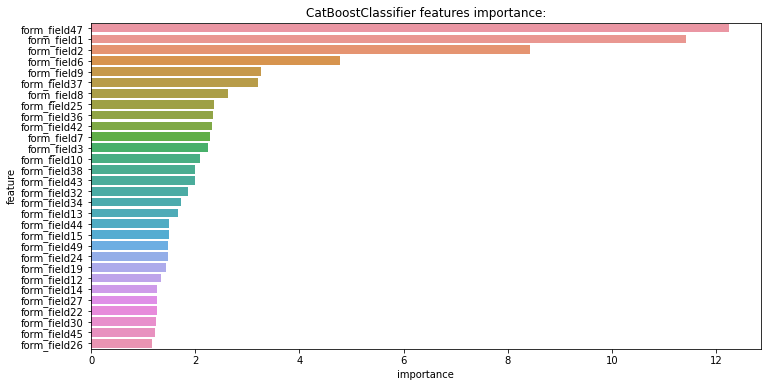

In [ ]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = test_.columns

plt.figure(figsize=(12, 6));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(30))
plt.title('CatBoostClassifier features importance:');

#### Filling Nan values with median

In [ ]:
np.mean(roc_score)

0.838164390501938

In [ ]:
submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('kaggle_cat.csv', index=False)

## GridSearch 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [ ]:
grid = {'n_estimators': [ 1000] }
#'depth': [4,6]}
       
        
        #'l2_leaf_reg': [3, 5]}
        #{'learning_rate': [ 0.02, 0.03],
cat = CatBoostClassifier(task_type='GPU', learning_rate=0.02,  verbose=0, early_stopping_rounds=100)

In [ ]:
rscv = RandomizedSearchCV(cat, grid )

### Randomized Search with Train_test_split

In [ ]:
model =rscv.fit(X_train, y_train)

In [ ]:
rscv.best_estimator_, model.best_params_


In [ ]:
y_pred = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

In [ ]:
submission.head()

In [ ]:
submission.to_csv('prediction_results04.csv')         


In [ ]:
from google.colab import files
pred = model.predict_proba(test_)[:,1]
submission.Applicant_ID = test.Applicant_ID
submission['default_status']= pred
submission.to_csv('prediction_results05.csv', lindex=Fase)         
files.download('prediction_results05.csv')

In [ ]:
y_pred = rscv.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

In [ ]:
rscv.best_estimator_, rscv.best_params_

In [ ]:
pred = rscv.predict_proba(test_)[:,1]
submission['default_status']= pred
submission.to_csv('sub17.csv', index=False)

## Using Parameters from Randomized SearchCV with KFold

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5)

In [ ]:
cat = CatBoostClassifier(task_type='GPU', learning_rate=0.02, n_estimators=1000)


In [ ]:
#X_= pd.DataFrame(X)

roc_score = []
test_pred = []

for train_index, test_index in kf.split(X,y):
    x_train, x_test = X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]
    
    model = cat.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test,y_pred)
    pred = model.predict_proba(test_)[:,1]
    roc_score.append(score)
    test_pred.append(pred)

In [ ]:
np.mean(roc_score)

In [ ]:
submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('sub18.csv', index=False)

In [ ]:
#from google.colab import files
res.to_csv('prediction_results.csv')         
#files.download('prediction_results.csv')

## Trying ensemble techniques

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
xgb = XGBClassifier()
lgb = LGBMClassifier()
ada = AdaBoostClassifier()
rf = RandomForestClassifier()

gb = GradientBoostingClassifier()

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()

### USing XGBoost for prediction

In [ ]:
kf = KFold(n_splits=5)
#X_= pd.DataFrame(X)

roc_score = []
test_pred = []

for train_index, test_index in kf.split(X,y):
    x_train, x_test = X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]
    
    model = xgb.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test,y_pred)
    pred = model.predict_proba(test_)[:,1]
    roc_score.append(score)
    test_pred.append(pred)

In [ ]:
np.mean(roc_score)

In [ ]:
from google.colab import files
submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('xgb.csv', index=False)
files.download('xgb.csv')


### Prediction with LGBMClassifier

In [ ]:
kf = KFold(n_splits=5)
#X_= pd.DataFrame(X)

roc_score = []
test_pred = []

for train_index, test_index in kf.split(X,y):
    x_train, x_test = X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]
    
    model = lgb.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test,y_pred)
    pred = model.predict_proba(test_)[:,1]
    roc_score.append(score)
    test_pred.append(pred)

In [ ]:
np.mean(roc_score)


In [ ]:
from google.colab import files
submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('lgb.csv', index=False)
files.download('lgb.csv')

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

### Voting Classifier

In [ ]:
cat = CatBoostClassifier(task_type='GPU', verbose=0)

In [ ]:
# Defning the ensemble model using VotingClassifer
voting = VotingClassifier(estimators=[('xgb', xgb),('lgb', lgb),('cat',cat)],
voting= 'soft')

In [ ]:
kf = KFold(n_splits=5)
#X_= pd.DataFrame(X)

roc_score = []
test_pred = []

for train_index, test_index in kf.split(X,y):
    x_train, x_test = X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]
    
    model = voting.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test,y_pred)
    pred = model.predict_proba(test_)[:,1]
    roc_score.append(score)
    test_pred.append(pred)

In [ ]:
np.mean(roc_score)

In [ ]:
from google.colab import files
submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('voting.csv', index=False)
files.download('voting.csv')

### Prediction with StackingClassifier

In [ ]:
sc = StackingClassifier([('lgb',lgb), ('xgb',xgb), ('cat', cat)], final_estimator=lr)

In [ ]:
kf = KFold(n_splits=5)
#X_= pd.DataFrame(X)

roc_score = []
test_pred = []

for train_index, test_index in kf.split(X,y):
    x_train, x_test = X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]
    
    model = sc.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test,y_pred)
    pred = model.predict_proba(test_)[:,1]
    roc_score.append(score)
    test_pred.append(pred)

In [ ]:
np.mean(roc_score)

In [ ]:
from google.colab import files
submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('stacking.csv', index=False)
files.download('stacking.csv')

In [ ]:
"""from google.colab import files
pred = model.predict_proba(test_)[:,1]
submission.Applicant_ID = test.Applicant_ID
submission['default_status']= pred
submission.to_csv('prediction_results05.csv', index=False)         
files.download('prediction_results05.csv')"""

### Kfold CV with 3 and 5 splits

3 splits showed improvement in roc score over 5 splits, but 5 splits performed better on LB

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5)

In [ ]:
X_= pd.DataFrame(X)

roc_score = []
test_pred = []

for train_index, test_index in kf.split(X_,y):
    x_train, x_test = X_.iloc[train_index],X_.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]
    
    model = cat.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test,y_pred)
    pred = model.predict_proba(test_)[:,1]
    roc_score.append(score)
    test_pred.append(pred)

In [ ]:
#prediction = gscv.predict_proba(test_sc)[:,1]
np.mean(roc_score)


In [ ]:
submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('sub16.csv', index=False)

### Binning

In [ ]:
num_cols = new_train.select_dtypes(exclude='object').columns

In [ ]:
#for num in num_cols:
 # new_train[num + '_bin'] = pd.cut(new_train[num],bins=4)# duplicates='drop' 
 # new_test[num + '_bin'] = pd.cut(new_test[num],bins=4 )#duplicates='drop' 

#new_train['form_field1_bin'] = pd.cut(new_train.form_field1, bins=4)
#sns.countplot(s)

In [ ]:
#sns.countplot(new_train.form_field18_bin)

### Feature Interaction

In [ ]:
new_train['form_field1*formfield2'] = new_train['form_field1'] * new_train['form_field2']
new_train['form_field1/formfield2'] = new_train['form_field1'] / new_train['form_field2']

new_train['form_field1*formfield3'] = new_train['form_field1'] * new_train.form_field3
new_train['form_field1*formfield4'] = new_train.form_field1 * new_train.form_field4
new_train['form_field1*formfield5'] = new_train.form_field1 * new_train.form_field5

#new_train['form_field30*formfield41'] = new_train['form_field30'] * new_train['form_field41']
##new_train['form_field31*formfield40'] = new_train['form_field31'] * new_train['form_field40']

new_train['form_field6+field7'] =  (new_train.form_field6 + new_train.form_field8)/2
new_train['form_field13/field14'] = (new_train.form_field13 / new_train.form_field14)*100
new_train['form_field32/field33'] = (new_train['form_field32']+ new_train['form_field33'])/2
new_train['form_field36/field38'] = new_train['form_field36'] / new_train['form_field38']
new_train['form_field36/field39'] = new_train['form_field36'] / new_train['form_field39']
new_train['form_field36/field18'] = new_train['form_field36'] / new_train['form_field18']
new_train['form_field36/field20'] = new_train['form_field36'] / new_train['form_field20']
new_train['form_field44*field50'] = new_train['form_field44'] * new_train['form_field50']




In [ ]:
new_test['form_field1*formfield2'] = new_test['form_field1'] * new_test['form_field2']
new_test['form_field1/formfield2'] = new_test['form_field1'] / new_test['form_field2']

new_test['form_field1*formfield3'] = new_test['form_field1'] * new_test.form_field3
new_test['form_field1*formfield4'] = new_test.form_field1 * new_test.form_field4
new_test['form_field1*formfield5'] = new_test.form_field1 * new_test.form_field5

#new_train['form_field30*formfield41'] = new_train['form_field30'] * new_train['form_field41']
##new_train['form_field31*formfield40'] = new_train['form_field31'] * new_train['form_field40']

new_test['form_field6+field7'] =  (new_test.form_field6 + new_test.form_field8)/2
new_test['form_field13/field14'] = (new_test.form_field13 / new_test.form_field14)*100
new_test['form_field32/field33'] = (new_test['form_field32']+ new_test['form_field33'])/2
new_test['form_field36/field38'] = new_test['form_field36'] / new_test['form_field38']
new_test['form_field36/field39'] = new_test['form_field36'] / new_test['form_field39']
new_test['form_field36/field18'] = new_test['form_field36'] / new_test['form_field18']
new_test['form_field36/field20'] = new_test['form_field36'] / new_test['form_field20']
new_test['form_field44*field50'] = new_test['form_field44'] * new_test['form_field50']




### Data Aggregation

In [ ]:
for col in num_cols:
    new_train[col + '_mean_on_field1'] = new_train[col].groupby(new_train['form_field1']).transform('mean')
    new_train[col + '_mean_on_field2'] = new_train[col].groupby(new_train['form_field2']).transform('mean')

    new_train[col + '_sum_on_field1'] = new_train[col].groupby(new_train['form_field1']).transform('sum')
    new_train[col + '_sum_on_field2'] = new_train[col].groupby(new_train['form_field2']).transform('sum')

    new_train[col + '_mean_on_field1'] = new_train[col].groupby(new_train['form_field1']).transform('max')
    new_train[col + '_mean_on_field2'] = new_train[col].groupby(new_train['form_field2']).transform('max')

    new_train[col + '_sum_on_field1'] = new_train[col].groupby(new_train['form_field1']).transform('min')
    new_train[col + '_sum_on_field2'] = new_train[col].groupby(new_train['form_field2']).transform('min')


    new_test[col + '_mean_on_field1'] = new_test[col].groupby(new_test['form_field1']).transform('mean')
    new_test[col + '_mean_on_field2'] = new_test[col].groupby(new_test['form_field2']).transform('mean')

    new_test[col + '_sum_on_field1'] = new_test[col].groupby(new_test['form_field1']).transform('sum')
    new_test[col + '_sum_on_field2'] = new_test[col].groupby(new_test['form_field2']).transform('sum')

    new_test[col + '_mean_on_field1'] = new_test[col].groupby(new_test['form_field1']).transform('max')
    new_test[col + '_mean_on_field2'] = new_test[col].groupby(new_test['form_field2']).transform('max')

    new_test[col + '_sum_on_field1'] = new_test[col].groupby(new_test['form_field1']).transform('min')
    new_test[col + '_sum_on_field2'] = new_test[col].groupby(new_test['form_field2']).transform('min')




    new_train[col + '_mean_on_field1_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field1']]).transform('mean')
    new_train[col + '_mean_on_field2_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field2']]).transform('mean')

    new_train[col + '_sum_on_field1_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field1']]).transform('sum')
    new_train[col + '_sum_on_field2_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field2']]).transform('sum')

    new_train[col + '_mean_on_field1_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field1']]).transform('max')
    new_train[col + '_mean_on_field2_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field2']]).transform('max')

    new_train[col + '_sum_on_field1_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field1']]).transform('min')
    new_train[col + '_sum_on_field2_'] = new_train[col].groupby([new_train['form_field47'],new_train['form_field2']]).transform('min')


    new_test[col + '_mean_on_field1_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field1']]).transform('mean')
    new_test[col + '_mean_on_field2_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field2']]).transform('mean')

    new_test[col + '_sum_on_field1_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field1']]).transform('sum')
    new_test[col + '_sum_on_field2_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field2']]).transform('sum')

    new_test[col + '_mean_on_field1_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field1']]).transform('max')
    new_test[col + '_mean_on_field2_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field2']]).transform('max')

    new_test[col + '_sum_on_field1_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field1']]).transform('min')
    new_test[col + '_sum_on_field2_'] = new_test[col].groupby([new_train['form_field47'],new_test['form_field2']]).transform('min')
    
    
    

In [ ]:
#new_train[col].groupby([new_train['form_field1'],new_train['form_field47']]).transform('mean')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
X = new_train.drop(['default_status','Applicant_ID'], axis=1)
y =new_train.default_status

In [ ]:
#y_ = pd.get_dummies(y)

In [ ]:
X.form_field47 = le.fit_transform(X.form_field47)
new_test.form_field47 = le.fit_transform(new_test.form_field47)


In [ ]:
X_ = (X)
test_ = (new_test.drop('Applicant_ID', axis=1))

In [ ]:
#cat_cols = X_.select_dtypes(include='category').columns
#cat_cols

In [ ]:
test_.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
minmax = MinMaxScaler()

In [ ]:
#X_scaled = minmax.fit_transform(X_)
#test_sc = minmax.fit_transform(test_)

In [ ]:
pip install --quiet catboost

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier



In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
cat = CatBoostClassifier()
xgb = XGBClassifier()
lgb = LGBMClassifier()
ada = AdaBoostClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV, cross_val_score

In [ ]:
from sklearn.metrics import roc_auc_score

## Applied Kfold CV

In [ ]:
kf = KFold(n_splits=5)
cat = CatBoostClassifier(task_type='GPU')#, cat_features=cat_cols)#, learning_rate=0.02, n_estimators=2000, depth=7, early_stopping_rounds=50)


In [ ]:
X_scaled1 = pd.DataFrame(X_)

roc_score = []
test_pred = []

for train_index, test_index in kf.split(X_scaled1,y):
    x_train, x_test = X_scaled1.iloc[train_index],X_scaled1.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]
    
    model = cat.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test,y_pred)
    pred = model.predict_proba(test_)[:,1]
    roc_score.append(score)
    test_pred.append(pred)
  #save result to list

In [ ]:
np.mean(roc_score)

In [ ]:
test

In [ ]:
submission['Applicant_ID'] = test['Applicant_ID']

In [ ]:
#prediction = gscv.predict_proba(test_sc)[:,1]
np.mean(roc_score)
submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('sub10.csv', index=False)

In [ ]:
cat.feature_importances_

In [ ]:
feature_importance_df = pd.DataFrame(cat.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = test_.columns

plt.figure(figsize=(12, 6));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(30))
plt.title('RandomForestClassifier features importance:');

In [ ]:
grid = {'learning_rate': [ 0.05],}
        #'n_estimators': [300, 500] }
       # 'depth': [4,6],}
        #'l2_leaf_reg': [3, 5]}

"""grid_search_result = cat.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)"""

In [ ]:
cat = CatBoostClassifier(task_type='GPU', depth=7, n_estimators=1500, early_stopping_rounds=50)


gscv = GridSearchCV(cat, param_grid=grid)

Tried GridSearch CV

In [ ]:
gscv.fit(X_train, y_train)

In [ ]:
gscv_pred = gscv.predict_proba(X_test)[:,1]
roc_auc_score(y_test, gscv_pred)


In [ ]:
\\prediction = gscv.predict_proba(test_sc)[:,1]

submission['default_status']=prediction
submission.to_csv('submission4.csv', index=False)


In [ ]:
cat = CatBoostClassifier(task_type='GPU', learning_rate=0.03, depth=4, n_estimators=3000, early_stopping_rounds=50)

cat.fit(X_train, y_train, eval_set=(X_test, y_test))

In [ ]:
from sklearn.metrics import roc_auc_score, log_loss

In [ ]:
pred = cat.predict_proba(X_test)[:,1]

In [ ]:
roc_auc_score(y_test, pred)


In [ ]:
roc_auc_score(y_test, pred)


In [ ]:
roc_auc_score(y_test, pred)

In [ ]:
models = [cat, xgb, lgb, ada, rf, lr]

for model in models:
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test,pred)
    print(f'the auc score for {model} is {score}')

In [ ]:
prediction = cat.predict_proba(test_sc)[:,1]

In [ ]:
submission.head()

In [ ]:
prediction = cat.predict_proba(test_sc)[:,1]

submission['default_status']=prediction
submission.to_csv('submission3.csv', index=False)


In [ ]:
submission.to_csv('submission3.csv', index=False)

In [ ]:
len(cat.feature_importances_)
len(test_.columns)

In [ ]:
pip install seaborn

In [ ]:
import seaborn as sns

In [ ]:
feature_importance_df = pd.DataFrame(cat.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = test_.columns

plt.figure(figsize=(12, 6));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(30))
plt.title('RandomForestClassifier features importance:');

## Feature Engineering

In [ ]:
new_train.loc[new_train.form_field1>=3500,'form_field1']=1